# Train the Models for some/all your datasets

### First just run the cell below, it should hopefully complete without error (expect some Warnings from TF)

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size, target = 'same') :
        self.images = images
        self.batch_size = batch_size
        if target == 'same':
            self.target = images
        else:
            self.target = target

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        out_targ = self.target[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_targ
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img


2022-04-07 13:17:39.243541: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Now check that you can find the GPU

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-04-07 13:17:49.596586: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-07 13:17:49.597652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-07 13:17:49.597677: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-07 13:17:49.600403: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-07 13:17:49.603181: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-04-07 13:17:49.604534: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

# Training a Single Dataset

### Either enter the path directly to the dp variable or use the index from the list above

In [10]:
#Either
dp = Path('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/20180727_112544-9cmCL-4Mx.hdf5')
dp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/AdjustedDataset/AOI_dataset.hdf5')

### Create a directory to save our intermediate model checkpoints 

In [11]:
mp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel')
if not mp.exists():
    mp.mkdir()
print(mp)

/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel


### Load in the Data

In [12]:
sample = ProcessedSample(dp, 'Test')

### Create a dictionary to hold some useful information

In [13]:
info = {}

### Create a new Pseudo Dataset with the Background variations removed

In [14]:
ds = hs.load(dp)

In [15]:
interest_mask = np.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/AreaOfInterest.npy')

<IPython.core.display.Javascript object>


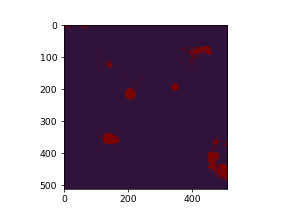

In [16]:
plt.figure()
plt.imshow(interest_mask , cmap='turbo', interpolation='nearest')

In [17]:
new_ds = np.zeros_like(ds)

new_ds[np.where(interest_mask == 0)] = np.mean(ds.data[np.where(interest_mask == 0)], axis = 0)

new_ds[np.where(interest_mask ==1)] = ds.data[np.where(interest_mask ==1)]

new_ds = new_ds.astype('int8')

new_sig = hs.signals.Signal2D(new_ds)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


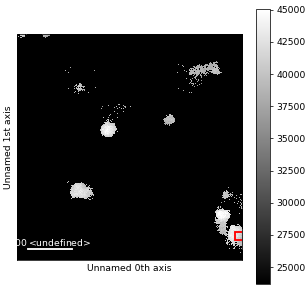

<IPython.core.display.Javascript object>


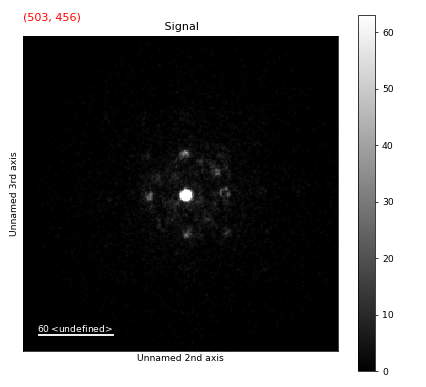

In [23]:
new_sig.plot()

In [24]:
new_sig.save('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/AdjustedDataset/AOI_dataset.hdf5')

### Now Train on New Dataset

In [18]:
dp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/AdjustedDataset/AOI_dataset.hdf5')

In [19]:
sample = ProcessedSample(dp, 'Test')

In [20]:
interest_mask = np.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/AreaOfInterest.npy')

In [21]:
new_ds = hs.load(dp)

In [22]:
bkg_sampling = new_ds.data[np.where(interest_mask == 0)][::1000]

In [23]:
bkg_sampling.shape

(253, 256, 256)

In [24]:
sample_sampling = new_ds.data[np.where(interest_mask ==1)]

In [25]:
sample_sampling.shape

(8397, 256, 256)

In [26]:
raw_id = np.concatenate([bkg_sampling, sample_sampling], axis = 0)

In [27]:
input_data = data_manip_lowq(raw_id)
np.random.shuffle(input_data)
#input_targets = data_manip_lowq(nlds)
#val_data = data_manip_lowq(nl_resample_ds[::10])
#np.random.shuffle(val_data)


started data manipulations
resized


<IPython.core.display.Javascript object>


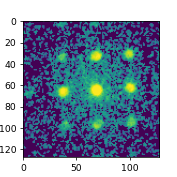

In [29]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])
#plt.figure(figsize = (4,4))
#plt.imshow(input_targets[rand_patt])

##### Otherwise just skip

In [30]:
print(input_data.shape)

(8650, 128, 128)


In [31]:
batch_size = 1024

train_gen = Array_Generator(input_data, batch_size)#, target = input_targets)
#valid_gen = Array_Generator(val_data, batch_size)

batch_shape = train_gen[0][0].shape
input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
out_dims = int(train_gen[0][1].shape[1])

### Set the checkpointing

In [32]:
chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{loss:.5e}.hdf5'
chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = chkpoint_filepath,
    monitor="loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None)

### Redefine the model parameters if you want

In [33]:
rebin_factor = 1

In [34]:
sample_name = 'full'
hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

vae_model = create_vae_model(hparams)
info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}

2022-04-07 13:21:38.834451: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-07 13:21:38.846163: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-04-07 13:21:38.851739: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a486dd9a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-07 13:21:38.851766: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-07 13:21:38.962295: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a486e46370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-04-07 13:21:38.

### Will be helpful to start with a trained model so set one here (otherwise will just take longer)

In [35]:
old_model_path ='/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FitMap9-weights.hdf5'

In [36]:
old_model = create_vae_model(hparams)
old_model.load_weights(old_model_path)

In [37]:
def transfer_layer_weights(old_model, new_model, enc_layer_list, dec_layer_list):
    for l in enc_layer_list:
        w = old_model.get_layer(index = 0).get_layer(index=l).get_weights()
        new_model.get_layer(index = 0).get_layer(index=l).set_weights(w)

    for l in dec_layer_list:
        w = old_model.get_layer(index = 1).get_layer(index=l).get_weights()
        new_model.get_layer(index = 1).get_layer(index=l).set_weights(w)
    return new_model

In [38]:
old_model.encoder.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, 64, 64, 32)   832         enc_input[0][0]                  
__________________________________________________________________________________________________
enc_conv2 (Conv2D)              (None, 32, 32, 64)   51264       enc_conv1[0][0]                  
__________________________________________________________________________________________________
enc_conv3 (Conv2D)              (None, 16, 16, 128)  204928      enc_conv2[0][0]                  
_______________________________________________________________________________________

In [39]:
enc_layer_list = list(range(7))

In [40]:
old_model.decoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_input_t (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dec_d1_t (Dense)             (None, 512)               1536      
_________________________________________________________________
dec_d2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d3 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d4 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d5 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d6 (Dense)               (None, 512)              

In [41]:
dec_layer_list = list(range(9,14))

In [42]:
vae_model = transfer_layer_weights(old_model, vae_model, enc_layer_list, dec_layer_list)

### Train the Model

In [43]:
history = vae_model.fit(train_gen, epochs=10000, callbacks= [chkpoint_model])

Epoch 1/10000


2022-04-07 13:22:13.263112: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-07 13:22:13.529926: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-04-07 13:22:15.049366: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-04-07 13:22:15.454844: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


9/9 [==============================] - ETA: 0s - loss: 11268.4226
Epoch 00001: loss improved from inf to 11144.74316, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-01-1.11447e+04.hdf5
9/9 [==============================] - 57s 6s/step - loss: 11256.0547
Epoch 2/10000
9/9 [==============================] - ETA: 0s - loss: 10983.0447
Epoch 00002: loss improved from 11144.74316 to 10747.99219, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-02-1.07480e+04.hdf5
9/9 [==============================] - 2s 250ms/step - loss: 10959.5395
Epoch 3/10000
9/9 [==============================] - ETA: 0s - loss: 10003.0896
Epoch 00003: loss improved from 10747.99219 to 9589.26270, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-03-9.58926e+03.hdf5
9/9 [==============================] - 2s 253ms/step - loss: 9

Epoch 31/10000
9/9 [==============================] - ETA: 0s - loss: 8734.7925
Epoch 00031: loss did not improve from 8699.06055
9/9 [==============================] - 2s 231ms/step - loss: 8734.0323
Epoch 32/10000
9/9 [==============================] - ETA: 0s - loss: 8734.2793
Epoch 00032: loss did not improve from 8699.06055
9/9 [==============================] - 2s 233ms/step - loss: 8737.4786
Epoch 33/10000
9/9 [==============================] - ETA: 0s - loss: 8733.9017
Epoch 00033: loss did not improve from 8699.06055
9/9 [==============================] - 2s 234ms/step - loss: 8732.1481
Epoch 34/10000
9/9 [==============================] - ETA: 0s - loss: 8733.7812
Epoch 00034: loss did not improve from 8699.06055
9/9 [==============================] - 2s 235ms/step - loss: 8732.0348
Epoch 35/10000
9/9 [==============================] - ETA: 0s - loss: 8733.1978
Epoch 00035: loss did not improve from 8699.06055
9/9 [==============================] - 2s 240ms/step - loss: 8736.

9/9 [==============================] - ETA: 0s - loss: 8727.9964
Epoch 00068: loss did not improve from 8691.50488
9/9 [==============================] - 2s 234ms/step - loss: 8731.1605
Epoch 69/10000
9/9 [==============================] - ETA: 0s - loss: 8727.9148
Epoch 00069: loss did not improve from 8691.50488
9/9 [==============================] - 2s 234ms/step - loss: 8727.9912
Epoch 70/10000
9/9 [==============================] - ETA: 0s - loss: 8727.7860
Epoch 00070: loss did not improve from 8691.50488
9/9 [==============================] - 2s 234ms/step - loss: 8727.3054
Epoch 71/10000
9/9 [==============================] - ETA: 0s - loss: 8728.0666
Epoch 00071: loss did not improve from 8691.50488
9/9 [==============================] - 2s 232ms/step - loss: 8731.1912
Epoch 72/10000
9/9 [==============================] - ETA: 0s - loss: 8727.6645
Epoch 00072: loss did not improve from 8691.50488
9/9 [==============================] - 2s 234ms/step - loss: 8727.1585
Epoch 73/1

Epoch 106/10000
9/9 [==============================] - ETA: 0s - loss: 8725.0196
Epoch 00106: loss did not improve from 8688.59961
9/9 [==============================] - 2s 234ms/step - loss: 8723.2969
Epoch 107/10000
9/9 [==============================] - ETA: 0s - loss: 8725.1381
Epoch 00107: loss did not improve from 8688.59961
9/9 [==============================] - 2s 234ms/step - loss: 8724.3830
Epoch 108/10000
9/9 [==============================] - ETA: 0s - loss: 8725.0984
Epoch 00108: loss did not improve from 8688.59961
9/9 [==============================] - 2s 233ms/step - loss: 8728.3315
Epoch 109/10000
9/9 [==============================] - ETA: 0s - loss: 8724.7657
Epoch 00109: loss did not improve from 8688.59961
9/9 [==============================] - 2s 235ms/step - loss: 8725.8054
Epoch 110/10000
9/9 [==============================] - ETA: 0s - loss: 8724.9583
Epoch 00110: loss did not improve from 8688.59961
9/9 [==============================] - 2s 236ms/step - loss: 

9/9 [==============================] - ETA: 0s - loss: 8699.1965
Epoch 00142: loss improved from 8668.40234 to 8661.03418, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-142-8.66103e+03.hdf5
9/9 [==============================] - 2s 254ms/step - loss: 8695.3803
Epoch 143/10000
9/9 [==============================] - ETA: 0s - loss: 8696.7527
Epoch 00143: loss did not improve from 8661.03418
9/9 [==============================] - 2s 232ms/step - loss: 8699.9777
Epoch 144/10000
9/9 [==============================] - ETA: 0s - loss: 8694.2614
Epoch 00144: loss did not improve from 8661.03418
9/9 [==============================] - 2s 234ms/step - loss: 8693.4035
Epoch 145/10000
9/9 [==============================] - ETA: 0s - loss: 8691.7931
Epoch 00145: loss did not improve from 8661.03418
9/9 [==============================] - 2s 234ms/step - loss: 8690.8408
Epoch 146/10000
9/9 [==============================] - ETA: 0s - l

9/9 [==============================] - ETA: 0s - loss: 8673.2236
Epoch 00179: loss did not improve from 8635.19141
9/9 [==============================] - 2s 234ms/step - loss: 8672.2931
Epoch 180/10000
9/9 [==============================] - ETA: 0s - loss: 8672.9709
Epoch 00180: loss improved from 8635.19141 to 8633.25977, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-180-8.63326e+03.hdf5
9/9 [==============================] - 2s 247ms/step - loss: 8668.9998
Epoch 181/10000
9/9 [==============================] - ETA: 0s - loss: 8672.6250
Epoch 00181: loss did not improve from 8633.25977
9/9 [==============================] - 2s 234ms/step - loss: 8670.7339
Epoch 182/10000
9/9 [==============================] - ETA: 0s - loss: 8672.4906
Epoch 00182: loss did not improve from 8633.25977
9/9 [==============================] - 2s 234ms/step - loss: 8671.5997
Epoch 183/10000
9/9 [==============================] - ETA: 0s - l

Epoch 215/10000
9/9 [==============================] - ETA: 0s - loss: 8664.2208
Epoch 00215: loss did not improve from 8624.40234
9/9 [==============================] - 2s 240ms/step - loss: 8663.3032
Epoch 216/10000
9/9 [==============================] - ETA: 0s - loss: 8664.0482
Epoch 00216: loss did not improve from 8624.40234
9/9 [==============================] - 2s 234ms/step - loss: 8663.1344
Epoch 217/10000
9/9 [==============================] - ETA: 0s - loss: 8663.5563
Epoch 00217: loss did not improve from 8624.40234
9/9 [==============================] - 2s 234ms/step - loss: 8667.1556
Epoch 218/10000
9/9 [==============================] - ETA: 0s - loss: 8663.4251
Epoch 00218: loss did not improve from 8624.40234
9/9 [==============================] - 2s 234ms/step - loss: 8667.0141
Epoch 219/10000
9/9 [==============================] - ETA: 0s - loss: 8663.2754
Epoch 00219: loss did not improve from 8624.40234
9/9 [==============================] - 2s 234ms/step - loss: 

9/9 [==============================] - ETA: 0s - loss: 8659.0737
Epoch 00254: loss did not improve from 8619.29395
9/9 [==============================] - 2s 232ms/step - loss: 8658.1907
Epoch 255/10000
9/9 [==============================] - ETA: 0s - loss: 8659.3419
Epoch 00255: loss did not improve from 8619.29395
9/9 [==============================] - 2s 233ms/step - loss: 8658.4319
Epoch 256/10000
9/9 [==============================] - ETA: 0s - loss: 8658.9677
Epoch 00256: loss did not improve from 8619.29395
9/9 [==============================] - 2s 234ms/step - loss: 8662.5443
Epoch 257/10000
9/9 [==============================] - ETA: 0s - loss: 8659.0064
Epoch 00257: loss did not improve from 8619.29395
9/9 [==============================] - 2s 234ms/step - loss: 8659.9657
Epoch 258/10000
9/9 [==============================] - ETA: 0s - loss: 8659.0284
Epoch 00258: loss did not improve from 8619.29395
9/9 [==============================] - 2s 234ms/step - loss: 8658.0889
Epoch 

Epoch 293/10000
9/9 [==============================] - ETA: 0s - loss: 8656.4234
Epoch 00293: loss did not improve from 8617.29688
9/9 [==============================] - 2s 234ms/step - loss: 8656.4623
Epoch 294/10000
9/9 [==============================] - ETA: 0s - loss: 8655.9873
Epoch 00294: loss did not improve from 8617.29688
9/9 [==============================] - 2s 233ms/step - loss: 8659.6353
Epoch 295/10000
9/9 [==============================] - ETA: 0s - loss: 8656.0030
Epoch 00295: loss did not improve from 8617.29688
9/9 [==============================] - 2s 234ms/step - loss: 8655.4661
Epoch 296/10000
9/9 [==============================] - ETA: 0s - loss: 8655.9147
Epoch 00296: loss did not improve from 8617.29688
9/9 [==============================] - 2s 234ms/step - loss: 8659.4723
Epoch 297/10000
9/9 [==============================] - ETA: 0s - loss: 8655.5961
Epoch 00297: loss did not improve from 8617.29688
9/9 [==============================] - 2s 232ms/step - loss: 

Epoch 332/10000
9/9 [==============================] - ETA: 0s - loss: 8654.0371
Epoch 00332: loss did not improve from 8613.55762
9/9 [==============================] - 2s 232ms/step - loss: 8653.0874
Epoch 333/10000
9/9 [==============================] - ETA: 0s - loss: 8654.0879
Epoch 00333: loss did not improve from 8613.55762
9/9 [==============================] - 2s 235ms/step - loss: 8654.1749
Epoch 334/10000
9/9 [==============================] - ETA: 0s - loss: 8653.7224
Epoch 00334: loss did not improve from 8613.55762
9/9 [==============================] - 2s 234ms/step - loss: 8653.7858
Epoch 335/10000
9/9 [==============================] - ETA: 0s - loss: 8653.4010
Epoch 00335: loss did not improve from 8613.55762
9/9 [==============================] - 2s 234ms/step - loss: 8652.4904
Epoch 336/10000
9/9 [==============================] - ETA: 0s - loss: 8653.2383
Epoch 00336: loss did not improve from 8613.55762
9/9 [==============================] - 2s 234ms/step - loss: 

Epoch 372/10000
9/9 [==============================] - ETA: 0s - loss: 8650.8504
Epoch 00372: loss did not improve from 8611.74512
9/9 [==============================] - 2s 234ms/step - loss: 8650.9475
Epoch 373/10000
9/9 [==============================] - ETA: 0s - loss: 8650.7331
Epoch 00373: loss did not improve from 8611.74512
9/9 [==============================] - 2s 233ms/step - loss: 8651.6603
Epoch 374/10000
9/9 [==============================] - ETA: 0s - loss: 8651.9532
Epoch 00374: loss did not improve from 8611.74512
9/9 [==============================] - 2s 234ms/step - loss: 8651.3942
Epoch 375/10000
9/9 [==============================] - ETA: 0s - loss: 8650.9529
Epoch 00375: loss did not improve from 8611.74512
9/9 [==============================] - 2s 242ms/step - loss: 8654.6318
Epoch 376/10000
9/9 [==============================] - ETA: 0s - loss: 8651.0817
Epoch 00376: loss did not improve from 8611.74512
9/9 [==============================] - 2s 234ms/step - loss: 

9/9 [==============================] - ETA: 0s - loss: 8649.0082
Epoch 00409: loss did not improve from 8608.24121
9/9 [==============================] - 2s 235ms/step - loss: 8652.5385
Epoch 410/10000
9/9 [==============================] - ETA: 0s - loss: 8649.3746
Epoch 00410: loss did not improve from 8608.24121
9/9 [==============================] - 2s 234ms/step - loss: 8652.8721
Epoch 411/10000
9/9 [==============================] - ETA: 0s - loss: 8649.3841
Epoch 00411: loss did not improve from 8608.24121
9/9 [==============================] - 2s 234ms/step - loss: 8647.5493
Epoch 412/10000
9/9 [==============================] - ETA: 0s - loss: 8648.5654
Epoch 00412: loss did not improve from 8608.24121
9/9 [==============================] - 2s 234ms/step - loss: 8648.6634
Epoch 413/10000
9/9 [==============================] - ETA: 0s - loss: 8648.4384
Epoch 00413: loss did not improve from 8608.24121
9/9 [==============================] - 2s 234ms/step - loss: 8646.5938
Epoch 

9/9 [==============================] - ETA: 0s - loss: 8647.1641
Epoch 00446: loss improved from 8606.76562 to 8606.62891, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-446-8.60663e+03.hdf5
9/9 [==============================] - 2s 250ms/step - loss: 8643.1105
Epoch 447/10000
9/9 [==============================] - ETA: 0s - loss: 8647.2565
Epoch 00447: loss did not improve from 8606.62891
9/9 [==============================] - 2s 234ms/step - loss: 8645.3804
Epoch 448/10000
9/9 [==============================] - ETA: 0s - loss: 8646.9748
Epoch 00448: loss did not improve from 8606.62891
9/9 [==============================] - 2s 234ms/step - loss: 8646.0827
Epoch 449/10000
9/9 [==============================] - ETA: 0s - loss: 8646.8235
Epoch 00449: loss did not improve from 8606.62891
9/9 [==============================] - 2s 234ms/step - loss: 8646.3434
Epoch 450/10000
9/9 [==============================] - ETA: 0s - l

Epoch 485/10000
9/9 [==============================] - ETA: 0s - loss: 8645.9622
Epoch 00485: loss did not improve from 8605.57031
9/9 [==============================] - 2s 235ms/step - loss: 8649.3811
Epoch 486/10000
9/9 [==============================] - ETA: 0s - loss: 8646.0753
Epoch 00486: loss improved from 8605.57031 to 8605.46973, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-486-8.60547e+03.hdf5
9/9 [==============================] - 2s 249ms/step - loss: 8642.0147
Epoch 487/10000
9/9 [==============================] - ETA: 0s - loss: 8645.5138
Epoch 00487: loss did not improve from 8605.46973
9/9 [==============================] - 2s 234ms/step - loss: 8644.6094
Epoch 488/10000
9/9 [==============================] - ETA: 0s - loss: 8645.3620
Epoch 00488: loss did not improve from 8605.46973
9/9 [==============================] - 2s 234ms/step - loss: 8644.4734
Epoch 489/10000
9/9 [=============================

Epoch 525/10000
9/9 [==============================] - ETA: 0s - loss: 8644.5508
Epoch 00525: loss did not improve from 8605.46973
9/9 [==============================] - 2s 234ms/step - loss: 8642.7665
Epoch 526/10000
9/9 [==============================] - ETA: 0s - loss: 8645.1273
Epoch 00526: loss did not improve from 8605.46973
9/9 [==============================] - 2s 234ms/step - loss: 8643.2913
Epoch 527/10000
9/9 [==============================] - ETA: 0s - loss: 8644.7050
Epoch 00527: loss did not improve from 8605.46973
9/9 [==============================] - 2s 240ms/step - loss: 8642.8213
Epoch 528/10000
9/9 [==============================] - ETA: 0s - loss: 8644.4706
Epoch 00528: loss did not improve from 8605.46973
9/9 [==============================] - 2s 234ms/step - loss: 8643.5758
Epoch 529/10000
9/9 [==============================] - ETA: 0s - loss: 8644.2440
Epoch 00529: loss did not improve from 8605.46973
9/9 [==============================] - 2s 234ms/step - loss: 

9/9 [==============================] - ETA: 0s - loss: 8643.7128
Epoch 00564: loss did not improve from 8602.86426
9/9 [==============================] - 2s 234ms/step - loss: 8643.2475
Epoch 565/10000
9/9 [==============================] - ETA: 0s - loss: 8643.4032
Epoch 00565: loss did not improve from 8602.86426
9/9 [==============================] - 2s 234ms/step - loss: 8646.7772
Epoch 566/10000
9/9 [==============================] - ETA: 0s - loss: 8643.2589
Epoch 00566: loss did not improve from 8602.86426
9/9 [==============================] - 2s 234ms/step - loss: 8644.1992
Epoch 567/10000
9/9 [==============================] - ETA: 0s - loss: 8643.1711
Epoch 00567: loss did not improve from 8602.86426
9/9 [==============================] - 2s 234ms/step - loss: 8641.3193
Epoch 568/10000
9/9 [==============================] - ETA: 0s - loss: 8643.2045
Epoch 00568: loss did not improve from 8602.86426
9/9 [==============================] - 2s 234ms/step - loss: 8642.3208
Epoch 

9/9 [==============================] - ETA: 0s - loss: 8642.5385
Epoch 00603: loss improved from 8602.13379 to 8601.70605, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-603-8.60171e+03.hdf5
9/9 [==============================] - 2s 252ms/step - loss: 8638.4553
Epoch 604/10000
9/9 [==============================] - ETA: 0s - loss: 8642.3396
Epoch 00604: loss did not improve from 8601.70605
9/9 [==============================] - 2s 234ms/step - loss: 8640.4681
Epoch 605/10000
9/9 [==============================] - ETA: 0s - loss: 8642.5965
Epoch 00605: loss did not improve from 8601.70605
9/9 [==============================] - 2s 234ms/step - loss: 8638.5431
Epoch 606/10000
9/9 [==============================] - ETA: 0s - loss: 8642.6809
Epoch 00606: loss did not improve from 8601.70605
9/9 [==============================] - 2s 235ms/step - loss: 8641.7574
Epoch 607/10000
9/9 [==============================] - ETA: 0s - l

Epoch 641/10000
9/9 [==============================] - ETA: 0s - loss: 8641.6514
Epoch 00641: loss did not improve from 8600.97656
9/9 [==============================] - 2s 234ms/step - loss: 8644.9813
Epoch 642/10000
9/9 [==============================] - ETA: 0s - loss: 8641.4018
Epoch 00642: loss did not improve from 8600.97656
9/9 [==============================] - 2s 235ms/step - loss: 8642.3345
Epoch 643/10000
9/9 [==============================] - ETA: 0s - loss: 8641.4215
Epoch 00643: loss did not improve from 8600.97656
9/9 [==============================] - 2s 235ms/step - loss: 8640.9877
Epoch 644/10000
9/9 [==============================] - ETA: 0s - loss: 8641.9023
Epoch 00644: loss did not improve from 8600.97656
9/9 [==============================] - 2s 234ms/step - loss: 8640.9576
Epoch 645/10000
9/9 [==============================] - ETA: 0s - loss: 8641.3338
Epoch 00645: loss did not improve from 8600.97656
9/9 [==============================] - 2s 234ms/step - loss: 

Epoch 681/10000
9/9 [==============================] - ETA: 0s - loss: 8640.5590
Epoch 00681: loss did not improve from 8600.58594
9/9 [==============================] - 2s 234ms/step - loss: 8640.7187
Epoch 682/10000
9/9 [==============================] - ETA: 0s - loss: 8640.5716
Epoch 00682: loss did not improve from 8600.58594
9/9 [==============================] - 2s 234ms/step - loss: 8644.3273
Epoch 683/10000
9/9 [==============================] - ETA: 0s - loss: 8641.1401
Epoch 00683: loss did not improve from 8600.58594
9/9 [==============================] - 2s 234ms/step - loss: 8644.9360
Epoch 684/10000
9/9 [==============================] - ETA: 0s - loss: 8641.0266
Epoch 00684: loss did not improve from 8600.58594
9/9 [==============================] - 2s 234ms/step - loss: 8640.5397
Epoch 685/10000
9/9 [==============================] - ETA: 0s - loss: 8642.0316
Epoch 00685: loss did not improve from 8600.58594
9/9 [==============================] - 2s 235ms/step - loss: 

9/9 [==============================] - ETA: 0s - loss: 8640.4111
Epoch 00718: loss did not improve from 8599.48828
9/9 [==============================] - 2s 235ms/step - loss: 8644.1642
Epoch 719/10000
9/9 [==============================] - ETA: 0s - loss: 8640.4733
Epoch 00719: loss did not improve from 8599.48828
9/9 [==============================] - 2s 234ms/step - loss: 8640.6094
Epoch 720/10000
9/9 [==============================] - ETA: 0s - loss: 8640.7514
Epoch 00720: loss did not improve from 8599.48828
9/9 [==============================] - 2s 233ms/step - loss: 8639.9202
Epoch 721/10000
9/9 [==============================] - ETA: 0s - loss: 8640.3574
Epoch 00721: loss did not improve from 8599.48828
9/9 [==============================] - 2s 234ms/step - loss: 8638.5057
Epoch 722/10000
9/9 [==============================] - ETA: 0s - loss: 8640.0533
Epoch 00722: loss did not improve from 8599.48828
9/9 [==============================] - 2s 234ms/step - loss: 8643.2870
Epoch 

Epoch 758/10000
9/9 [==============================] - ETA: 0s - loss: 8640.2303
Epoch 00758: loss did not improve from 8599.11328
9/9 [==============================] - 2s 234ms/step - loss: 8639.8006
Epoch 759/10000
9/9 [==============================] - ETA: 0s - loss: 8639.2652
Epoch 00759: loss did not improve from 8599.11328
9/9 [==============================] - 2s 234ms/step - loss: 8638.8583
Epoch 760/10000
9/9 [==============================] - ETA: 0s - loss: 8639.1599
Epoch 00760: loss did not improve from 8599.11328
9/9 [==============================] - 2s 240ms/step - loss: 8639.3267
Epoch 761/10000
9/9 [==============================] - ETA: 0s - loss: 8639.5508
Epoch 00761: loss did not improve from 8599.11328
9/9 [==============================] - 2s 234ms/step - loss: 8637.7374
Epoch 762/10000
9/9 [==============================] - ETA: 0s - loss: 8639.2167
Epoch 00762: loss did not improve from 8599.11328
9/9 [==============================] - 2s 234ms/step - loss: 

9/9 [==============================] - ETA: 0s - loss: 8638.9316
Epoch 00797: loss did not improve from 8598.21387
9/9 [==============================] - 2s 234ms/step - loss: 8642.1433
Epoch 798/10000
9/9 [==============================] - ETA: 0s - loss: 8638.8372
Epoch 00798: loss did not improve from 8598.21387
9/9 [==============================] - 2s 233ms/step - loss: 8636.9829
Epoch 799/10000
9/9 [==============================] - ETA: 0s - loss: 8638.9444
Epoch 00799: loss did not improve from 8598.21387
9/9 [==============================] - 2s 234ms/step - loss: 8639.0796
Epoch 800/10000
9/9 [==============================] - ETA: 0s - loss: 8638.5238
Epoch 00800: loss improved from 8598.21387 to 8598.14551, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-800-8.59815e+03.hdf5
9/9 [==============================] - 2s 252ms/step - loss: 8634.4859
Epoch 801/10000
9/9 [==============================] - ETA: 0s - l

9/9 [==============================] - ETA: 0s - loss: 8638.3312
Epoch 00836: loss did not improve from 8597.53125
9/9 [==============================] - 2s 234ms/step - loss: 8637.9227
Epoch 837/10000
9/9 [==============================] - ETA: 0s - loss: 8637.6683
Epoch 00837: loss did not improve from 8597.53125
9/9 [==============================] - 2s 234ms/step - loss: 8635.8288
Epoch 838/10000
9/9 [==============================] - ETA: 0s - loss: 8637.7975
Epoch 00838: loss did not improve from 8597.53125
9/9 [==============================] - 2s 234ms/step - loss: 8636.9029
Epoch 839/10000
9/9 [==============================] - ETA: 0s - loss: 8637.9351
Epoch 00839: loss did not improve from 8597.53125
9/9 [==============================] - 2s 234ms/step - loss: 8638.8953
Epoch 840/10000
9/9 [==============================] - ETA: 0s - loss: 8637.6842
Epoch 00840: loss did not improve from 8597.53125
9/9 [==============================] - 2s 234ms/step - loss: 8640.8624
Epoch 

9/9 [==============================] - ETA: 0s - loss: 8637.1034
Epoch 00875: loss did not improve from 8596.81934
9/9 [==============================] - 2s 235ms/step - loss: 8640.8298
Epoch 876/10000
9/9 [==============================] - ETA: 0s - loss: 8636.9975
Epoch 00876: loss did not improve from 8596.81934
9/9 [==============================] - 2s 235ms/step - loss: 8636.6159
Epoch 877/10000
9/9 [==============================] - ETA: 0s - loss: 8637.3647
Epoch 00877: loss did not improve from 8596.81934
9/9 [==============================] - 2s 235ms/step - loss: 8641.0939
Epoch 878/10000
9/9 [==============================] - ETA: 0s - loss: 8637.1507
Epoch 00878: loss did not improve from 8596.81934
9/9 [==============================] - 2s 234ms/step - loss: 8636.3019
Epoch 879/10000
9/9 [==============================] - ETA: 0s - loss: 8637.1875
Epoch 00879: loss did not improve from 8596.81934
9/9 [==============================] - 2s 234ms/step - loss: 8635.3678
Epoch 

Epoch 915/10000
9/9 [==============================] - ETA: 0s - loss: 8636.3632
Epoch 00915: loss did not improve from 8596.63184
9/9 [==============================] - 2s 234ms/step - loss: 8639.4649
Epoch 916/10000
9/9 [==============================] - ETA: 0s - loss: 8636.4986
Epoch 00916: loss did not improve from 8596.63184
9/9 [==============================] - 2s 234ms/step - loss: 8634.6624
Epoch 917/10000
9/9 [==============================] - ETA: 0s - loss: 8636.6215
Epoch 00917: loss did not improve from 8596.63184
9/9 [==============================] - 2s 234ms/step - loss: 8636.9187
Epoch 918/10000
9/9 [==============================] - ETA: 0s - loss: 8636.8780
Epoch 00918: loss did not improve from 8596.63184
9/9 [==============================] - 2s 234ms/step - loss: 8635.9959
Epoch 919/10000
9/9 [==============================] - ETA: 0s - loss: 8636.3186
Epoch 00919: loss did not improve from 8596.63184
9/9 [==============================] - 2s 235ms/step - loss: 

Epoch 954/10000
9/9 [==============================] - ETA: 0s - loss: 8636.0305
Epoch 00954: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 8632.0471
Epoch 955/10000
9/9 [==============================] - ETA: 0s - loss: 8636.7434
Epoch 00955: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 8636.9165
Epoch 956/10000
9/9 [==============================] - ETA: 0s - loss: 8636.1571
Epoch 00956: loss did not improve from 8595.92188
9/9 [==============================] - 2s 235ms/step - loss: 8636.3485
Epoch 957/10000
9/9 [==============================] - ETA: 0s - loss: 8636.1279
Epoch 00957: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 8637.1464
Epoch 958/10000
9/9 [==============================] - ETA: 0s - loss: 8636.3538
Epoch 00958: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 

Epoch 995/10000
9/9 [==============================] - ETA: 0s - loss: 8635.3356
Epoch 00995: loss did not improve from 8595.92188
9/9 [==============================] - 2s 233ms/step - loss: 8635.5339
Epoch 996/10000
9/9 [==============================] - ETA: 0s - loss: 8635.2973
Epoch 00996: loss did not improve from 8595.92188
9/9 [==============================] - 2s 240ms/step - loss: 8636.2664
Epoch 997/10000
9/9 [==============================] - ETA: 0s - loss: 8635.2947
Epoch 00997: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 8633.5141
Epoch 998/10000
9/9 [==============================] - ETA: 0s - loss: 8635.8866
Epoch 00998: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 8635.2217
Epoch 999/10000
9/9 [==============================] - ETA: 0s - loss: 8635.7117
Epoch 00999: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 

9/9 [==============================] - ETA: 0s - loss: 8635.3393
Epoch 01035: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 8635.5081
Epoch 1036/10000
9/9 [==============================] - ETA: 0s - loss: 8635.2638
Epoch 01036: loss did not improve from 8595.92188
9/9 [==============================] - 2s 235ms/step - loss: 8633.4483
Epoch 1037/10000
9/9 [==============================] - ETA: 0s - loss: 8634.8690
Epoch 01037: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 8634.1015
Epoch 1038/10000
9/9 [==============================] - ETA: 0s - loss: 8634.9176
Epoch 01038: loss did not improve from 8595.92188
9/9 [==============================] - 2s 233ms/step - loss: 8635.1241
Epoch 1039/10000
9/9 [==============================] - ETA: 0s - loss: 8634.7777
Epoch 01039: loss did not improve from 8595.92188
9/9 [==============================] - 2s 234ms/step - loss: 8633.9884
Ep

9/9 [==============================] - ETA: 0s - loss: 8635.2061
Epoch 01073: loss did not improve from 8594.59082
9/9 [==============================] - 2s 234ms/step - loss: 8634.7878
Epoch 1074/10000
9/9 [==============================] - ETA: 0s - loss: 8634.9666
Epoch 01074: loss did not improve from 8594.59082
9/9 [==============================] - 2s 234ms/step - loss: 8638.7183
Epoch 1075/10000
9/9 [==============================] - ETA: 0s - loss: 8634.6415
Epoch 01075: loss did not improve from 8594.59082
9/9 [==============================] - 2s 240ms/step - loss: 8638.3862
Epoch 1076/10000
9/9 [==============================] - ETA: 0s - loss: 8634.4988
Epoch 01076: loss did not improve from 8594.59082
9/9 [==============================] - 2s 234ms/step - loss: 8637.4754
Epoch 1077/10000
9/9 [==============================] - ETA: 0s - loss: 8634.6190
Epoch 01077: loss did not improve from 8594.59082
9/9 [==============================] - 2s 234ms/step - loss: 8632.8942
Ep

9/9 [==============================] - ETA: 0s - loss: 8634.7609
Epoch 01111: loss did not improve from 8594.01270
9/9 [==============================] - 2s 234ms/step - loss: 8637.5990
Epoch 1112/10000
9/9 [==============================] - ETA: 0s - loss: 8633.8962
Epoch 01112: loss did not improve from 8594.01270
9/9 [==============================] - 2s 232ms/step - loss: 8637.6923
Epoch 1113/10000
9/9 [==============================] - ETA: 0s - loss: 8638.9010
Epoch 01113: loss did not improve from 8594.01270
9/9 [==============================] - 2s 234ms/step - loss: 8635.0410
Epoch 1114/10000
9/9 [==============================] - ETA: 0s - loss: 8637.3711
Epoch 01114: loss did not improve from 8594.01270
9/9 [==============================] - 2s 234ms/step - loss: 8636.4900
Epoch 1115/10000
9/9 [==============================] - ETA: 0s - loss: 8635.4771
Epoch 01115: loss did not improve from 8594.01270
9/9 [==============================] - 2s 234ms/step - loss: 8636.4477
Ep

Epoch 1151/10000
9/9 [==============================] - ETA: 0s - loss: 8634.0895
Epoch 01151: loss did not improve from 8593.67090
9/9 [==============================] - 2s 234ms/step - loss: 8633.7687
Epoch 1152/10000
9/9 [==============================] - ETA: 0s - loss: 8633.5252
Epoch 01152: loss improved from 8593.67090 to 8593.62500, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-1152-8.59362e+03.hdf5
9/9 [==============================] - 2s 251ms/step - loss: 8629.5352
Epoch 1153/10000
9/9 [==============================] - ETA: 0s - loss: 8633.8124
Epoch 01153: loss did not improve from 8593.62500
9/9 [==============================] - 2s 234ms/step - loss: 8634.1526
Epoch 1154/10000
9/9 [==============================] - ETA: 0s - loss: 8633.9658
Epoch 01154: loss did not improve from 8593.62500
9/9 [==============================] - 2s 234ms/step - loss: 8637.7083
Epoch 1155/10000
9/9 [=======================

Epoch 1190/10000
9/9 [==============================] - ETA: 0s - loss: 8633.5418
Epoch 01190: loss did not improve from 8593.52246
9/9 [==============================] - 2s 234ms/step - loss: 8632.7824
Epoch 1191/10000
9/9 [==============================] - ETA: 0s - loss: 8633.2683
Epoch 01191: loss did not improve from 8593.52246
9/9 [==============================] - 2s 234ms/step - loss: 8632.4770
Epoch 1192/10000
9/9 [==============================] - ETA: 0s - loss: 8633.3441
Epoch 01192: loss did not improve from 8593.52246
9/9 [==============================] - 2s 234ms/step - loss: 8637.0970
Epoch 1193/10000
9/9 [==============================] - ETA: 0s - loss: 8633.4650
Epoch 01193: loss did not improve from 8593.52246
9/9 [==============================] - 2s 234ms/step - loss: 8633.7748
Epoch 1194/10000
9/9 [==============================] - ETA: 0s - loss: 8633.4838
Epoch 01194: loss did not improve from 8593.52246
9/9 [==============================] - 2s 234ms/step - l

Epoch 1229/10000
9/9 [==============================] - ETA: 0s - loss: 8633.1596
Epoch 01229: loss did not improve from 8592.73535
9/9 [==============================] - 2s 235ms/step - loss: 8636.9546
Epoch 1230/10000
9/9 [==============================] - ETA: 0s - loss: 8633.1227
Epoch 01230: loss did not improve from 8592.73535
9/9 [==============================] - 2s 235ms/step - loss: 8633.3684
Epoch 1231/10000
9/9 [==============================] - ETA: 0s - loss: 8632.8003
Epoch 01231: loss did not improve from 8592.73535
9/9 [==============================] - 2s 234ms/step - loss: 8632.0494
Epoch 1232/10000
9/9 [==============================] - ETA: 0s - loss: 8632.7477
Epoch 01232: loss did not improve from 8592.73535
9/9 [==============================] - 2s 234ms/step - loss: 8633.7297
Epoch 1233/10000
9/9 [==============================] - ETA: 0s - loss: 8634.4716
Epoch 01233: loss did not improve from 8592.73535
9/9 [==============================] - 2s 240ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8632.6019
Epoch 01269: loss did not improve from 8592.73535
9/9 [==============================] - 2s 234ms/step - loss: 8631.8116
Epoch 1270/10000
9/9 [==============================] - ETA: 0s - loss: 8632.7512
Epoch 01270: loss did not improve from 8592.73535
9/9 [==============================] - 2s 234ms/step - loss: 8631.9036
Epoch 1271/10000
9/9 [==============================] - ETA: 0s - loss: 8632.3636
Epoch 01271: loss improved from 8592.73535 to 8592.45020, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-1271-8.59245e+03.hdf5
9/9 [==============================] - 2s 254ms/step - loss: 8628.3723
Epoch 1272/10000
9/9 [==============================] - ETA: 0s - loss: 8632.4247
Epoch 01272: loss did not improve from 8592.45020
9/9 [==============================] - 2s 234ms/step - loss: 8636.2139
Epoch 1273/10000
9/9 [==============================] - ETA: 0

Epoch 1309/10000
9/9 [==============================] - ETA: 0s - loss: 8632.6795
Epoch 01309: loss did not improve from 8592.45020
9/9 [==============================] - 2s 236ms/step - loss: 8632.1311
Epoch 1310/10000
9/9 [==============================] - ETA: 0s - loss: 8633.1158
Epoch 01310: loss did not improve from 8592.45020
9/9 [==============================] - 2s 235ms/step - loss: 8632.7698
Epoch 1311/10000
9/9 [==============================] - ETA: 0s - loss: 8636.0739
Epoch 01311: loss did not improve from 8592.45020
9/9 [==============================] - 2s 237ms/step - loss: 8636.6285
Epoch 1312/10000
9/9 [==============================] - ETA: 0s - loss: 8635.6831
Epoch 01312: loss did not improve from 8592.45020
9/9 [==============================] - 2s 236ms/step - loss: 8639.3619
Epoch 1313/10000
9/9 [==============================] - ETA: 0s - loss: 8633.3929
Epoch 01313: loss did not improve from 8592.45020
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8631.9221
Epoch 01347: loss did not improve from 8591.84668
9/9 [==============================] - 2s 234ms/step - loss: 8632.9498
Epoch 1348/10000
9/9 [==============================] - ETA: 0s - loss: 8632.2420
Epoch 01348: loss did not improve from 8591.84668
9/9 [==============================] - 2s 240ms/step - loss: 8633.2543
Epoch 1349/10000
9/9 [==============================] - ETA: 0s - loss: 8631.8648
Epoch 01349: loss did not improve from 8591.84668
9/9 [==============================] - 2s 234ms/step - loss: 8631.5744
Epoch 1350/10000
9/9 [==============================] - ETA: 0s - loss: 8631.8766
Epoch 01350: loss did not improve from 8591.84668
9/9 [==============================] - 2s 234ms/step - loss: 8631.0641
Epoch 1351/10000
9/9 [==============================] - ETA: 0s - loss: 8631.6681
Epoch 01351: loss did not improve from 8591.84668
9/9 [==============================] - 2s 234ms/step - loss: 8634.3408
Ep

Epoch 1388/10000
9/9 [==============================] - ETA: 0s - loss: 8631.5343
Epoch 01388: loss did not improve from 8591.80762
9/9 [==============================] - 2s 234ms/step - loss: 8630.7753
Epoch 1389/10000
9/9 [==============================] - ETA: 0s - loss: 8631.3516
Epoch 01389: loss did not improve from 8591.80762
9/9 [==============================] - 2s 234ms/step - loss: 8634.0568
Epoch 1390/10000
9/9 [==============================] - ETA: 0s - loss: 8631.7067
Epoch 01390: loss did not improve from 8591.80762
9/9 [==============================] - 2s 234ms/step - loss: 8630.9668
Epoch 1391/10000
9/9 [==============================] - ETA: 0s - loss: 8631.9014
Epoch 01391: loss did not improve from 8591.80762
9/9 [==============================] - 2s 234ms/step - loss: 8632.9112
Epoch 1392/10000
9/9 [==============================] - ETA: 0s - loss: 8632.1653
Epoch 01392: loss did not improve from 8591.80762
9/9 [==============================] - 2s 234ms/step - l

Epoch 1428/10000
9/9 [==============================] - ETA: 0s - loss: 8631.0932
Epoch 01428: loss did not improve from 8591.47754
9/9 [==============================] - 2s 234ms/step - loss: 8631.3612
Epoch 1429/10000
9/9 [==============================] - ETA: 0s - loss: 8631.1179
Epoch 01429: loss did not improve from 8591.47754
9/9 [==============================] - 2s 234ms/step - loss: 8634.8854
Epoch 1430/10000
9/9 [==============================] - ETA: 0s - loss: 8630.7556
Epoch 01430: loss did not improve from 8591.47754
9/9 [==============================] - 2s 234ms/step - loss: 8629.0343
Epoch 1431/10000
9/9 [==============================] - ETA: 0s - loss: 8630.7823
Epoch 01431: loss improved from 8591.47754 to 8591.42578, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-1431-8.59143e+03.hdf5
9/9 [==============================] - 2s 251ms/step - loss: 8626.8467
Epoch 1432/10000
9/9 [=======================

Epoch 1467/10000
9/9 [==============================] - ETA: 0s - loss: 8630.5286
Epoch 01467: loss improved from 8591.33594 to 8590.93457, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-1467-8.59093e+03.hdf5
9/9 [==============================] - 2s 254ms/step - loss: 8626.5692
Epoch 1468/10000
9/9 [==============================] - ETA: 0s - loss: 8630.8154
Epoch 01468: loss did not improve from 8590.93457
9/9 [==============================] - 2s 234ms/step - loss: 8626.8334
Epoch 1469/10000
9/9 [==============================] - ETA: 0s - loss: 8630.8747
Epoch 01469: loss did not improve from 8590.93457
9/9 [==============================] - 2s 234ms/step - loss: 8630.0341
Epoch 1470/10000
9/9 [==============================] - ETA: 0s - loss: 8630.4193
Epoch 01470: loss did not improve from 8590.93457
9/9 [==============================] - 2s 234ms/step - loss: 8631.4660
Epoch 1471/10000
9/9 [=======================

Epoch 1506/10000
9/9 [==============================] - ETA: 0s - loss: 8630.7733
Epoch 01506: loss did not improve from 8590.55469
9/9 [==============================] - 2s 233ms/step - loss: 8631.8857
Epoch 1507/10000
9/9 [==============================] - ETA: 0s - loss: 8630.7431
Epoch 01507: loss did not improve from 8590.55469
9/9 [==============================] - 2s 234ms/step - loss: 8631.8141
Epoch 1508/10000
9/9 [==============================] - ETA: 0s - loss: 8631.0607
Epoch 01508: loss did not improve from 8590.55469
9/9 [==============================] - 2s 234ms/step - loss: 8630.7802
Epoch 1509/10000
9/9 [==============================] - ETA: 0s - loss: 8630.6376
Epoch 01509: loss did not improve from 8590.55469
9/9 [==============================] - 2s 234ms/step - loss: 8628.8729
Epoch 1510/10000
9/9 [==============================] - ETA: 0s - loss: 8631.0598
Epoch 01510: loss did not improve from 8590.55469
9/9 [==============================] - 2s 234ms/step - l

Epoch 1546/10000
9/9 [==============================] - ETA: 0s - loss: 8629.7988
Epoch 01546: loss did not improve from 8590.49805
9/9 [==============================] - 2s 234ms/step - loss: 8632.2541
Epoch 1547/10000
9/9 [==============================] - ETA: 0s - loss: 8630.1887
Epoch 01547: loss did not improve from 8590.49805
9/9 [==============================] - 2s 240ms/step - loss: 8629.8949
Epoch 1548/10000
9/9 [==============================] - ETA: 0s - loss: 8630.2423
Epoch 01548: loss did not improve from 8590.49805
9/9 [==============================] - 2s 234ms/step - loss: 8628.5252
Epoch 1549/10000
9/9 [==============================] - ETA: 0s - loss: 8630.4873
Epoch 01549: loss did not improve from 8590.49805
9/9 [==============================] - 2s 235ms/step - loss: 8632.9871
Epoch 1550/10000
9/9 [==============================] - ETA: 0s - loss: 8630.1386
Epoch 01550: loss did not improve from 8590.49805
9/9 [==============================] - 2s 234ms/step - l

Epoch 1586/10000
9/9 [==============================] - ETA: 0s - loss: 8629.7029
Epoch 01586: loss improved from 8590.08789 to 8589.99316, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-1586-8.58999e+03.hdf5
9/9 [==============================] - 2s 251ms/step - loss: 8625.7319
Epoch 1587/10000
9/9 [==============================] - ETA: 0s - loss: 8629.4913
Epoch 01587: loss did not improve from 8589.99316
9/9 [==============================] - 2s 232ms/step - loss: 8627.7543
Epoch 1588/10000
9/9 [==============================] - ETA: 0s - loss: 8629.3656
Epoch 01588: loss did not improve from 8589.99316
9/9 [==============================] - 2s 234ms/step - loss: 8628.5859
Epoch 1589/10000
9/9 [==============================] - ETA: 0s - loss: 8629.6126
Epoch 01589: loss did not improve from 8589.99316
9/9 [==============================] - 2s 234ms/step - loss: 8633.3707
Epoch 1590/10000
9/9 [=======================

Epoch 1626/10000
9/9 [==============================] - ETA: 0s - loss: 8629.4120
Epoch 01626: loss did not improve from 8589.99316
9/9 [==============================] - 2s 240ms/step - loss: 8633.2223
Epoch 1627/10000
9/9 [==============================] - ETA: 0s - loss: 8629.2410
Epoch 01627: loss did not improve from 8589.99316
9/9 [==============================] - 2s 234ms/step - loss: 8629.5999
Epoch 1628/10000
9/9 [==============================] - ETA: 0s - loss: 8629.4791
Epoch 01628: loss did not improve from 8589.99316
9/9 [==============================] - 2s 234ms/step - loss: 8633.3361
Epoch 1629/10000
9/9 [==============================] - ETA: 0s - loss: 8629.4655
Epoch 01629: loss did not improve from 8589.99316
9/9 [==============================] - 2s 234ms/step - loss: 8625.5312
Epoch 1630/10000
9/9 [==============================] - ETA: 0s - loss: 8629.4626
Epoch 01630: loss did not improve from 8589.99316
9/9 [==============================] - 2s 234ms/step - l

Epoch 1666/10000
9/9 [==============================] - ETA: 0s - loss: 8628.9883
Epoch 01666: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8629.3450
Epoch 1667/10000
9/9 [==============================] - ETA: 0s - loss: 8628.8539
Epoch 01667: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.6508
Epoch 1668/10000
9/9 [==============================] - ETA: 0s - loss: 8628.7848
Epoch 01668: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8628.0523
Epoch 1669/10000
9/9 [==============================] - ETA: 0s - loss: 8628.8377
Epoch 01669: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8629.8971
Epoch 1670/10000
9/9 [==============================] - ETA: 0s - loss: 8628.7555
Epoch 01670: loss did not improve from 8589.74316
9/9 [==============================] - 2s 236ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8665.3959
Epoch 01706: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8668.9305
Epoch 1707/10000
9/9 [==============================] - ETA: 0s - loss: 8664.7196
Epoch 01707: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8662.8792
Epoch 1708/10000
9/9 [==============================] - ETA: 0s - loss: 8664.1223
Epoch 01708: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8667.7205
Epoch 1709/10000
9/9 [==============================] - ETA: 0s - loss: 8663.7105
Epoch 01709: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8662.7883
Epoch 1710/10000
9/9 [==============================] - ETA: 0s - loss: 8663.3099
Epoch 01710: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8662.4192
Ep

Epoch 1747/10000
9/9 [==============================] - ETA: 0s - loss: 8655.6067
Epoch 01747: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8651.5890
Epoch 1748/10000
9/9 [==============================] - ETA: 0s - loss: 8655.5194
Epoch 01748: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8656.4470
Epoch 1749/10000
9/9 [==============================] - ETA: 0s - loss: 8655.3859
Epoch 01749: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8654.4844
Epoch 1750/10000
9/9 [==============================] - ETA: 0s - loss: 8655.2700
Epoch 01750: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8655.3595
Epoch 1751/10000
9/9 [==============================] - ETA: 0s - loss: 8655.0829
Epoch 01751: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8651.4768
Epoch 01787: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8649.6757
Epoch 1788/10000
9/9 [==============================] - ETA: 0s - loss: 8651.3613
Epoch 01788: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8649.5490
Epoch 1789/10000
9/9 [==============================] - ETA: 0s - loss: 8651.3334
Epoch 01789: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8652.2313
Epoch 1790/10000
9/9 [==============================] - ETA: 0s - loss: 8651.7666
Epoch 01790: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8651.8602
Epoch 1791/10000
9/9 [==============================] - ETA: 0s - loss: 8651.4304
Epoch 01791: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8654.8472
Ep

Epoch 1828/10000
9/9 [==============================] - ETA: 0s - loss: 8648.8868
Epoch 01828: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8649.7860
Epoch 1829/10000
9/9 [==============================] - ETA: 0s - loss: 8648.6274
Epoch 01829: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8651.9802
Epoch 1830/10000
9/9 [==============================] - ETA: 0s - loss: 8648.4455
Epoch 01830: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8644.3761
Epoch 1831/10000
9/9 [==============================] - ETA: 0s - loss: 8648.4616
Epoch 01831: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8648.6230
Epoch 1832/10000
9/9 [==============================] - ETA: 0s - loss: 8648.6181
Epoch 01832: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8646.3946
Epoch 01868: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8642.3504
Epoch 1869/10000
9/9 [==============================] - ETA: 0s - loss: 8646.5798
Epoch 01869: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8646.7631
Epoch 1870/10000
9/9 [==============================] - ETA: 0s - loss: 8646.3656
Epoch 01870: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8649.5664
Epoch 1871/10000
9/9 [==============================] - ETA: 0s - loss: 8646.4531
Epoch 01871: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8647.3670
Epoch 1872/10000
9/9 [==============================] - ETA: 0s - loss: 8646.1705
Epoch 01872: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8649.8891
Ep

Epoch 1909/10000
9/9 [==============================] - ETA: 0s - loss: 8644.9670
Epoch 01909: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8644.0918
Epoch 1910/10000
9/9 [==============================] - ETA: 0s - loss: 8644.7335
Epoch 01910: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8643.8663
Epoch 1911/10000
9/9 [==============================] - ETA: 0s - loss: 8644.4922
Epoch 01911: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8640.4715
Epoch 1912/10000
9/9 [==============================] - ETA: 0s - loss: 8644.2926
Epoch 01912: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8643.4735
Epoch 1913/10000
9/9 [==============================] - ETA: 0s - loss: 8644.3205
Epoch 01913: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8643.8275
Epoch 01949: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8644.7250
Epoch 1950/10000
9/9 [==============================] - ETA: 0s - loss: 8643.1896
Epoch 01950: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8641.4483
Epoch 1951/10000
9/9 [==============================] - ETA: 0s - loss: 8643.4812
Epoch 01951: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8639.4609
Epoch 1952/10000
9/9 [==============================] - ETA: 0s - loss: 8643.4120
Epoch 01952: loss did not improve from 8589.74316
9/9 [==============================] - 2s 233ms/step - loss: 8646.4870
Epoch 1953/10000
9/9 [==============================] - ETA: 0s - loss: 8643.6493
Epoch 01953: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8643.2243
Ep

Epoch 1990/10000
9/9 [==============================] - ETA: 0s - loss: 8642.0332
Epoch 01990: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8645.1046
Epoch 1991/10000
9/9 [==============================] - ETA: 0s - loss: 8642.1668
Epoch 01991: loss did not improve from 8589.74316
9/9 [==============================] - 2s 236ms/step - loss: 8642.3843
Epoch 1992/10000
9/9 [==============================] - ETA: 0s - loss: 8641.7526
Epoch 01992: loss did not improve from 8589.74316
9/9 [==============================] - 2s 235ms/step - loss: 8642.7594
Epoch 1993/10000
9/9 [==============================] - ETA: 0s - loss: 8641.8870
Epoch 01993: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8640.0844
Epoch 1994/10000
9/9 [==============================] - ETA: 0s - loss: 8642.9984
Epoch 01994: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8641.1025
Epoch 02030: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8640.2641
Epoch 2031/10000
9/9 [==============================] - ETA: 0s - loss: 8641.1568
Epoch 02031: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8641.3446
Epoch 2032/10000
9/9 [==============================] - ETA: 0s - loss: 8640.7872
Epoch 02032: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8639.9301
Epoch 2033/10000
9/9 [==============================] - ETA: 0s - loss: 8640.9817
Epoch 02033: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8640.1444
Epoch 2034/10000
9/9 [==============================] - ETA: 0s - loss: 8641.4966
Epoch 02034: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8642.4834
Ep

Epoch 2071/10000
9/9 [==============================] - ETA: 0s - loss: 8640.1389
Epoch 02071: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8639.7218
Epoch 2072/10000
9/9 [==============================] - ETA: 0s - loss: 8639.9824
Epoch 02072: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8640.1498
Epoch 2073/10000
9/9 [==============================] - ETA: 0s - loss: 8639.6380
Epoch 02073: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8639.8920
Epoch 2074/10000
9/9 [==============================] - ETA: 0s - loss: 8640.6756
Epoch 02074: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8636.5782
Epoch 2075/10000
9/9 [==============================] - ETA: 0s - loss: 8640.0033
Epoch 02075: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8639.4555
Epoch 02111: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8638.5936
Epoch 2112/10000
9/9 [==============================] - ETA: 0s - loss: 8639.1795
Epoch 02112: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8638.3433
Epoch 2113/10000
9/9 [==============================] - ETA: 0s - loss: 8639.1286
Epoch 02113: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8640.1904
Epoch 2114/10000
9/9 [==============================] - ETA: 0s - loss: 8639.9640
Epoch 02114: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8639.2021
Epoch 2115/10000
9/9 [==============================] - ETA: 0s - loss: 8639.7612
Epoch 02115: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8640.6833
Ep

Epoch 2152/10000
9/9 [==============================] - ETA: 0s - loss: 8640.4682
Epoch 02152: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8639.6977
Epoch 2153/10000
9/9 [==============================] - ETA: 0s - loss: 8640.4310
Epoch 02153: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8641.2605
Epoch 2154/10000
9/9 [==============================] - ETA: 0s - loss: 8639.9408
Epoch 02154: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8639.9950
Epoch 2155/10000
9/9 [==============================] - ETA: 0s - loss: 8639.1718
Epoch 02155: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8638.7209
Epoch 2156/10000
9/9 [==============================] - ETA: 0s - loss: 8638.4910
Epoch 02156: loss did not improve from 8589.74316
9/9 [==============================] - 2s 233ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8637.8776
Epoch 02192: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8636.1971
Epoch 2193/10000
9/9 [==============================] - ETA: 0s - loss: 8637.9812
Epoch 02193: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8641.7303
Epoch 2194/10000
9/9 [==============================] - ETA: 0s - loss: 8637.8840
Epoch 02194: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8637.0489
Epoch 2195/10000
9/9 [==============================] - ETA: 0s - loss: 8638.3575
Epoch 02195: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8638.6655
Epoch 2196/10000
9/9 [==============================] - ETA: 0s - loss: 8637.8995
Epoch 02196: loss did not improve from 8589.74316
9/9 [==============================] - 2s 235ms/step - loss: 8640.7412
Ep

Epoch 2233/10000
9/9 [==============================] - ETA: 0s - loss: 8637.4645
Epoch 02233: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8636.6521
Epoch 2234/10000
9/9 [==============================] - ETA: 0s - loss: 8636.8302
Epoch 02234: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8637.8298
Epoch 2235/10000
9/9 [==============================] - ETA: 0s - loss: 8636.6867
Epoch 02235: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8635.8845
Epoch 2236/10000
9/9 [==============================] - ETA: 0s - loss: 8637.4901
Epoch 02236: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.4081
Epoch 2237/10000
9/9 [==============================] - ETA: 0s - loss: 8637.3556
Epoch 02237: loss did not improve from 8589.74316
9/9 [==============================] - 2s 236ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8636.5193
Epoch 02273: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8640.2986
Epoch 2274/10000
9/9 [==============================] - ETA: 0s - loss: 8636.3007
Epoch 02274: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8634.5549
Epoch 2275/10000
9/9 [==============================] - ETA: 0s - loss: 8636.4151
Epoch 02275: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8635.6983
Epoch 2276/10000
9/9 [==============================] - ETA: 0s - loss: 8636.3044
Epoch 02276: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8635.4833
Epoch 2277/10000
9/9 [==============================] - ETA: 0s - loss: 8636.1195
Epoch 02277: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8635.8034
Ep

Epoch 2314/10000
9/9 [==============================] - ETA: 0s - loss: 8635.9501
Epoch 02314: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8634.1996
Epoch 2315/10000
9/9 [==============================] - ETA: 0s - loss: 8636.1465
Epoch 02315: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.2354
Epoch 2316/10000
9/9 [==============================] - ETA: 0s - loss: 8637.2938
Epoch 02316: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8638.4367
Epoch 2317/10000
9/9 [==============================] - ETA: 0s - loss: 8636.3644
Epoch 02317: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8635.5979
Epoch 2318/10000
9/9 [==============================] - ETA: 0s - loss: 8636.5248
Epoch 02318: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8634.9533
Epoch 02354: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8634.1869
Epoch 2355/10000
9/9 [==============================] - ETA: 0s - loss: 8635.1157
Epoch 02355: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8636.1560
Epoch 2356/10000
9/9 [==============================] - ETA: 0s - loss: 8635.1638
Epoch 02356: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8634.4034
Epoch 2357/10000
9/9 [==============================] - ETA: 0s - loss: 8634.9597
Epoch 02357: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8636.0010
Epoch 2358/10000
9/9 [==============================] - ETA: 0s - loss: 8635.0558
Epoch 02358: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8637.7479
Ep

Epoch 2395/10000
9/9 [==============================] - ETA: 0s - loss: 8634.9558
Epoch 02395: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.2714
Epoch 2396/10000
9/9 [==============================] - ETA: 0s - loss: 8634.9366
Epoch 02396: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8634.1374
Epoch 2397/10000
9/9 [==============================] - ETA: 0s - loss: 8634.7102
Epoch 02397: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.9372
Epoch 2398/10000
9/9 [==============================] - ETA: 0s - loss: 8635.4054
Epoch 02398: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8639.1818
Epoch 2399/10000
9/9 [==============================] - ETA: 0s - loss: 8635.6972
Epoch 02399: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8634.0264
Epoch 02435: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.2867
Epoch 2436/10000
9/9 [==============================] - ETA: 0s - loss: 8634.0869
Epoch 02436: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8634.3561
Epoch 2437/10000
9/9 [==============================] - ETA: 0s - loss: 8634.0241
Epoch 02437: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8637.8275
Epoch 2438/10000
9/9 [==============================] - ETA: 0s - loss: 8634.2983
Epoch 02438: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8638.0461
Epoch 2439/10000
9/9 [==============================] - ETA: 0s - loss: 8634.3201
Epoch 02439: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8634.5945
Ep

Epoch 2476/10000
9/9 [==============================] - ETA: 0s - loss: 8634.2564
Epoch 02476: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.5118
Epoch 2477/10000
9/9 [==============================] - ETA: 0s - loss: 8634.2276
Epoch 02477: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8632.4435
Epoch 2478/10000
9/9 [==============================] - ETA: 0s - loss: 8633.7250
Epoch 02478: loss did not improve from 8589.74316
9/9 [==============================] - 2s 231ms/step - loss: 8629.8208
Epoch 2479/10000
9/9 [==============================] - ETA: 0s - loss: 8634.0024
Epoch 02479: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8636.5419
Epoch 2480/10000
9/9 [==============================] - ETA: 0s - loss: 8633.9137
Epoch 02480: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8633.8166
Epoch 02516: loss did not improve from 8589.74316
9/9 [==============================] - 2s 233ms/step - loss: 8634.0981
Epoch 2517/10000
9/9 [==============================] - ETA: 0s - loss: 8633.9918
Epoch 02517: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.2938
Epoch 2518/10000
9/9 [==============================] - ETA: 0s - loss: 8634.3892
Epoch 02518: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.6095
Epoch 2519/10000
9/9 [==============================] - ETA: 0s - loss: 8633.8669
Epoch 02519: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8634.1047
Epoch 2520/10000
9/9 [==============================] - ETA: 0s - loss: 8633.7378
Epoch 02520: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8637.4952
Ep

Epoch 2557/10000
9/9 [==============================] - ETA: 0s - loss: 8633.1331
Epoch 02557: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.3965
Epoch 2558/10000
9/9 [==============================] - ETA: 0s - loss: 8632.9465
Epoch 02558: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.1961
Epoch 2559/10000
9/9 [==============================] - ETA: 0s - loss: 8633.3030
Epoch 02559: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8629.2826
Epoch 2560/10000
9/9 [==============================] - ETA: 0s - loss: 8633.1814
Epoch 02560: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8631.4045
Epoch 2561/10000
9/9 [==============================] - ETA: 0s - loss: 8633.5059
Epoch 02561: loss did not improve from 8589.74316
9/9 [==============================] - 2s 236ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8632.7394
Epoch 02597: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8635.2144
Epoch 2598/10000
9/9 [==============================] - ETA: 0s - loss: 8633.5275
Epoch 02598: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8633.8854
Epoch 2599/10000
9/9 [==============================] - ETA: 0s - loss: 8632.8532
Epoch 02599: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8628.8476
Epoch 2600/10000
9/9 [==============================] - ETA: 0s - loss: 8632.6479
Epoch 02600: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.4211
Epoch 2601/10000
9/9 [==============================] - ETA: 0s - loss: 8633.1472
Epoch 02601: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8636.9453
Ep

Epoch 2638/10000
9/9 [==============================] - ETA: 0s - loss: 8631.9617
Epoch 02638: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8635.7769
Epoch 2639/10000
9/9 [==============================] - ETA: 0s - loss: 8632.2152
Epoch 02639: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8631.4742
Epoch 2640/10000
9/9 [==============================] - ETA: 0s - loss: 8632.3368
Epoch 02640: loss did not improve from 8589.74316
9/9 [==============================] - 2s 235ms/step - loss: 8633.4123
Epoch 2641/10000
9/9 [==============================] - ETA: 0s - loss: 8632.4970
Epoch 02641: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8630.9292
Epoch 2642/10000
9/9 [==============================] - ETA: 0s - loss: 8633.2920
Epoch 02642: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8632.6801
Epoch 02678: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8635.0906
Epoch 2679/10000
9/9 [==============================] - ETA: 0s - loss: 8632.9596
Epoch 02679: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8636.7177
Epoch 2680/10000
9/9 [==============================] - ETA: 0s - loss: 8632.2909
Epoch 02680: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8631.6159
Epoch 2681/10000
9/9 [==============================] - ETA: 0s - loss: 8632.1250
Epoch 02681: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.2221
Epoch 2682/10000
9/9 [==============================] - ETA: 0s - loss: 8631.8895
Epoch 02682: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.1618
Ep

Epoch 2719/10000
9/9 [==============================] - ETA: 0s - loss: 8631.8265
Epoch 02719: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8634.1590
Epoch 2720/10000
9/9 [==============================] - ETA: 0s - loss: 8631.8963
Epoch 02720: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8627.9194
Epoch 2721/10000
9/9 [==============================] - ETA: 0s - loss: 8631.9562
Epoch 02721: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.0106
Epoch 2722/10000
9/9 [==============================] - ETA: 0s - loss: 8631.7603
Epoch 02722: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.0691
Epoch 2723/10000
9/9 [==============================] - ETA: 0s - loss: 8631.9092
Epoch 02723: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8631.6436
Epoch 02759: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8629.9537
Epoch 2760/10000
9/9 [==============================] - ETA: 0s - loss: 8631.6861
Epoch 02760: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8635.4330
Epoch 2761/10000
9/9 [==============================] - ETA: 0s - loss: 8631.5360
Epoch 02761: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8630.8413
Epoch 2762/10000
9/9 [==============================] - ETA: 0s - loss: 8631.8097
Epoch 02762: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8632.9756
Epoch 2763/10000
9/9 [==============================] - ETA: 0s - loss: 8631.5030
Epoch 02763: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8630.8451
Ep

Epoch 2800/10000
9/9 [==============================] - ETA: 0s - loss: 8631.0596
Epoch 02800: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.3004
Epoch 2801/10000
9/9 [==============================] - ETA: 0s - loss: 8631.1699
Epoch 02801: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8627.1647
Epoch 2802/10000
9/9 [==============================] - ETA: 0s - loss: 8630.8933
Epoch 02802: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8626.9136
Epoch 2803/10000
9/9 [==============================] - ETA: 0s - loss: 8630.6077
Epoch 02803: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8626.6373
Epoch 2804/10000
9/9 [==============================] - ETA: 0s - loss: 8631.1008
Epoch 02804: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8631.9067
Epoch 02840: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8630.1770
Epoch 2841/10000
9/9 [==============================] - ETA: 0s - loss: 8631.9594
Epoch 02841: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.1591
Epoch 2842/10000
9/9 [==============================] - ETA: 0s - loss: 8632.0071
Epoch 02842: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8631.7296
Epoch 2843/10000
9/9 [==============================] - ETA: 0s - loss: 8631.1359
Epoch 02843: loss did not improve from 8589.74316
9/9 [==============================] - 2s 233ms/step - loss: 8633.2902
Epoch 2844/10000
9/9 [==============================] - ETA: 0s - loss: 8631.3634
Epoch 02844: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8627.4368
Ep

Epoch 2881/10000
9/9 [==============================] - ETA: 0s - loss: 8630.7260
Epoch 02881: loss did not improve from 8589.74316
9/9 [==============================] - 2s 233ms/step - loss: 8631.8267
Epoch 2882/10000
9/9 [==============================] - ETA: 0s - loss: 8630.4975
Epoch 02882: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8634.3104
Epoch 2883/10000
9/9 [==============================] - ETA: 0s - loss: 8630.8087
Epoch 02883: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8629.1623
Epoch 2884/10000
9/9 [==============================] - ETA: 0s - loss: 8630.4447
Epoch 02884: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8626.4489
Epoch 2885/10000
9/9 [==============================] - ETA: 0s - loss: 8631.4007
Epoch 02885: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8630.0831
Epoch 02921: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8630.3811
Epoch 2922/10000
9/9 [==============================] - ETA: 0s - loss: 8629.8219
Epoch 02922: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8629.1330
Epoch 2923/10000
9/9 [==============================] - ETA: 0s - loss: 8630.3353
Epoch 02923: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8634.1866
Epoch 2924/10000
9/9 [==============================] - ETA: 0s - loss: 8629.9783
Epoch 02924: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8629.2908
Epoch 2925/10000
9/9 [==============================] - ETA: 0s - loss: 8630.0375
Epoch 02925: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8629.3252
Ep

Epoch 2962/10000
9/9 [==============================] - ETA: 0s - loss: 8630.4035
Epoch 02962: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8630.1605
Epoch 2963/10000
9/9 [==============================] - ETA: 0s - loss: 8630.1221
Epoch 02963: loss did not improve from 8589.74316
9/9 [==============================] - 2s 232ms/step - loss: 8634.0194
Epoch 2964/10000
9/9 [==============================] - ETA: 0s - loss: 8630.1041
Epoch 02964: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8631.2287
Epoch 2965/10000
9/9 [==============================] - ETA: 0s - loss: 8630.1057
Epoch 02965: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8629.3970
Epoch 2966/10000
9/9 [==============================] - ETA: 0s - loss: 8629.8132
Epoch 02966: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8629.6948
Epoch 03002: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8628.9507
Epoch 3003/10000
9/9 [==============================] - ETA: 0s - loss: 8630.2950
Epoch 03003: loss did not improve from 8589.74316
9/9 [==============================] - 2s 240ms/step - loss: 8628.5746
Epoch 3004/10000
9/9 [==============================] - ETA: 0s - loss: 8630.0353
Epoch 03004: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8633.9768
Epoch 3005/10000
9/9 [==============================] - ETA: 0s - loss: 8630.6209
Epoch 03005: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8629.9632
Epoch 3006/10000
9/9 [==============================] - ETA: 0s - loss: 8630.1637
Epoch 03006: loss did not improve from 8589.74316
9/9 [==============================] - 2s 234ms/step - loss: 8630.4470
Ep

Epoch 3042/10000
9/9 [==============================] - ETA: 0s - loss: 8629.0559
Epoch 03042: loss improved from 8589.72168 to 8589.69043, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-3042-8.58969e+03.hdf5
9/9 [==============================] - 2s 254ms/step - loss: 8625.1193
Epoch 3043/10000
9/9 [==============================] - ETA: 0s - loss: 8629.6963
Epoch 03043: loss did not improve from 8589.69043
9/9 [==============================] - 2s 234ms/step - loss: 8629.5324
Epoch 3044/10000
9/9 [==============================] - ETA: 0s - loss: 8629.3708
Epoch 03044: loss did not improve from 8589.69043
9/9 [==============================] - 2s 232ms/step - loss: 8629.6895
Epoch 3045/10000
9/9 [==============================] - ETA: 0s - loss: 8628.9859
Epoch 03045: loss did not improve from 8589.69043
9/9 [==============================] - 2s 234ms/step - loss: 8630.1075
Epoch 3046/10000
9/9 [=======================

Epoch 3082/10000
9/9 [==============================] - ETA: 0s - loss: 8629.5381
Epoch 03082: loss did not improve from 8589.69043
9/9 [==============================] - 2s 234ms/step - loss: 8627.9157
Epoch 3083/10000
9/9 [==============================] - ETA: 0s - loss: 8629.1853
Epoch 03083: loss did not improve from 8589.69043
9/9 [==============================] - 2s 234ms/step - loss: 8628.9661
Epoch 3084/10000
9/9 [==============================] - ETA: 0s - loss: 8628.7428
Epoch 03084: loss did not improve from 8589.69043
9/9 [==============================] - 2s 234ms/step - loss: 8629.0985
Epoch 3085/10000
9/9 [==============================] - ETA: 0s - loss: 8628.8627
Epoch 03085: loss did not improve from 8589.69043
9/9 [==============================] - 2s 234ms/step - loss: 8627.2046
Epoch 3086/10000
9/9 [==============================] - ETA: 0s - loss: 8628.9570
Epoch 03086: loss did not improve from 8589.69043
9/9 [==============================] - 2s 236ms/step - l

Epoch 3121/10000
9/9 [==============================] - ETA: 0s - loss: 8628.4989
Epoch 03121: loss did not improve from 8588.94043
9/9 [==============================] - 2s 234ms/step - loss: 8627.8283
Epoch 3122/10000
9/9 [==============================] - ETA: 0s - loss: 8628.9260
Epoch 03122: loss did not improve from 8588.94043
9/9 [==============================] - 2s 233ms/step - loss: 8628.7753
Epoch 3123/10000
9/9 [==============================] - ETA: 0s - loss: 8629.0559
Epoch 03123: loss did not improve from 8588.94043
9/9 [==============================] - 2s 234ms/step - loss: 8629.4908
Epoch 3124/10000
9/9 [==============================] - ETA: 0s - loss: 8628.9312
Epoch 03124: loss did not improve from 8588.94043
9/9 [==============================] - 2s 234ms/step - loss: 8627.2395
Epoch 3125/10000
9/9 [==============================] - ETA: 0s - loss: 8628.8054
Epoch 03125: loss did not improve from 8588.94043
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8628.5132
Epoch 03161: loss did not improve from 8588.94043
9/9 [==============================] - 2s 233ms/step - loss: 8628.8771
Epoch 3162/10000
9/9 [==============================] - ETA: 0s - loss: 8628.5098
Epoch 03162: loss did not improve from 8588.94043
9/9 [==============================] - 2s 234ms/step - loss: 8630.3843
Epoch 3163/10000
9/9 [==============================] - ETA: 0s - loss: 8628.6946
Epoch 03163: loss did not improve from 8588.94043
9/9 [==============================] - 2s 234ms/step - loss: 8628.4666
Epoch 3164/10000
9/9 [==============================] - ETA: 0s - loss: 8628.1700
Epoch 03164: loss did not improve from 8588.94043
9/9 [==============================] - 2s 234ms/step - loss: 8626.5453
Epoch 3165/10000
9/9 [==============================] - ETA: 0s - loss: 8629.1804
Epoch 03165: loss did not improve from 8588.94043
9/9 [==============================] - 2s 234ms/step - loss: 8628.9719
Ep

Epoch 3201/10000
9/9 [==============================] - ETA: 0s - loss: 8628.7992
Epoch 03201: loss did not improve from 8588.78906
9/9 [==============================] - 2s 234ms/step - loss: 8627.1739
Epoch 3202/10000
9/9 [==============================] - ETA: 0s - loss: 8628.4156
Epoch 03202: loss did not improve from 8588.78906
9/9 [==============================] - 2s 234ms/step - loss: 8628.2108
Epoch 3203/10000
9/9 [==============================] - ETA: 0s - loss: 8628.6815
Epoch 03203: loss did not improve from 8588.78906
9/9 [==============================] - 2s 234ms/step - loss: 8632.8141
Epoch 3204/10000
9/9 [==============================] - ETA: 0s - loss: 8629.3076
Epoch 03204: loss did not improve from 8588.78906
9/9 [==============================] - 2s 234ms/step - loss: 8631.1428
Epoch 3205/10000
9/9 [==============================] - ETA: 0s - loss: 8629.8130
Epoch 03205: loss did not improve from 8588.78906
9/9 [==============================] - 2s 235ms/step - l

Epoch 3241/10000
9/9 [==============================] - ETA: 0s - loss: 8628.6298
Epoch 03241: loss did not improve from 8588.71973
9/9 [==============================] - 2s 234ms/step - loss: 8630.3800
Epoch 3242/10000
9/9 [==============================] - ETA: 0s - loss: 8628.7741
Epoch 03242: loss did not improve from 8588.71973
9/9 [==============================] - 2s 234ms/step - loss: 8624.8146
Epoch 3243/10000
9/9 [==============================] - ETA: 0s - loss: 8629.2043
Epoch 03243: loss did not improve from 8588.71973
9/9 [==============================] - 2s 234ms/step - loss: 8630.3754
Epoch 3244/10000
9/9 [==============================] - ETA: 0s - loss: 8628.6565
Epoch 03244: loss did not improve from 8588.71973
9/9 [==============================] - 2s 234ms/step - loss: 8624.7531
Epoch 3245/10000
9/9 [==============================] - ETA: 0s - loss: 8628.5130
Epoch 03245: loss did not improve from 8588.71973
9/9 [==============================] - 2s 234ms/step - l

Epoch 3280/10000
9/9 [==============================] - ETA: 0s - loss: 8627.3683
Epoch 03280: loss did not improve from 8588.22363
9/9 [==============================] - 2s 234ms/step - loss: 8631.2402
Epoch 3281/10000
9/9 [==============================] - ETA: 0s - loss: 8627.3690
Epoch 03281: loss did not improve from 8588.22363
9/9 [==============================] - 2s 240ms/step - loss: 8628.4813
Epoch 3282/10000
9/9 [==============================] - ETA: 0s - loss: 8628.4468
Epoch 03282: loss did not improve from 8588.22363
9/9 [==============================] - 2s 240ms/step - loss: 8628.3222
Epoch 3283/10000
9/9 [==============================] - ETA: 0s - loss: 8628.4164
Epoch 03283: loss did not improve from 8588.22363
9/9 [==============================] - 2s 234ms/step - loss: 8627.7466
Epoch 3284/10000
9/9 [==============================] - ETA: 0s - loss: 8628.0205
Epoch 03284: loss did not improve from 8588.22363
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8627.5244
Epoch 03320: loss did not improve from 8588.22363
9/9 [==============================] - 2s 234ms/step - loss: 8625.9100
Epoch 3321/10000
9/9 [==============================] - ETA: 0s - loss: 8626.9972
Epoch 03321: loss did not improve from 8588.22363
9/9 [==============================] - 2s 234ms/step - loss: 8630.8617
Epoch 3322/10000
9/9 [==============================] - ETA: 0s - loss: 8627.4691
Epoch 03322: loss improved from 8588.22363 to 8588.06836, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-3322-8.58807e+03.hdf5
9/9 [==============================] - 2s 251ms/step - loss: 8623.5290
Epoch 3323/10000
9/9 [==============================] - ETA: 0s - loss: 8627.4498
Epoch 03323: loss did not improve from 8588.06836
9/9 [==============================] - 2s 235ms/step - loss: 8631.2795
Epoch 3324/10000
9/9 [==============================] - ETA: 0

Epoch 3360/10000
9/9 [==============================] - ETA: 0s - loss: 8628.2279
Epoch 03360: loss did not improve from 8588.06836
9/9 [==============================] - 2s 235ms/step - loss: 8627.5884
Epoch 3361/10000
9/9 [==============================] - ETA: 0s - loss: 8627.8945
Epoch 03361: loss did not improve from 8588.06836
9/9 [==============================] - 2s 235ms/step - loss: 8631.6999
Epoch 3362/10000
9/9 [==============================] - ETA: 0s - loss: 8627.4757
Epoch 03362: loss did not improve from 8588.06836
9/9 [==============================] - 2s 234ms/step - loss: 8623.5886
Epoch 3363/10000
9/9 [==============================] - ETA: 0s - loss: 8627.2574
Epoch 03363: loss did not improve from 8588.06836
9/9 [==============================] - 2s 234ms/step - loss: 8626.6451
Epoch 3364/10000
9/9 [==============================] - ETA: 0s - loss: 8627.6578
Epoch 03364: loss did not improve from 8588.06836
9/9 [==============================] - 2s 240ms/step - l

Epoch 3400/10000
9/9 [==============================] - ETA: 0s - loss: 8627.7161
Epoch 03400: loss did not improve from 8587.66699
9/9 [==============================] - 2s 234ms/step - loss: 8627.0805
Epoch 3401/10000
9/9 [==============================] - ETA: 0s - loss: 8626.9116
Epoch 03401: loss did not improve from 8587.66699
9/9 [==============================] - 2s 234ms/step - loss: 8628.0364
Epoch 3402/10000
9/9 [==============================] - ETA: 0s - loss: 8626.9737
Epoch 03402: loss did not improve from 8587.66699
9/9 [==============================] - 2s 235ms/step - loss: 8625.3646
Epoch 3403/10000
9/9 [==============================] - ETA: 0s - loss: 8627.2142
Epoch 03403: loss did not improve from 8587.66699
9/9 [==============================] - 2s 234ms/step - loss: 8625.8205
Epoch 3404/10000
9/9 [==============================] - ETA: 0s - loss: 8627.2350
Epoch 03404: loss did not improve from 8587.66699
9/9 [==============================] - 2s 234ms/step - l

Epoch 3440/10000
9/9 [==============================] - ETA: 0s - loss: 8626.5655
Epoch 03440: loss did not improve from 8587.61914
9/9 [==============================] - 2s 234ms/step - loss: 8626.9461
Epoch 3441/10000
9/9 [==============================] - ETA: 0s - loss: 8626.6037
Epoch 03441: loss did not improve from 8587.61914
9/9 [==============================] - 2s 234ms/step - loss: 8626.4358
Epoch 3442/10000
9/9 [==============================] - ETA: 0s - loss: 8626.3105
Epoch 03442: loss did not improve from 8587.61914
9/9 [==============================] - 2s 236ms/step - loss: 8625.6921
Epoch 3443/10000
9/9 [==============================] - ETA: 0s - loss: 8626.6126
Epoch 03443: loss did not improve from 8587.61914
9/9 [==============================] - 2s 236ms/step - loss: 8627.8193
Epoch 3444/10000
9/9 [==============================] - ETA: 0s - loss: 8626.9001
Epoch 03444: loss did not improve from 8587.61914
9/9 [==============================] - 2s 237ms/step - l

Epoch 3480/10000
9/9 [==============================] - ETA: 0s - loss: 8626.1217
Epoch 03480: loss did not improve from 8587.30371
9/9 [==============================] - 2s 242ms/step - loss: 8622.2486
Epoch 3481/10000
9/9 [==============================] - ETA: 0s - loss: 8626.1130
Epoch 03481: loss improved from 8587.30371 to 8587.06152, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-3481-8.58706e+03.hdf5
9/9 [==============================] - 2s 248ms/step - loss: 8622.2078
Epoch 3482/10000
9/9 [==============================] - ETA: 0s - loss: 8626.0306
Epoch 03482: loss did not improve from 8587.06152
9/9 [==============================] - 2s 234ms/step - loss: 8624.4848
Epoch 3483/10000
9/9 [==============================] - ETA: 0s - loss: 8626.5406
Epoch 03483: loss did not improve from 8587.06152
9/9 [==============================] - 2s 234ms/step - loss: 8627.6745
Epoch 3484/10000
9/9 [=======================

Epoch 3520/10000
9/9 [==============================] - ETA: 0s - loss: 8627.2337
Epoch 03520: loss did not improve from 8587.06152
9/9 [==============================] - 2s 235ms/step - loss: 8625.5931
Epoch 3521/10000
9/9 [==============================] - ETA: 0s - loss: 8628.3136
Epoch 03521: loss did not improve from 8587.06152
9/9 [==============================] - 2s 233ms/step - loss: 8628.1063
Epoch 3522/10000
9/9 [==============================] - ETA: 0s - loss: 8627.6497
Epoch 03522: loss did not improve from 8587.06152
9/9 [==============================] - 2s 240ms/step - loss: 8626.9559
Epoch 3523/10000
9/9 [==============================] - ETA: 0s - loss: 8626.2897
Epoch 03523: loss did not improve from 8587.06152
9/9 [==============================] - 2s 234ms/step - loss: 8624.6501
Epoch 3524/10000
9/9 [==============================] - ETA: 0s - loss: 8626.1854
Epoch 03524: loss did not improve from 8587.06152
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8625.5742
Epoch 03560: loss did not improve from 8587.06152
9/9 [==============================] - 2s 234ms/step - loss: 8621.7722
Epoch 3561/10000
9/9 [==============================] - ETA: 0s - loss: 8625.9536
Epoch 03561: loss did not improve from 8587.06152
9/9 [==============================] - 2s 234ms/step - loss: 8625.8252
Epoch 3562/10000
9/9 [==============================] - ETA: 0s - loss: 8625.9189
Epoch 03562: loss did not improve from 8587.06152
9/9 [==============================] - 2s 234ms/step - loss: 8624.3660
Epoch 3563/10000
9/9 [==============================] - ETA: 0s - loss: 8625.9810
Epoch 03563: loss did not improve from 8587.06152
9/9 [==============================] - 2s 234ms/step - loss: 8625.8503
Epoch 3564/10000
9/9 [==============================] - ETA: 0s - loss: 8625.8381
Epoch 03564: loss did not improve from 8587.06152
9/9 [==============================] - 2s 232ms/step - loss: 8625.2587
Ep

Epoch 3600/10000
9/9 [==============================] - ETA: 0s - loss: 8625.8078
Epoch 03600: loss did not improve from 8586.77637
9/9 [==============================] - 2s 234ms/step - loss: 8625.1675
Epoch 3601/10000
9/9 [==============================] - ETA: 0s - loss: 8625.4673
Epoch 03601: loss did not improve from 8586.77637
9/9 [==============================] - 2s 234ms/step - loss: 8629.3920
Epoch 3602/10000
9/9 [==============================] - ETA: 0s - loss: 8625.5888
Epoch 03602: loss did not improve from 8586.77637
9/9 [==============================] - 2s 234ms/step - loss: 8627.0051
Epoch 3603/10000
9/9 [==============================] - ETA: 0s - loss: 8625.9118
Epoch 03603: loss did not improve from 8586.77637
9/9 [==============================] - 2s 234ms/step - loss: 8626.2917
Epoch 3604/10000
9/9 [==============================] - ETA: 0s - loss: 8625.6713
Epoch 03604: loss did not improve from 8586.77637
9/9 [==============================] - 2s 235ms/step - l

Epoch 3640/10000
9/9 [==============================] - ETA: 0s - loss: 8625.5845
Epoch 03640: loss did not improve from 8586.69922
9/9 [==============================] - 2s 234ms/step - loss: 8625.9754
Epoch 3641/10000
9/9 [==============================] - ETA: 0s - loss: 8625.3781
Epoch 03641: loss did not improve from 8586.69922
9/9 [==============================] - 2s 234ms/step - loss: 8624.7844
Epoch 3642/10000
9/9 [==============================] - ETA: 0s - loss: 8625.4250
Epoch 03642: loss did not improve from 8586.69922
9/9 [==============================] - 2s 235ms/step - loss: 8629.3219
Epoch 3643/10000
9/9 [==============================] - ETA: 0s - loss: 8625.3956
Epoch 03643: loss did not improve from 8586.69922
9/9 [==============================] - 2s 234ms/step - loss: 8625.2816
Epoch 3644/10000
9/9 [==============================] - ETA: 0s - loss: 8625.5315
Epoch 03644: loss did not improve from 8586.69922
9/9 [==============================] - 2s 234ms/step - l

Epoch 3680/10000
9/9 [==============================] - ETA: 0s - loss: 8626.0160
Epoch 03680: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - loss: 8627.1483
Epoch 3681/10000
9/9 [==============================] - ETA: 0s - loss: 8626.3977
Epoch 03681: loss did not improve from 8586.62988
9/9 [==============================] - 2s 240ms/step - loss: 8622.4482
Epoch 3682/10000
9/9 [==============================] - ETA: 0s - loss: 8625.5699
Epoch 03682: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - loss: 8626.0526
Epoch 3683/10000
9/9 [==============================] - ETA: 0s - loss: 8626.0046
Epoch 03683: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - loss: 8627.1412
Epoch 3684/10000
9/9 [==============================] - ETA: 0s - loss: 8625.2602
Epoch 03684: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8625.4327
Epoch 03720: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - loss: 8625.8150
Epoch 3721/10000
9/9 [==============================] - ETA: 0s - loss: 8625.2182
Epoch 03721: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - loss: 8625.2014
Epoch 3722/10000
9/9 [==============================] - ETA: 0s - loss: 8625.0923
Epoch 03722: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - loss: 8626.3661
Epoch 3723/10000
9/9 [==============================] - ETA: 0s - loss: 8625.5360
Epoch 03723: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - loss: 8625.4290
Epoch 3724/10000
9/9 [==============================] - ETA: 0s - loss: 8625.7043
Epoch 03724: loss did not improve from 8586.62988
9/9 [==============================] - 2s 234ms/step - loss: 8626.9306
Ep

Epoch 3761/10000
9/9 [==============================] - ETA: 0s - loss: 8625.3823
Epoch 03761: loss did not improve from 8586.59961
9/9 [==============================] - 2s 234ms/step - loss: 8626.6179
Epoch 3762/10000
9/9 [==============================] - ETA: 0s - loss: 8626.0370
Epoch 03762: loss did not improve from 8586.59961
9/9 [==============================] - 2s 234ms/step - loss: 8624.4394
Epoch 3763/10000
9/9 [==============================] - ETA: 0s - loss: 8625.3916
Epoch 03763: loss did not improve from 8586.59961
9/9 [==============================] - 2s 234ms/step - loss: 8626.7015
Epoch 3764/10000
9/9 [==============================] - ETA: 0s - loss: 8625.2308
Epoch 03764: loss did not improve from 8586.59961
9/9 [==============================] - 2s 234ms/step - loss: 8625.6383
Epoch 3765/10000
9/9 [==============================] - ETA: 0s - loss: 8624.7578
Epoch 03765: loss did not improve from 8586.59961
9/9 [==============================] - 2s 234ms/step - l

Epoch 3800/10000
9/9 [==============================] - ETA: 0s - loss: 8624.8126
Epoch 03800: loss did not improve from 8586.09277
9/9 [==============================] - 2s 240ms/step - loss: 8624.7650
Epoch 3801/10000
9/9 [==============================] - ETA: 0s - loss: 8624.8523
Epoch 03801: loss did not improve from 8586.09277
9/9 [==============================] - 2s 234ms/step - loss: 8628.8240
Epoch 3802/10000
9/9 [==============================] - ETA: 0s - loss: 8624.5908
Epoch 03802: loss did not improve from 8586.09277
9/9 [==============================] - 2s 234ms/step - loss: 8625.8577
Epoch 3803/10000
9/9 [==============================] - ETA: 0s - loss: 8624.6458
Epoch 03803: loss did not improve from 8586.09277
9/9 [==============================] - 2s 235ms/step - loss: 8623.0688
Epoch 3804/10000
9/9 [==============================] - ETA: 0s - loss: 8624.8171
Epoch 03804: loss did not improve from 8586.09277
9/9 [==============================] - 2s 241ms/step - l

Epoch 3839/10000
9/9 [==============================] - ETA: 0s - loss: 8626.8543
Epoch 03839: loss did not improve from 8585.72266
9/9 [==============================] - 2s 234ms/step - loss: 8630.7614
Epoch 3840/10000
9/9 [==============================] - ETA: 0s - loss: 8626.3030
Epoch 03840: loss did not improve from 8585.72266
9/9 [==============================] - 2s 231ms/step - loss: 8625.6292
Epoch 3841/10000
9/9 [==============================] - ETA: 0s - loss: 8626.2428
Epoch 03841: loss did not improve from 8585.72266
9/9 [==============================] - 2s 234ms/step - loss: 8625.7465
Epoch 3842/10000
9/9 [==============================] - ETA: 0s - loss: 8626.2824
Epoch 03842: loss did not improve from 8585.72266
9/9 [==============================] - 2s 234ms/step - loss: 8622.6136
Epoch 3843/10000
9/9 [==============================] - ETA: 0s - loss: 8626.1407
Epoch 03843: loss did not improve from 8585.72266
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8624.5043
Epoch 03879: loss did not improve from 8585.72266
9/9 [==============================] - 2s 234ms/step - loss: 8622.9309
Epoch 3880/10000
9/9 [==============================] - ETA: 0s - loss: 8624.4488
Epoch 03880: loss did not improve from 8585.72266
9/9 [==============================] - 2s 235ms/step - loss: 8625.7559
Epoch 3881/10000
9/9 [==============================] - ETA: 0s - loss: 8624.3368
Epoch 03881: loss did not improve from 8585.72266
9/9 [==============================] - 2s 240ms/step - loss: 8623.7739
Epoch 3882/10000
9/9 [==============================] - ETA: 0s - loss: 8624.0550
Epoch 03882: loss improved from 8585.72266 to 8585.63281, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-3882-8.58563e+03.hdf5
9/9 [==============================] - 2s 251ms/step - loss: 8620.2128
Epoch 3883/10000
9/9 [==============================] - ETA: 0

Epoch 3919/10000
9/9 [==============================] - ETA: 0s - loss: 8624.1200
Epoch 03919: loss improved from 8585.63281 to 8585.62012, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-3919-8.58562e+03.hdf5
9/9 [==============================] - 2s 249ms/step - loss: 8620.2700
Epoch 3920/10000
9/9 [==============================] - ETA: 0s - loss: 8623.9607
Epoch 03920: loss did not improve from 8585.62012
9/9 [==============================] - 2s 235ms/step - loss: 8623.9519
Epoch 3921/10000
9/9 [==============================] - ETA: 0s - loss: 8624.8778
Epoch 03921: loss did not improve from 8585.62012
9/9 [==============================] - 2s 234ms/step - loss: 8624.8456
Epoch 3922/10000
9/9 [==============================] - ETA: 0s - loss: 8624.7960
Epoch 03922: loss did not improve from 8585.62012
9/9 [==============================] - 2s 242ms/step - loss: 8620.9556
Epoch 3923/10000
9/9 [=======================

Epoch 3958/10000
9/9 [==============================] - ETA: 0s - loss: 8624.3746
Epoch 03958: loss did not improve from 8585.30664
9/9 [==============================] - 2s 235ms/step - loss: 8625.5307
Epoch 3959/10000
9/9 [==============================] - ETA: 0s - loss: 8623.9015
Epoch 03959: loss did not improve from 8585.30664
9/9 [==============================] - 2s 233ms/step - loss: 8622.4332
Epoch 3960/10000
9/9 [==============================] - ETA: 0s - loss: 8624.0129
Epoch 03960: loss did not improve from 8585.30664
9/9 [==============================] - 2s 234ms/step - loss: 8624.5482
Epoch 3961/10000
9/9 [==============================] - ETA: 0s - loss: 8623.9314
Epoch 03961: loss did not improve from 8585.30664
9/9 [==============================] - 2s 234ms/step - loss: 8623.3791
Epoch 3962/10000
9/9 [==============================] - ETA: 0s - loss: 8623.6751
Epoch 03962: loss did not improve from 8585.30664
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8624.0377
Epoch 03998: loss did not improve from 8585.30664
9/9 [==============================] - 2s 240ms/step - loss: 8622.5177
Epoch 3999/10000
9/9 [==============================] - ETA: 0s - loss: 8623.8037
Epoch 03999: loss did not improve from 8585.30664
9/9 [==============================] - 2s 240ms/step - loss: 8620.0140
Epoch 4000/10000
9/9 [==============================] - ETA: 0s - loss: 8623.7274
Epoch 04000: loss did not improve from 8585.30664
9/9 [==============================] - 2s 234ms/step - loss: 8623.2768
Epoch 4001/10000
9/9 [==============================] - ETA: 0s - loss: 8623.6395
Epoch 04001: loss did not improve from 8585.30664
9/9 [==============================] - 2s 234ms/step - loss: 8623.0937
Epoch 4002/10000
9/9 [==============================] - ETA: 0s - loss: 8623.5344
Epoch 04002: loss did not improve from 8585.30664
9/9 [==============================] - 2s 234ms/step - loss: 8623.9779
Ep

Epoch 4038/10000
9/9 [==============================] - ETA: 0s - loss: 8622.9373
Epoch 04038: loss did not improve from 8584.91406
9/9 [==============================] - 2s 234ms/step - loss: 8622.9325
Epoch 4039/10000
9/9 [==============================] - ETA: 0s - loss: 8622.9705
Epoch 04039: loss did not improve from 8584.91406
9/9 [==============================] - 2s 234ms/step - loss: 8622.4397
Epoch 4040/10000
9/9 [==============================] - ETA: 0s - loss: 8623.0944
Epoch 04040: loss improved from 8584.91406 to 8584.70117, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-4040-8.58470e+03.hdf5
9/9 [==============================] - 2s 257ms/step - loss: 8619.2551
Epoch 4041/10000
9/9 [==============================] - ETA: 0s - loss: 8623.4678
Epoch 04041: loss did not improve from 8584.70117
9/9 [==============================] - 2s 234ms/step - loss: 8622.9101
Epoch 4042/10000
9/9 [=======================

Epoch 4078/10000
9/9 [==============================] - ETA: 0s - loss: 8623.9199
Epoch 04078: loss did not improve from 8584.70117
9/9 [==============================] - 2s 235ms/step - loss: 8623.3548
Epoch 4079/10000
9/9 [==============================] - ETA: 0s - loss: 8623.6915
Epoch 04079: loss did not improve from 8584.70117
9/9 [==============================] - 2s 234ms/step - loss: 8623.1665
Epoch 4080/10000
9/9 [==============================] - ETA: 0s - loss: 8623.5054
Epoch 04080: loss did not improve from 8584.70117
9/9 [==============================] - 2s 234ms/step - loss: 8622.9713
Epoch 4081/10000
9/9 [==============================] - ETA: 0s - loss: 8623.0211
Epoch 04081: loss did not improve from 8584.70117
9/9 [==============================] - 2s 234ms/step - loss: 8621.5316
Epoch 4082/10000
9/9 [==============================] - ETA: 0s - loss: 8623.2359
Epoch 04082: loss did not improve from 8584.70117
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8623.2510
Epoch 04118: loss did not improve from 8584.70117
9/9 [==============================] - 2s 234ms/step - loss: 8624.4990
Epoch 4119/10000
9/9 [==============================] - ETA: 0s - loss: 8624.4506
Epoch 04119: loss did not improve from 8584.70117
9/9 [==============================] - 2s 235ms/step - loss: 8622.8856
Epoch 4120/10000
9/9 [==============================] - ETA: 0s - loss: 8624.5669
Epoch 04120: loss did not improve from 8584.70117
9/9 [==============================] - 2s 235ms/step - loss: 8625.9775
Epoch 4121/10000
9/9 [==============================] - ETA: 0s - loss: 8624.6385
Epoch 04121: loss did not improve from 8584.70117
9/9 [==============================] - 2s 235ms/step - loss: 8625.6110
Epoch 4122/10000
9/9 [==============================] - ETA: 0s - loss: 8623.8369
Epoch 04122: loss did not improve from 8584.70117
9/9 [==============================] - 2s 232ms/step - loss: 8627.7723
Ep

9/9 [==============================] - ETA: 0s - loss: 8622.9594
Epoch 04157: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8622.4689
Epoch 4158/10000
9/9 [==============================] - ETA: 0s - loss: 8624.0850
Epoch 04158: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8625.3044
Epoch 4159/10000
9/9 [==============================] - ETA: 0s - loss: 8623.7464
Epoch 04159: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8627.6250
Epoch 4160/10000
9/9 [==============================] - ETA: 0s - loss: 8622.8695
Epoch 04160: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8623.7608
Epoch 4161/10000
9/9 [==============================] - ETA: 0s - loss: 8623.3649
Epoch 04161: loss did not improve from 8584.44824
9/9 [==============================] - 2s 240ms/step - loss: 8619.5248
Ep

Epoch 4198/10000
9/9 [==============================] - ETA: 0s - loss: 8623.2054
Epoch 04198: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8622.8613
Epoch 4199/10000
9/9 [==============================] - ETA: 0s - loss: 8623.1595
Epoch 04199: loss did not improve from 8584.44824
9/9 [==============================] - 2s 232ms/step - loss: 8622.6062
Epoch 4200/10000
9/9 [==============================] - ETA: 0s - loss: 8624.1680
Epoch 04200: loss did not improve from 8584.44824
9/9 [==============================] - 2s 235ms/step - loss: 8628.0572
Epoch 4201/10000
9/9 [==============================] - ETA: 0s - loss: 8623.7513
Epoch 04201: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8620.0642
Epoch 4202/10000
9/9 [==============================] - ETA: 0s - loss: 8623.2196
Epoch 04202: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8623.3473
Epoch 04238: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8623.1211
Epoch 4239/10000
9/9 [==============================] - ETA: 0s - loss: 8624.8286
Epoch 04239: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8625.6887
Epoch 4240/10000
9/9 [==============================] - ETA: 0s - loss: 8624.8096
Epoch 04240: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8623.4937
Epoch 4241/10000
9/9 [==============================] - ETA: 0s - loss: 8625.7500
Epoch 04241: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8625.5449
Epoch 4242/10000
9/9 [==============================] - ETA: 0s - loss: 8624.3564
Epoch 04242: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8624.7626
Ep

Epoch 4279/10000
9/9 [==============================] - ETA: 0s - loss: 8622.5594
Epoch 04279: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8622.5277
Epoch 4280/10000
9/9 [==============================] - ETA: 0s - loss: 8622.5891
Epoch 04280: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8622.5048
Epoch 4281/10000
9/9 [==============================] - ETA: 0s - loss: 8622.5934
Epoch 04281: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8626.5290
Epoch 4282/10000
9/9 [==============================] - ETA: 0s - loss: 8622.1388
Epoch 04282: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8623.5577
Epoch 4283/10000
9/9 [==============================] - ETA: 0s - loss: 8622.8617
Epoch 04283: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8622.8342
Epoch 04319: loss did not improve from 8584.44824
9/9 [==============================] - 2s 235ms/step - loss: 8619.0251
Epoch 4320/10000
9/9 [==============================] - ETA: 0s - loss: 8622.2744
Epoch 04320: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8621.8689
Epoch 4321/10000
9/9 [==============================] - ETA: 0s - loss: 8621.8997
Epoch 04321: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8626.0398
Epoch 4322/10000
9/9 [==============================] - ETA: 0s - loss: 8621.7677
Epoch 04322: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8621.7507
Epoch 4323/10000
9/9 [==============================] - ETA: 0s - loss: 8621.6872
Epoch 04323: loss did not improve from 8584.44824
9/9 [==============================] - 2s 234ms/step - loss: 8622.9700
Ep

Epoch 4359/10000
9/9 [==============================] - ETA: 0s - loss: 8621.5879
Epoch 04359: loss did not improve from 8583.62305
9/9 [==============================] - 2s 234ms/step - loss: 8621.5833
Epoch 4360/10000
9/9 [==============================] - ETA: 0s - loss: 8621.2358
Epoch 04360: loss did not improve from 8583.62305
9/9 [==============================] - 2s 236ms/step - loss: 8625.2136
Epoch 4361/10000
9/9 [==============================] - ETA: 0s - loss: 8621.3834
Epoch 04361: loss did not improve from 8583.62305
9/9 [==============================] - 2s 234ms/step - loss: 8621.4438
Epoch 4362/10000
9/9 [==============================] - ETA: 0s - loss: 8622.1794
Epoch 04362: loss did not improve from 8583.62305
9/9 [==============================] - 2s 234ms/step - loss: 8621.7051
Epoch 4363/10000
9/9 [==============================] - ETA: 0s - loss: 8622.4657
Epoch 04363: loss did not improve from 8583.62305
9/9 [==============================] - 2s 234ms/step - l

Epoch 4399/10000
9/9 [==============================] - ETA: 0s - loss: 8621.1546
Epoch 04399: loss did not improve from 8583.39453
9/9 [==============================] - 2s 234ms/step - loss: 8617.4003
Epoch 4400/10000
9/9 [==============================] - ETA: 0s - loss: 8621.0372
Epoch 04400: loss did not improve from 8583.39453
9/9 [==============================] - 2s 234ms/step - loss: 8621.0578
Epoch 4401/10000
9/9 [==============================] - ETA: 0s - loss: 8621.0503
Epoch 04401: loss improved from 8583.39453 to 8583.13965, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-4401-8.58314e+03.hdf5
9/9 [==============================] - 2s 254ms/step - loss: 8617.2593
Epoch 4402/10000
9/9 [==============================] - ETA: 0s - loss: 8621.1494
Epoch 04402: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8625.1818
Epoch 4403/10000
9/9 [=======================

Epoch 4439/10000
9/9 [==============================] - ETA: 0s - loss: 8622.1564
Epoch 04439: loss did not improve from 8583.13965
9/9 [==============================] - 2s 240ms/step - loss: 8623.3771
Epoch 4440/10000
9/9 [==============================] - ETA: 0s - loss: 8621.8149
Epoch 04440: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8620.4630
Epoch 4441/10000
9/9 [==============================] - ETA: 0s - loss: 8621.5385
Epoch 04441: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8620.0837
Epoch 4442/10000
9/9 [==============================] - ETA: 0s - loss: 8622.5775
Epoch 04442: loss did not improve from 8583.13965
9/9 [==============================] - 2s 241ms/step - loss: 8622.1939
Epoch 4443/10000
9/9 [==============================] - ETA: 0s - loss: 8622.4056
Epoch 04443: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8620.8277
Epoch 04479: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8619.3549
Epoch 4480/10000
9/9 [==============================] - ETA: 0s - loss: 8621.2246
Epoch 04480: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8617.4726
Epoch 4481/10000
9/9 [==============================] - ETA: 0s - loss: 8621.3665
Epoch 04481: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8621.8395
Epoch 4482/10000
9/9 [==============================] - ETA: 0s - loss: 8620.9639
Epoch 04482: loss did not improve from 8583.13965
9/9 [==============================] - 2s 235ms/step - loss: 8620.4850
Epoch 4483/10000
9/9 [==============================] - ETA: 0s - loss: 8621.0609
Epoch 04483: loss did not improve from 8583.13965
9/9 [==============================] - 2s 232ms/step - loss: 8625.0643
Ep

Epoch 4520/10000
9/9 [==============================] - ETA: 0s - loss: 8622.2225
Epoch 04520: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8622.0879
Epoch 4521/10000
9/9 [==============================] - ETA: 0s - loss: 8624.5850
Epoch 04521: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8620.9252
Epoch 4522/10000
9/9 [==============================] - ETA: 0s - loss: 8624.1635
Epoch 04522: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8623.6024
Epoch 4523/10000
9/9 [==============================] - ETA: 0s - loss: 8623.4654
Epoch 04523: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8622.8769
Epoch 4524/10000
9/9 [==============================] - ETA: 0s - loss: 8621.9382
Epoch 04524: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8621.2623
Epoch 04560: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8621.2699
Epoch 4561/10000
9/9 [==============================] - ETA: 0s - loss: 8620.9559
Epoch 04561: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8621.3421
Epoch 4562/10000
9/9 [==============================] - ETA: 0s - loss: 8620.6760
Epoch 04562: loss did not improve from 8583.13965
9/9 [==============================] - 2s 232ms/step - loss: 8621.0371
Epoch 4563/10000
9/9 [==============================] - ETA: 0s - loss: 8620.5495
Epoch 04563: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8621.9027
Epoch 4564/10000
9/9 [==============================] - ETA: 0s - loss: 8620.9454
Epoch 04564: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8620.5175
Ep

Epoch 4601/10000
9/9 [==============================] - ETA: 0s - loss: 8620.2381
Epoch 04601: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8624.2691
Epoch 4602/10000
9/9 [==============================] - ETA: 0s - loss: 8620.6408
Epoch 04602: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8620.2104
Epoch 4603/10000
9/9 [==============================] - ETA: 0s - loss: 8620.3078
Epoch 04603: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8620.3653
Epoch 4604/10000
9/9 [==============================] - ETA: 0s - loss: 8620.1978
Epoch 04604: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - loss: 8624.2074
Epoch 4605/10000
9/9 [==============================] - ETA: 0s - loss: 8620.3627
Epoch 04605: loss did not improve from 8583.13965
9/9 [==============================] - 2s 234ms/step - l

Epoch 4641/10000
9/9 [==============================] - ETA: 0s - loss: 8620.1995
Epoch 04641: loss did not improve from 8582.77637
9/9 [==============================] - 2s 236ms/step - loss: 8620.7479
Epoch 4642/10000
9/9 [==============================] - ETA: 0s - loss: 8620.3448
Epoch 04642: loss did not improve from 8582.77637
9/9 [==============================] - 2s 236ms/step - loss: 8619.9229
Epoch 4643/10000
9/9 [==============================] - ETA: 0s - loss: 8620.1417
Epoch 04643: loss did not improve from 8582.77637
9/9 [==============================] - 2s 235ms/step - loss: 8619.6894
Epoch 4644/10000
9/9 [==============================] - ETA: 0s - loss: 8619.9767
Epoch 04644: loss did not improve from 8582.77637
9/9 [==============================] - 2s 232ms/step - loss: 8618.5488
Epoch 4645/10000
9/9 [==============================] - ETA: 0s - loss: 8620.6653
Epoch 04645: loss did not improve from 8582.77637
9/9 [==============================] - 2s 236ms/step - l

Epoch 4680/10000
9/9 [==============================] - ETA: 0s - loss: 8619.9452
Epoch 04680: loss did not improve from 8582.39941
9/9 [==============================] - 2s 236ms/step - loss: 8624.0080
Epoch 4681/10000
9/9 [==============================] - ETA: 0s - loss: 8620.6162
Epoch 04681: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8620.2532
Epoch 4682/10000
9/9 [==============================] - ETA: 0s - loss: 8620.6798
Epoch 04682: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8620.9066
Epoch 4683/10000
9/9 [==============================] - ETA: 0s - loss: 8620.9155
Epoch 04683: loss did not improve from 8582.39941
9/9 [==============================] - 2s 236ms/step - loss: 8620.9632
Epoch 4684/10000
9/9 [==============================] - ETA: 0s - loss: 8620.1724
Epoch 04684: loss did not improve from 8582.39941
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8619.7677
Epoch 04720: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8619.9695
Epoch 4721/10000
9/9 [==============================] - ETA: 0s - loss: 8621.3207
Epoch 04721: loss did not improve from 8582.39941
9/9 [==============================] - 2s 241ms/step - loss: 8622.6557
Epoch 4722/10000
9/9 [==============================] - ETA: 0s - loss: 8621.5533
Epoch 04722: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8620.1395
Epoch 4723/10000
9/9 [==============================] - ETA: 0s - loss: 8621.7096
Epoch 04723: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8622.9907
Epoch 4724/10000
9/9 [==============================] - ETA: 0s - loss: 8620.7306
Epoch 04724: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8622.0070
Ep

Epoch 4761/10000
9/9 [==============================] - ETA: 0s - loss: 8619.6423
Epoch 04761: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8619.2080
Epoch 4762/10000
9/9 [==============================] - ETA: 0s - loss: 8619.4893
Epoch 04762: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8619.0928
Epoch 4763/10000
9/9 [==============================] - ETA: 0s - loss: 8620.0563
Epoch 04763: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - loss: 8616.3528
Epoch 4764/10000
9/9 [==============================] - ETA: 0s - loss: 8619.7031
Epoch 04764: loss did not improve from 8582.39941
9/9 [==============================] - 2s 241ms/step - loss: 8619.7353
Epoch 4765/10000
9/9 [==============================] - ETA: 0s - loss: 8619.2890
Epoch 04765: loss did not improve from 8582.39941
9/9 [==============================] - 2s 234ms/step - l

Epoch 4801/10000
9/9 [==============================] - ETA: 0s - loss: 8620.2078
Epoch 04801: loss did not improve from 8581.97559
9/9 [==============================] - 2s 234ms/step - loss: 8616.4875
Epoch 4802/10000
9/9 [==============================] - ETA: 0s - loss: 8619.5435
Epoch 04802: loss did not improve from 8581.97559
9/9 [==============================] - 2s 234ms/step - loss: 8615.8540
Epoch 4803/10000
9/9 [==============================] - ETA: 0s - loss: 8619.9461
Epoch 04803: loss did not improve from 8581.97559
9/9 [==============================] - 2s 233ms/step - loss: 8620.0674
Epoch 4804/10000
9/9 [==============================] - ETA: 0s - loss: 8619.6377
Epoch 04804: loss did not improve from 8581.97559
9/9 [==============================] - 2s 234ms/step - loss: 8618.2276
Epoch 4805/10000
9/9 [==============================] - ETA: 0s - loss: 8619.3551
Epoch 04805: loss did not improve from 8581.97559
9/9 [==============================] - 2s 234ms/step - l

Epoch 4841/10000
9/9 [==============================] - ETA: 0s - loss: 8619.1844
Epoch 04841: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8618.8209
Epoch 4842/10000
9/9 [==============================] - ETA: 0s - loss: 8618.9022
Epoch 04842: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8618.9670
Epoch 4843/10000
9/9 [==============================] - ETA: 0s - loss: 8618.8658
Epoch 04843: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8622.9738
Epoch 4844/10000
9/9 [==============================] - ETA: 0s - loss: 8619.1344
Epoch 04844: loss did not improve from 8581.86035
9/9 [==============================] - 2s 235ms/step - loss: 8617.7521
Epoch 4845/10000
9/9 [==============================] - ETA: 0s - loss: 8619.6158
Epoch 04845: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8618.6470
Epoch 04881: loss did not improve from 8581.86035
9/9 [==============================] - 2s 235ms/step - loss: 8617.2363
Epoch 4882/10000
9/9 [==============================] - ETA: 0s - loss: 8618.5923
Epoch 04882: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8618.2079
Epoch 4883/10000
9/9 [==============================] - ETA: 0s - loss: 8618.5710
Epoch 04883: loss did not improve from 8581.86035
9/9 [==============================] - 2s 233ms/step - loss: 8618.6936
Epoch 4884/10000
9/9 [==============================] - ETA: 0s - loss: 8618.8218
Epoch 04884: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8618.4023
Epoch 4885/10000
9/9 [==============================] - ETA: 0s - loss: 8618.6927
Epoch 04885: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8617.3200
Ep

Epoch 4922/10000
9/9 [==============================] - ETA: 0s - loss: 8620.3228
Epoch 04922: loss did not improve from 8581.86035
9/9 [==============================] - 2s 240ms/step - loss: 8616.7256
Epoch 4923/10000
9/9 [==============================] - ETA: 0s - loss: 8619.7798
Epoch 04923: loss did not improve from 8581.86035
9/9 [==============================] - 2s 240ms/step - loss: 8619.8116
Epoch 4924/10000
9/9 [==============================] - ETA: 0s - loss: 8620.1875
Epoch 04924: loss did not improve from 8581.86035
9/9 [==============================] - 2s 240ms/step - loss: 8621.4018
Epoch 4925/10000
9/9 [==============================] - ETA: 0s - loss: 8619.6649
Epoch 04925: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8623.6547
Epoch 4926/10000
9/9 [==============================] - ETA: 0s - loss: 8619.1509
Epoch 04926: loss did not improve from 8581.86035
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8619.1919
Epoch 04962: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8617.8629
Epoch 4963/10000
9/9 [==============================] - ETA: 0s - loss: 8619.4294
Epoch 04963: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8617.9822
Epoch 4964/10000
9/9 [==============================] - ETA: 0s - loss: 8618.9586
Epoch 04964: loss did not improve from 8581.86035
9/9 [==============================] - 2s 234ms/step - loss: 8618.9057
Epoch 4965/10000
9/9 [==============================] - ETA: 0s - loss: 8618.9302
Epoch 04965: loss did not improve from 8581.86035
9/9 [==============================] - 2s 232ms/step - loss: 8623.0415
Epoch 4966/10000
9/9 [==============================] - ETA: 0s - loss: 8619.6981
Epoch 04966: loss did not improve from 8581.86035
9/9 [==============================] - 2s 232ms/step - loss: 8620.4535
Ep

Epoch 5002/10000
9/9 [==============================] - ETA: 0s - loss: 8618.6148
Epoch 05002: loss improved from 8581.51172 to 8581.36035, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-5002-8.58136e+03.hdf5
9/9 [==============================] - 2s 247ms/step - loss: 8614.8894
Epoch 5003/10000
9/9 [==============================] - ETA: 0s - loss: 8618.2389
Epoch 05003: loss did not improve from 8581.36035
9/9 [==============================] - 2s 234ms/step - loss: 8618.1519
Epoch 5004/10000
9/9 [==============================] - ETA: 0s - loss: 8618.4244
Epoch 05004: loss did not improve from 8581.36035
9/9 [==============================] - 2s 234ms/step - loss: 8619.8516
Epoch 5005/10000
9/9 [==============================] - ETA: 0s - loss: 8618.6570
Epoch 05005: loss did not improve from 8581.36035
9/9 [==============================] - 2s 234ms/step - loss: 8619.2493
Epoch 5006/10000
9/9 [=======================

9/9 [==============================] - ETA: 0s - loss: 8619.1758
Epoch 05040: loss did not improve from 8581.19727
9/9 [==============================] - 2s 234ms/step - loss: 8615.4908
Epoch 5041/10000
9/9 [==============================] - ETA: 0s - loss: 8619.0174
Epoch 05041: loss did not improve from 8581.19727
9/9 [==============================] - 2s 234ms/step - loss: 8620.3413
Epoch 5042/10000
9/9 [==============================] - ETA: 0s - loss: 8618.9396
Epoch 05042: loss did not improve from 8581.19727
9/9 [==============================] - 2s 234ms/step - loss: 8615.2508
Epoch 5043/10000
9/9 [==============================] - ETA: 0s - loss: 8618.5369
Epoch 05043: loss did not improve from 8581.19727
9/9 [==============================] - 2s 240ms/step - loss: 8614.8404
Epoch 5044/10000
9/9 [==============================] - ETA: 0s - loss: 8618.2668
Epoch 05044: loss did not improve from 8581.19727
9/9 [==============================] - 2s 234ms/step - loss: 8618.3878
Ep

Epoch 5080/10000
9/9 [==============================] - ETA: 0s - loss: 8619.0821
Epoch 05080: loss did not improve from 8581.10840
9/9 [==============================] - 2s 234ms/step - loss: 8619.2146
Epoch 5081/10000
9/9 [==============================] - ETA: 0s - loss: 8619.9843
Epoch 05081: loss did not improve from 8581.10840
9/9 [==============================] - 2s 232ms/step - loss: 8624.7684
Epoch 5082/10000
9/9 [==============================] - ETA: 0s - loss: 8622.6071
Epoch 05082: loss did not improve from 8581.10840
9/9 [==============================] - 2s 234ms/step - loss: 8626.6432
Epoch 5083/10000
9/9 [==============================] - ETA: 0s - loss: 8622.4373
Epoch 05083: loss did not improve from 8581.10840
9/9 [==============================] - 2s 234ms/step - loss: 8624.1080
Epoch 5084/10000
9/9 [==============================] - ETA: 0s - loss: 8624.3333
Epoch 05084: loss did not improve from 8581.10840
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8618.8419
Epoch 05120: loss did not improve from 8581.10840
9/9 [==============================] - 2s 234ms/step - loss: 8618.9115
Epoch 5121/10000
9/9 [==============================] - ETA: 0s - loss: 8618.8355
Epoch 05121: loss did not improve from 8581.10840
9/9 [==============================] - 2s 234ms/step - loss: 8615.1231
Epoch 5122/10000
9/9 [==============================] - ETA: 0s - loss: 8618.1114
Epoch 05122: loss did not improve from 8581.10840
9/9 [==============================] - 2s 240ms/step - loss: 8618.2262
Epoch 5123/10000
9/9 [==============================] - ETA: 0s - loss: 8617.9779
Epoch 05123: loss did not improve from 8581.10840
9/9 [==============================] - 2s 234ms/step - loss: 8618.6348
Epoch 5124/10000
9/9 [==============================] - ETA: 0s - loss: 8618.1904
Epoch 05124: loss did not improve from 8581.10840
9/9 [==============================] - 2s 234ms/step - loss: 8617.8909
Ep

Epoch 5160/10000
9/9 [==============================] - ETA: 0s - loss: 8617.8549
Epoch 05160: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8616.5257
Epoch 5161/10000
9/9 [==============================] - ETA: 0s - loss: 8617.8774
Epoch 05161: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8617.6247
Epoch 5162/10000
9/9 [==============================] - ETA: 0s - loss: 8617.9941
Epoch 05162: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8617.6437
Epoch 5163/10000
9/9 [==============================] - ETA: 0s - loss: 8617.8001
Epoch 05163: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8617.5129
Epoch 5164/10000
9/9 [==============================] - ETA: 0s - loss: 8617.9247
Epoch 05164: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8617.5765
Epoch 05200: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8621.6957
Epoch 5201/10000
9/9 [==============================] - ETA: 0s - loss: 8617.3088
Epoch 05201: loss did not improve from 8580.67383
9/9 [==============================] - 2s 235ms/step - loss: 8618.6949
Epoch 5202/10000
9/9 [==============================] - ETA: 0s - loss: 8618.4652
Epoch 05202: loss did not improve from 8580.67383
9/9 [==============================] - 2s 240ms/step - loss: 8618.1817
Epoch 5203/10000
9/9 [==============================] - ETA: 0s - loss: 8617.6545
Epoch 05203: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8613.9924
Epoch 5204/10000
9/9 [==============================] - ETA: 0s - loss: 8618.0604
Epoch 05204: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8616.7478
Ep

Epoch 5241/10000
9/9 [==============================] - ETA: 0s - loss: 8618.7355
Epoch 05241: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8617.2745
Epoch 5242/10000
9/9 [==============================] - ETA: 0s - loss: 8619.6919
Epoch 05242: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8621.0757
Epoch 5243/10000
9/9 [==============================] - ETA: 0s - loss: 8619.5590
Epoch 05243: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8615.8192
Epoch 5244/10000
9/9 [==============================] - ETA: 0s - loss: 8619.5089
Epoch 05244: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - loss: 8619.1451
Epoch 5245/10000
9/9 [==============================] - ETA: 0s - loss: 8620.2977
Epoch 05245: loss did not improve from 8580.67383
9/9 [==============================] - 2s 234ms/step - l

Epoch 5280/10000
9/9 [==============================] - ETA: 0s - loss: 8616.7342
Epoch 05280: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8616.3088
Epoch 5281/10000
9/9 [==============================] - ETA: 0s - loss: 8616.9933
Epoch 05281: loss did not improve from 8580.38672
9/9 [==============================] - 2s 240ms/step - loss: 8615.6494
Epoch 5282/10000
9/9 [==============================] - ETA: 0s - loss: 8617.0357
Epoch 05282: loss did not improve from 8580.38672
9/9 [==============================] - 2s 240ms/step - loss: 8615.6445
Epoch 5283/10000
9/9 [==============================] - ETA: 0s - loss: 8616.7640
Epoch 05283: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8616.3438
Epoch 5284/10000
9/9 [==============================] - ETA: 0s - loss: 8617.0361
Epoch 05284: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8617.4517
Epoch 05320: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8613.7854
Epoch 5321/10000
9/9 [==============================] - ETA: 0s - loss: 8617.2905
Epoch 05321: loss did not improve from 8580.38672
9/9 [==============================] - 2s 240ms/step - loss: 8616.9597
Epoch 5322/10000
9/9 [==============================] - ETA: 0s - loss: 8617.1944
Epoch 05322: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8616.8456
Epoch 5323/10000
9/9 [==============================] - ETA: 0s - loss: 8619.2572
Epoch 05323: loss did not improve from 8580.38672
9/9 [==============================] - 2s 241ms/step - loss: 8618.7350
Epoch 5324/10000
9/9 [==============================] - ETA: 0s - loss: 8618.2352
Epoch 05324: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8617.2052
Ep

Epoch 5361/10000
9/9 [==============================] - ETA: 0s - loss: 8616.5381
Epoch 05361: loss did not improve from 8580.38672
9/9 [==============================] - 2s 236ms/step - loss: 8616.0528
Epoch 5362/10000
9/9 [==============================] - ETA: 0s - loss: 8616.7456
Epoch 05362: loss did not improve from 8580.38672
9/9 [==============================] - 2s 235ms/step - loss: 8618.1313
Epoch 5363/10000
9/9 [==============================] - ETA: 0s - loss: 8617.0574
Epoch 05363: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8617.7091
Epoch 5364/10000
9/9 [==============================] - ETA: 0s - loss: 8616.7793
Epoch 05364: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8616.9539
Epoch 5365/10000
9/9 [==============================] - ETA: 0s - loss: 8616.4724
Epoch 05365: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8619.0213
Epoch 05401: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8619.0744
Epoch 5402/10000
9/9 [==============================] - ETA: 0s - loss: 8620.1283
Epoch 05402: loss did not improve from 8580.38672
9/9 [==============================] - 2s 241ms/step - loss: 8619.7033
Epoch 5403/10000
9/9 [==============================] - ETA: 0s - loss: 8618.7745
Epoch 05403: loss did not improve from 8580.38672
9/9 [==============================] - 2s 233ms/step - loss: 8618.4445
Epoch 5404/10000
9/9 [==============================] - ETA: 0s - loss: 8620.2070
Epoch 05404: loss did not improve from 8580.38672
9/9 [==============================] - 2s 240ms/step - loss: 8618.6800
Epoch 5405/10000
9/9 [==============================] - ETA: 0s - loss: 8618.7413
Epoch 05405: loss did not improve from 8580.38672
9/9 [==============================] - 2s 234ms/step - loss: 8618.4350
Ep

9/9 [==============================] - ETA: 0s - loss: 8616.5869
Epoch 05440: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8616.0647
Epoch 5441/10000
9/9 [==============================] - ETA: 0s - loss: 8617.9110
Epoch 05441: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8616.6193
Epoch 5442/10000
9/9 [==============================] - ETA: 0s - loss: 8617.6259
Epoch 05442: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8617.2627
Epoch 5443/10000
9/9 [==============================] - ETA: 0s - loss: 8617.2230
Epoch 05443: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8617.0542
Epoch 5444/10000
9/9 [==============================] - ETA: 0s - loss: 8618.2932
Epoch 05444: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8618.0234
Ep

Epoch 5481/10000
9/9 [==============================] - ETA: 0s - loss: 8615.8989
Epoch 05481: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8615.6313
Epoch 5482/10000
9/9 [==============================] - ETA: 0s - loss: 8615.8612
Epoch 05482: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8615.2190
Epoch 5483/10000
9/9 [==============================] - ETA: 0s - loss: 8616.0430
Epoch 05483: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8615.7678
Epoch 5484/10000
9/9 [==============================] - ETA: 0s - loss: 8616.0571
Epoch 05484: loss did not improve from 8579.60254
9/9 [==============================] - 2s 240ms/step - loss: 8614.7640
Epoch 5485/10000
9/9 [==============================] - ETA: 0s - loss: 8615.7719
Epoch 05485: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8616.9893
Epoch 05521: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8616.3730
Epoch 5522/10000
9/9 [==============================] - ETA: 0s - loss: 8616.9719
Epoch 05522: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8616.6023
Epoch 5523/10000
9/9 [==============================] - ETA: 0s - loss: 8617.9873
Epoch 05523: loss did not improve from 8579.60254
9/9 [==============================] - 2s 240ms/step - loss: 8617.8272
Epoch 5524/10000
9/9 [==============================] - ETA: 0s - loss: 8616.8859
Epoch 05524: loss did not improve from 8579.60254
9/9 [==============================] - 2s 234ms/step - loss: 8617.1202
Epoch 5525/10000
9/9 [==============================] - ETA: 0s - loss: 8618.4508
Epoch 05525: loss did not improve from 8579.60254
9/9 [==============================] - 2s 240ms/step - loss: 8614.6972
Ep

Epoch 5561/10000
9/9 [==============================] - ETA: 0s - loss: 8616.8737
Epoch 05561: loss did not improve from 8579.45508
9/9 [==============================] - 2s 235ms/step - loss: 8616.6299
Epoch 5562/10000
9/9 [==============================] - ETA: 0s - loss: 8616.7828
Epoch 05562: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8616.9424
Epoch 5563/10000
9/9 [==============================] - ETA: 0s - loss: 8616.6526
Epoch 05563: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8620.9185
Epoch 5564/10000
9/9 [==============================] - ETA: 0s - loss: 8617.1746
Epoch 05564: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8618.4863
Epoch 5565/10000
9/9 [==============================] - ETA: 0s - loss: 8617.0893
Epoch 05565: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8615.4405
Epoch 05601: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8614.6559
Epoch 5602/10000
9/9 [==============================] - ETA: 0s - loss: 8615.6586
Epoch 05602: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8615.8890
Epoch 5603/10000
9/9 [==============================] - ETA: 0s - loss: 8615.8102
Epoch 05603: loss did not improve from 8579.45508
9/9 [==============================] - 2s 232ms/step - loss: 8612.2304
Epoch 5604/10000
9/9 [==============================] - ETA: 0s - loss: 8616.5164
Epoch 05604: loss did not improve from 8579.45508
9/9 [==============================] - 2s 233ms/step - loss: 8618.0052
Epoch 5605/10000
9/9 [==============================] - ETA: 0s - loss: 8616.8630
Epoch 05605: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8616.5960
Ep

Epoch 5642/10000
9/9 [==============================] - ETA: 0s - loss: 8615.2731
Epoch 05642: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8613.9529
Epoch 5643/10000
9/9 [==============================] - ETA: 0s - loss: 8615.6695
Epoch 05643: loss did not improve from 8579.45508
9/9 [==============================] - 2s 240ms/step - loss: 8616.4066
Epoch 5644/10000
9/9 [==============================] - ETA: 0s - loss: 8615.4067
Epoch 05644: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8614.5938
Epoch 5645/10000
9/9 [==============================] - ETA: 0s - loss: 8615.1521
Epoch 05645: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8614.2941
Epoch 5646/10000
9/9 [==============================] - ETA: 0s - loss: 8615.3049
Epoch 05646: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8615.4615
Epoch 05682: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8619.7932
Epoch 5683/10000
9/9 [==============================] - ETA: 0s - loss: 8615.8235
Epoch 05683: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8617.2242
Epoch 5684/10000
9/9 [==============================] - ETA: 0s - loss: 8615.8098
Epoch 05684: loss did not improve from 8579.45508
9/9 [==============================] - 2s 232ms/step - loss: 8615.5293
Epoch 5685/10000
9/9 [==============================] - ETA: 0s - loss: 8615.7019
Epoch 05685: loss did not improve from 8579.45508
9/9 [==============================] - 2s 235ms/step - loss: 8619.8441
Epoch 5686/10000
9/9 [==============================] - ETA: 0s - loss: 8615.9398
Epoch 05686: loss did not improve from 8579.45508
9/9 [==============================] - 2s 234ms/step - loss: 8616.1599
Ep

Epoch 5722/10000
9/9 [==============================] - ETA: 0s - loss: 8615.2065
Epoch 05722: loss did not improve from 8579.27734
9/9 [==============================] - 2s 235ms/step - loss: 8614.3301
Epoch 5723/10000
9/9 [==============================] - ETA: 0s - loss: 8615.5237
Epoch 05723: loss did not improve from 8579.27734
9/9 [==============================] - 2s 237ms/step - loss: 8614.3342
Epoch 5724/10000
9/9 [==============================] - ETA: 0s - loss: 8615.8913
Epoch 05724: loss did not improve from 8579.27734
9/9 [==============================] - 2s 240ms/step - loss: 8616.5896
Epoch 5725/10000
9/9 [==============================] - ETA: 0s - loss: 8615.6571
Epoch 05725: loss did not improve from 8579.27734
9/9 [==============================] - 2s 234ms/step - loss: 8617.1137
Epoch 5726/10000
9/9 [==============================] - ETA: 0s - loss: 8615.4310
Epoch 05726: loss did not improve from 8579.27734
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8615.7428
Epoch 05762: loss did not improve from 8579.27734
9/9 [==============================] - 2s 234ms/step - loss: 8620.0244
Epoch 5763/10000
9/9 [==============================] - ETA: 0s - loss: 8616.3392
Epoch 05763: loss did not improve from 8579.27734
9/9 [==============================] - 2s 232ms/step - loss: 8612.7517
Epoch 5764/10000
9/9 [==============================] - ETA: 0s - loss: 8615.9531
Epoch 05764: loss did not improve from 8579.27734
9/9 [==============================] - 2s 233ms/step - loss: 8615.2364
Epoch 5765/10000
9/9 [==============================] - ETA: 0s - loss: 8618.6893
Epoch 05765: loss did not improve from 8579.27734
9/9 [==============================] - 2s 234ms/step - loss: 8618.3428
Epoch 5766/10000
9/9 [==============================] - ETA: 0s - loss: 8617.2268
Epoch 05766: loss did not improve from 8579.27734
9/9 [==============================] - 2s 234ms/step - loss: 8617.3714
Ep

Epoch 5803/10000
9/9 [==============================] - ETA: 0s - loss: 8615.4520
Epoch 05803: loss did not improve from 8579.27734
9/9 [==============================] - 2s 235ms/step - loss: 8611.9279
Epoch 5804/10000
9/9 [==============================] - ETA: 0s - loss: 8615.1379
Epoch 05804: loss did not improve from 8579.27734
9/9 [==============================] - 2s 233ms/step - loss: 8614.9065
Epoch 5805/10000
9/9 [==============================] - ETA: 0s - loss: 8614.8609
Epoch 05805: loss did not improve from 8579.27734
9/9 [==============================] - 2s 234ms/step - loss: 8613.8851
Epoch 5806/10000
9/9 [==============================] - ETA: 0s - loss: 8615.7119
Epoch 05806: loss did not improve from 8579.27734
9/9 [==============================] - 2s 234ms/step - loss: 8615.9018
Epoch 5807/10000
9/9 [==============================] - ETA: 0s - loss: 8615.1334
Epoch 05807: loss did not improve from 8579.27734
9/9 [==============================] - 2s 234ms/step - l

Epoch 5842/10000
9/9 [==============================] - ETA: 0s - loss: 8616.4890
Epoch 05842: loss did not improve from 8578.63086
9/9 [==============================] - 2s 234ms/step - loss: 8616.0816
Epoch 5843/10000
9/9 [==============================] - ETA: 0s - loss: 8616.1375
Epoch 05843: loss did not improve from 8578.63086
9/9 [==============================] - 2s 240ms/step - loss: 8615.8469
Epoch 5844/10000
9/9 [==============================] - ETA: 0s - loss: 8615.7571
Epoch 05844: loss did not improve from 8578.63086
9/9 [==============================] - 2s 234ms/step - loss: 8616.4046
Epoch 5845/10000
9/9 [==============================] - ETA: 0s - loss: 8616.1488
Epoch 05845: loss did not improve from 8578.63086
9/9 [==============================] - 2s 235ms/step - loss: 8615.9736
Epoch 5846/10000
9/9 [==============================] - ETA: 0s - loss: 8617.4109
Epoch 05846: loss did not improve from 8578.63086
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8615.2727
Epoch 05882: loss did not improve from 8578.63086
9/9 [==============================] - 2s 234ms/step - loss: 8615.4651
Epoch 5883/10000
9/9 [==============================] - ETA: 0s - loss: 8614.6704
Epoch 05883: loss did not improve from 8578.63086
9/9 [==============================] - 2s 238ms/step - loss: 8614.4766
Epoch 5884/10000
9/9 [==============================] - ETA: 0s - loss: 8614.7964
Epoch 05884: loss did not improve from 8578.63086
9/9 [==============================] - 2s 236ms/step - loss: 8615.6095
Epoch 5885/10000
9/9 [==============================] - ETA: 0s - loss: 8615.5977
Epoch 05885: loss did not improve from 8578.63086
9/9 [==============================] - 2s 237ms/step - loss: 8619.8195
Epoch 5886/10000
9/9 [==============================] - ETA: 0s - loss: 8615.4144
Epoch 05886: loss did not improve from 8578.63086
9/9 [==============================] - 2s 235ms/step - loss: 8614.0960
Ep

Epoch 5923/10000
9/9 [==============================] - ETA: 0s - loss: 8614.4518
Epoch 05923: loss did not improve from 8578.63086
9/9 [==============================] - 2s 235ms/step - loss: 8614.6902
Epoch 5924/10000
9/9 [==============================] - ETA: 0s - loss: 8614.6868
Epoch 05924: loss did not improve from 8578.63086
9/9 [==============================] - 2s 241ms/step - loss: 8614.4356
Epoch 5925/10000
9/9 [==============================] - ETA: 0s - loss: 8614.3726
Epoch 05925: loss did not improve from 8578.63086
9/9 [==============================] - 2s 234ms/step - loss: 8618.6322
Epoch 5926/10000
9/9 [==============================] - ETA: 0s - loss: 8614.6067
Epoch 05926: loss did not improve from 8578.63086
9/9 [==============================] - 2s 234ms/step - loss: 8613.5427
Epoch 5927/10000
9/9 [==============================] - ETA: 0s - loss: 8614.6293
Epoch 05927: loss did not improve from 8578.63086
9/9 [==============================] - 2s 235ms/step - l

Epoch 5963/10000
9/9 [==============================] - ETA: 0s - loss: 8616.2832
Epoch 05963: loss did not improve from 8578.37891
9/9 [==============================] - 2s 235ms/step - loss: 8620.3170
Epoch 5964/10000
9/9 [==============================] - ETA: 0s - loss: 8615.6928
Epoch 05964: loss did not improve from 8578.37891
9/9 [==============================] - 2s 241ms/step - loss: 8616.4965
Epoch 5965/10000
9/9 [==============================] - ETA: 0s - loss: 8616.3428
Epoch 05965: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8616.0709
Epoch 5966/10000
9/9 [==============================] - ETA: 0s - loss: 8616.2567
Epoch 05966: loss did not improve from 8578.37891
9/9 [==============================] - 2s 233ms/step - loss: 8616.9204
Epoch 5967/10000
9/9 [==============================] - ETA: 0s - loss: 8615.5956
Epoch 05967: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8613.8477
Epoch 06003: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8612.6951
Epoch 6004/10000
9/9 [==============================] - ETA: 0s - loss: 8614.1662
Epoch 06004: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8614.4348
Epoch 6005/10000
9/9 [==============================] - ETA: 0s - loss: 8614.1515
Epoch 06005: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8613.9547
Epoch 6006/10000
9/9 [==============================] - ETA: 0s - loss: 8614.0615
Epoch 06006: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8612.8634
Epoch 6007/10000
9/9 [==============================] - ETA: 0s - loss: 8613.8823
Epoch 06007: loss did not improve from 8578.37891
9/9 [==============================] - 2s 235ms/step - loss: 8614.1337
Ep

Epoch 6044/10000
9/9 [==============================] - ETA: 0s - loss: 8615.1467
Epoch 06044: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8613.9524
Epoch 6045/10000
9/9 [==============================] - ETA: 0s - loss: 8615.9793
Epoch 06045: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8617.3726
Epoch 6046/10000
9/9 [==============================] - ETA: 0s - loss: 8615.7135
Epoch 06046: loss did not improve from 8578.37891
9/9 [==============================] - 2s 240ms/step - loss: 8615.4756
Epoch 6047/10000
9/9 [==============================] - ETA: 0s - loss: 8615.3279
Epoch 06047: loss did not improve from 8578.37891
9/9 [==============================] - 2s 240ms/step - loss: 8615.2277
Epoch 6048/10000
9/9 [==============================] - ETA: 0s - loss: 8615.9894
Epoch 06048: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8613.4979
Epoch 06084: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8614.2634
Epoch 6085/10000
9/9 [==============================] - ETA: 0s - loss: 8613.5630
Epoch 06085: loss did not improve from 8578.37891
9/9 [==============================] - 2s 240ms/step - loss: 8613.8215
Epoch 6086/10000
9/9 [==============================] - ETA: 0s - loss: 8613.6541
Epoch 06086: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8614.4050
Epoch 6087/10000
9/9 [==============================] - ETA: 0s - loss: 8613.4465
Epoch 06087: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8612.2027
Epoch 6088/10000
9/9 [==============================] - ETA: 0s - loss: 8614.5010
Epoch 06088: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8611.1517
Ep

Epoch 6125/10000
9/9 [==============================] - ETA: 0s - loss: 8613.9539
Epoch 06125: loss did not improve from 8578.37891
9/9 [==============================] - 2s 235ms/step - loss: 8612.6674
Epoch 6126/10000
9/9 [==============================] - ETA: 0s - loss: 8613.8040
Epoch 06126: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8614.5729
Epoch 6127/10000
9/9 [==============================] - ETA: 0s - loss: 8614.1149
Epoch 06127: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8610.7551
Epoch 6128/10000
9/9 [==============================] - ETA: 0s - loss: 8615.4038
Epoch 06128: loss did not improve from 8578.37891
9/9 [==============================] - 2s 234ms/step - loss: 8615.0536
Epoch 6129/10000
9/9 [==============================] - ETA: 0s - loss: 8614.2358
Epoch 06129: loss did not improve from 8578.37891
9/9 [==============================] - 2s 241ms/step - l

Epoch 6165/10000
9/9 [==============================] - ETA: 0s - loss: 8613.6314
Epoch 06165: loss did not improve from 8577.97852
9/9 [==============================] - 2s 235ms/step - loss: 8610.1367
Epoch 6166/10000
9/9 [==============================] - ETA: 0s - loss: 8613.3522
Epoch 06166: loss did not improve from 8577.97852
9/9 [==============================] - 2s 232ms/step - loss: 8614.8789
Epoch 6167/10000
9/9 [==============================] - ETA: 0s - loss: 8613.6290
Epoch 06167: loss did not improve from 8577.97852
9/9 [==============================] - 2s 233ms/step - loss: 8617.8336
Epoch 6168/10000
9/9 [==============================] - ETA: 0s - loss: 8613.3558
Epoch 06168: loss did not improve from 8577.97852
9/9 [==============================] - 2s 234ms/step - loss: 8613.1807
Epoch 6169/10000
9/9 [==============================] - ETA: 0s - loss: 8613.3520
Epoch 06169: loss did not improve from 8577.97852
9/9 [==============================] - 2s 234ms/step - l

Epoch 6205/10000
9/9 [==============================] - ETA: 0s - loss: 8613.5296
Epoch 06205: loss did not improve from 8577.77344
9/9 [==============================] - 2s 235ms/step - loss: 8615.0239
Epoch 6206/10000
9/9 [==============================] - ETA: 0s - loss: 8613.5056
Epoch 06206: loss did not improve from 8577.77344
9/9 [==============================] - 2s 241ms/step - loss: 8617.7097
Epoch 6207/10000
9/9 [==============================] - ETA: 0s - loss: 8612.9298
Epoch 06207: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - loss: 8611.6118
Epoch 6208/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8883
Epoch 06208: loss did not improve from 8577.77344
9/9 [==============================] - 2s 235ms/step - loss: 8613.1805
Epoch 6209/10000
9/9 [==============================] - ETA: 0s - loss: 8612.9170
Epoch 06209: loss did not improve from 8577.77344
9/9 [==============================] - 2s 241ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8613.4337
Epoch 06245: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - loss: 8613.2891
Epoch 6246/10000
9/9 [==============================] - ETA: 0s - loss: 8613.5546
Epoch 06246: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - loss: 8613.2987
Epoch 6247/10000
9/9 [==============================] - ETA: 0s - loss: 8613.1597
Epoch 06247: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - loss: 8613.4193
Epoch 6248/10000
9/9 [==============================] - ETA: 0s - loss: 8613.5290
Epoch 06248: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - loss: 8610.1271
Epoch 6249/10000
9/9 [==============================] - ETA: 0s - loss: 8614.0009
Epoch 06249: loss did not improve from 8577.77344
9/9 [==============================] - 2s 240ms/step - loss: 8610.5628
Ep

Epoch 6286/10000
9/9 [==============================] - ETA: 0s - loss: 8613.1504
Epoch 06286: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - loss: 8613.9786
Epoch 6287/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8857
Epoch 06287: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - loss: 8617.1419
Epoch 6288/10000
9/9 [==============================] - ETA: 0s - loss: 8612.9798
Epoch 06288: loss did not improve from 8577.77344
9/9 [==============================] - 2s 232ms/step - loss: 8614.4921
Epoch 6289/10000
9/9 [==============================] - ETA: 0s - loss: 8612.9795
Epoch 06289: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - loss: 8617.1695
Epoch 6290/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8701
Epoch 06290: loss did not improve from 8577.77344
9/9 [==============================] - 2s 234ms/step - l

Epoch 6326/10000
9/9 [==============================] - ETA: 0s - loss: 8615.2759
Epoch 06326: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8615.9490
Epoch 6327/10000
9/9 [==============================] - ETA: 0s - loss: 8614.4718
Epoch 06327: loss did not improve from 8577.43066
9/9 [==============================] - 2s 242ms/step - loss: 8618.7042
Epoch 6328/10000
9/9 [==============================] - ETA: 0s - loss: 8613.5126
Epoch 06328: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8612.3575
Epoch 6329/10000
9/9 [==============================] - ETA: 0s - loss: 8614.1582
Epoch 06329: loss did not improve from 8577.43066
9/9 [==============================] - 2s 240ms/step - loss: 8613.9381
Epoch 6330/10000
9/9 [==============================] - ETA: 0s - loss: 8613.7917
Epoch 06330: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8614.0009
Epoch 06366: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8613.7621
Epoch 6367/10000
9/9 [==============================] - ETA: 0s - loss: 8612.9788
Epoch 06367: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8611.4997
Epoch 6368/10000
9/9 [==============================] - ETA: 0s - loss: 8612.7294
Epoch 06368: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8611.1768
Epoch 6369/10000
9/9 [==============================] - ETA: 0s - loss: 8612.5641
Epoch 06369: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8612.8822
Epoch 6370/10000
9/9 [==============================] - ETA: 0s - loss: 8612.4503
Epoch 06370: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8612.3272
Ep

Epoch 6407/10000
9/9 [==============================] - ETA: 0s - loss: 8616.0329
Epoch 06407: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8615.9698
Epoch 6408/10000
9/9 [==============================] - ETA: 0s - loss: 8614.7828
Epoch 06408: loss did not improve from 8577.43066
9/9 [==============================] - 2s 240ms/step - loss: 8613.4955
Epoch 6409/10000
9/9 [==============================] - ETA: 0s - loss: 8613.2677
Epoch 06409: loss did not improve from 8577.43066
9/9 [==============================] - 2s 233ms/step - loss: 8613.0648
Epoch 6410/10000
9/9 [==============================] - ETA: 0s - loss: 8613.8726
Epoch 06410: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8614.6100
Epoch 6411/10000
9/9 [==============================] - ETA: 0s - loss: 8612.9620
Epoch 06411: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8612.7592
Epoch 06447: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8612.5399
Epoch 6448/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8605
Epoch 06448: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8613.6993
Epoch 6449/10000
9/9 [==============================] - ETA: 0s - loss: 8614.2169
Epoch 06449: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8614.8847
Epoch 6450/10000
9/9 [==============================] - ETA: 0s - loss: 8613.8115
Epoch 06450: loss did not improve from 8577.43066
9/9 [==============================] - 2s 234ms/step - loss: 8612.5556
Epoch 6451/10000
9/9 [==============================] - ETA: 0s - loss: 8612.9493
Epoch 06451: loss did not improve from 8577.43066
9/9 [==============================] - 2s 235ms/step - loss: 8611.5205
Ep

9/9 [==============================] - ETA: 0s - loss: 8612.5654
Epoch 06486: loss did not improve from 8577.12891
9/9 [==============================] - 2s 232ms/step - loss: 8613.3351
Epoch 6487/10000
9/9 [==============================] - ETA: 0s - loss: 8612.4349
Epoch 06487: loss did not improve from 8577.12891
9/9 [==============================] - 2s 234ms/step - loss: 8612.2400
Epoch 6488/10000
9/9 [==============================] - ETA: 0s - loss: 8612.1833
Epoch 06488: loss did not improve from 8577.12891
9/9 [==============================] - 2s 234ms/step - loss: 8612.0325
Epoch 6489/10000
9/9 [==============================] - ETA: 0s - loss: 8612.7667
Epoch 06489: loss did not improve from 8577.12891
9/9 [==============================] - 2s 234ms/step - loss: 8612.5826
Epoch 6490/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8249
Epoch 06490: loss did not improve from 8577.12891
9/9 [==============================] - 2s 234ms/step - loss: 8617.1677
Ep

9/9 [==============================] - ETA: 0s - loss: 8611.6641
Epoch 06525: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8612.0503
Epoch 6526/10000
9/9 [==============================] - ETA: 0s - loss: 8612.0813
Epoch 06526: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8612.4611
Epoch 6527/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7797
Epoch 06527: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8616.0834
Epoch 6528/10000
9/9 [==============================] - ETA: 0s - loss: 8611.9428
Epoch 06528: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8612.8228
Epoch 6529/10000
9/9 [==============================] - ETA: 0s - loss: 8613.3564
Epoch 06529: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8614.1787
Ep

Epoch 6566/10000
9/9 [==============================] - ETA: 0s - loss: 8614.2197
Epoch 06566: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8614.9204
Epoch 6567/10000
9/9 [==============================] - ETA: 0s - loss: 8612.9209
Epoch 06567: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8614.4300
Epoch 6568/10000
9/9 [==============================] - ETA: 0s - loss: 8614.4814
Epoch 06568: loss did not improve from 8576.54492
9/9 [==============================] - 2s 240ms/step - loss: 8610.9541
Epoch 6569/10000
9/9 [==============================] - ETA: 0s - loss: 8613.5749
Epoch 06569: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8613.4831
Epoch 6570/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8759
Epoch 06570: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8611.7938
Epoch 06606: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8610.0061
Epoch 6607/10000
9/9 [==============================] - ETA: 0s - loss: 8611.5429
Epoch 06607: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8613.0681
Epoch 6608/10000
9/9 [==============================] - ETA: 0s - loss: 8611.3480
Epoch 06608: loss did not improve from 8576.54492
9/9 [==============================] - 2s 235ms/step - loss: 8612.2505
Epoch 6609/10000
9/9 [==============================] - ETA: 0s - loss: 8611.5800
Epoch 06609: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8615.8762
Epoch 6610/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7059
Epoch 06610: loss did not improve from 8576.54492
9/9 [==============================] - 2s 235ms/step - loss: 8610.0273
Ep

Epoch 6647/10000
9/9 [==============================] - ETA: 0s - loss: 8612.4377
Epoch 06647: loss did not improve from 8576.54492
9/9 [==============================] - 2s 240ms/step - loss: 8612.3784
Epoch 6648/10000
9/9 [==============================] - ETA: 0s - loss: 8611.8707
Epoch 06648: loss did not improve from 8576.54492
9/9 [==============================] - 2s 240ms/step - loss: 8612.6669
Epoch 6649/10000
9/9 [==============================] - ETA: 0s - loss: 8612.0152
Epoch 06649: loss did not improve from 8576.54492
9/9 [==============================] - 2s 233ms/step - loss: 8610.7675
Epoch 6650/10000
9/9 [==============================] - ETA: 0s - loss: 8611.5120
Epoch 06650: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - loss: 8609.7497
Epoch 6651/10000
9/9 [==============================] - ETA: 0s - loss: 8611.2771
Epoch 06651: loss did not improve from 8576.54492
9/9 [==============================] - 2s 234ms/step - l

Epoch 6687/10000
9/9 [==============================] - ETA: 0s - loss: 8612.1759
Epoch 06687: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8612.9222
Epoch 6688/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7437
Epoch 06688: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8612.0472
Epoch 6689/10000
9/9 [==============================] - ETA: 0s - loss: 8611.2702
Epoch 06689: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8609.3907
Epoch 6690/10000
9/9 [==============================] - ETA: 0s - loss: 8611.2025
Epoch 06690: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8615.4691
Epoch 6691/10000
9/9 [==============================] - ETA: 0s - loss: 8611.4882
Epoch 06691: loss did not improve from 8576.16406
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8611.5789
Epoch 06727: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8611.4849
Epoch 6728/10000
9/9 [==============================] - ETA: 0s - loss: 8612.4528
Epoch 06728: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8613.2587
Epoch 6729/10000
9/9 [==============================] - ETA: 0s - loss: 8612.3624
Epoch 06729: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8612.7313
Epoch 6730/10000
9/9 [==============================] - ETA: 0s - loss: 8612.6095
Epoch 06730: loss did not improve from 8576.16406
9/9 [==============================] - 2s 235ms/step - loss: 8613.5284
Epoch 6731/10000
9/9 [==============================] - ETA: 0s - loss: 8612.0067
Epoch 06731: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8611.9506
Ep

Epoch 6768/10000
9/9 [==============================] - ETA: 0s - loss: 8611.0071
Epoch 06768: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8609.0792
Epoch 6769/10000
9/9 [==============================] - ETA: 0s - loss: 8611.4555
Epoch 06769: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8610.2741
Epoch 6770/10000
9/9 [==============================] - ETA: 0s - loss: 8611.6366
Epoch 06770: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8612.1087
Epoch 6771/10000
9/9 [==============================] - ETA: 0s - loss: 8612.0988
Epoch 06771: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8616.4008
Epoch 6772/10000
9/9 [==============================] - ETA: 0s - loss: 8611.4097
Epoch 06772: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8611.0472
Epoch 06808: loss did not improve from 8576.16406
9/9 [==============================] - 2s 236ms/step - loss: 8610.9186
Epoch 6809/10000
9/9 [==============================] - ETA: 0s - loss: 8611.0175
Epoch 06809: loss did not improve from 8576.16406
9/9 [==============================] - 2s 234ms/step - loss: 8612.6080
Epoch 6810/10000
9/9 [==============================] - ETA: 0s - loss: 8610.5734
Epoch 06810: loss did not improve from 8576.16406
9/9 [==============================] - 2s 233ms/step - loss: 8610.9506
Epoch 6811/10000
9/9 [==============================] - ETA: 0s - loss: 8610.7071
Epoch 06811: loss did not improve from 8576.16406
9/9 [==============================] - 2s 235ms/step - loss: 8610.5816
Epoch 6812/10000
9/9 [==============================] - ETA: 0s - loss: 8610.4650
Epoch 06812: loss improved from 8576.16406 to 8575.99414, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_B

Epoch 6848/10000
9/9 [==============================] - ETA: 0s - loss: 8610.7444
Epoch 06848: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - loss: 8609.6113
Epoch 6849/10000
9/9 [==============================] - ETA: 0s - loss: 8610.8634
Epoch 06849: loss did not improve from 8575.99414
9/9 [==============================] - 2s 235ms/step - loss: 8611.6760
Epoch 6850/10000
9/9 [==============================] - ETA: 0s - loss: 8610.4747
Epoch 06850: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - loss: 8610.3224
Epoch 6851/10000
9/9 [==============================] - ETA: 0s - loss: 8610.6396
Epoch 06851: loss did not improve from 8575.99414
9/9 [==============================] - 2s 235ms/step - loss: 8614.9436
Epoch 6852/10000
9/9 [==============================] - ETA: 0s - loss: 8610.8255
Epoch 06852: loss did not improve from 8575.99414
9/9 [==============================] - 2s 237ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8611.1219
Epoch 06888: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - loss: 8611.9063
Epoch 6889/10000
9/9 [==============================] - ETA: 0s - loss: 8610.5509
Epoch 06889: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - loss: 8614.9106
Epoch 6890/10000
9/9 [==============================] - ETA: 0s - loss: 8611.0381
Epoch 06890: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - loss: 8615.3765
Epoch 6891/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7847
Epoch 06891: loss did not improve from 8575.99414
9/9 [==============================] - 2s 240ms/step - loss: 8611.6025
Epoch 6892/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7006
Epoch 06892: loss did not improve from 8575.99414
9/9 [==============================] - 2s 235ms/step - loss: 8611.5598
Ep

Epoch 6929/10000
9/9 [==============================] - ETA: 0s - loss: 8610.6391
Epoch 06929: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - loss: 8609.4900
Epoch 6930/10000
9/9 [==============================] - ETA: 0s - loss: 8610.6536
Epoch 06930: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - loss: 8611.0367
Epoch 6931/10000
9/9 [==============================] - ETA: 0s - loss: 8610.5018
Epoch 06931: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - loss: 8610.9000
Epoch 6932/10000
9/9 [==============================] - ETA: 0s - loss: 8610.4097
Epoch 06932: loss did not improve from 8575.99414
9/9 [==============================] - 2s 233ms/step - loss: 8611.2731
Epoch 6933/10000
9/9 [==============================] - ETA: 0s - loss: 8610.4596
Epoch 06933: loss did not improve from 8575.99414
9/9 [==============================] - 2s 234ms/step - l

Epoch 6969/10000
9/9 [==============================] - ETA: 0s - loss: 8610.3012
Epoch 06969: loss did not improve from 8575.64551
9/9 [==============================] - 2s 235ms/step - loss: 8614.6046
Epoch 6970/10000
9/9 [==============================] - ETA: 0s - loss: 8610.4642
Epoch 06970: loss did not improve from 8575.64551
9/9 [==============================] - 2s 236ms/step - loss: 8610.4257
Epoch 6971/10000
9/9 [==============================] - ETA: 0s - loss: 8610.4781
Epoch 06971: loss did not improve from 8575.64551
9/9 [==============================] - 2s 233ms/step - loss: 8611.3866
Epoch 6972/10000
9/9 [==============================] - ETA: 0s - loss: 8610.1839
Epoch 06972: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - loss: 8608.0774
Epoch 6973/10000
9/9 [==============================] - ETA: 0s - loss: 8609.9249
Epoch 06973: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8610.5777
Epoch 07009: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - loss: 8607.0925
Epoch 7010/10000
9/9 [==============================] - ETA: 0s - loss: 8610.8758
Epoch 07010: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - loss: 8612.4658
Epoch 7011/10000
9/9 [==============================] - ETA: 0s - loss: 8611.2006
Epoch 07011: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - loss: 8611.0883
Epoch 7012/10000
9/9 [==============================] - ETA: 0s - loss: 8610.8034
Epoch 07012: loss did not improve from 8575.64551
9/9 [==============================] - 2s 232ms/step - loss: 8607.4484
Epoch 7013/10000
9/9 [==============================] - ETA: 0s - loss: 8610.7843
Epoch 07013: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - loss: 8611.6182
Ep

Epoch 7050/10000
9/9 [==============================] - ETA: 0s - loss: 8611.8032
Epoch 07050: loss did not improve from 8575.64551
9/9 [==============================] - 2s 240ms/step - loss: 8612.1985
Epoch 7051/10000
9/9 [==============================] - ETA: 0s - loss: 8610.7871
Epoch 07051: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - loss: 8608.6698
Epoch 7052/10000
9/9 [==============================] - ETA: 0s - loss: 8610.6227
Epoch 07052: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - loss: 8610.5095
Epoch 7053/10000
9/9 [==============================] - ETA: 0s - loss: 8610.1240
Epoch 07053: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - loss: 8610.9641
Epoch 7054/10000
9/9 [==============================] - ETA: 0s - loss: 8610.0534
Epoch 07054: loss did not improve from 8575.64551
9/9 [==============================] - 2s 234ms/step - l

Epoch 7089/10000
9/9 [==============================] - ETA: 0s - loss: 8609.5043
Epoch 07089: loss did not improve from 8575.10254
9/9 [==============================] - 2s 232ms/step - loss: 8606.1472
Epoch 7090/10000
9/9 [==============================] - ETA: 0s - loss: 8609.6222
Epoch 07090: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8608.5583
Epoch 7091/10000
9/9 [==============================] - ETA: 0s - loss: 8609.6212
Epoch 07091: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8609.7081
Epoch 7092/10000
9/9 [==============================] - ETA: 0s - loss: 8610.1810
Epoch 07092: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8607.9920
Epoch 7093/10000
9/9 [==============================] - ETA: 0s - loss: 8611.4081
Epoch 07093: loss did not improve from 8575.10254
9/9 [==============================] - 2s 240ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8610.3122
Epoch 07129: loss did not improve from 8575.10254
9/9 [==============================] - 2s 240ms/step - loss: 8610.7459
Epoch 7130/10000
9/9 [==============================] - ETA: 0s - loss: 8610.2772
Epoch 07130: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8610.1007
Epoch 7131/10000
9/9 [==============================] - ETA: 0s - loss: 8609.8309
Epoch 07131: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8614.1858
Epoch 7132/10000
9/9 [==============================] - ETA: 0s - loss: 8610.3528
Epoch 07132: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8609.1668
Epoch 7133/10000
9/9 [==============================] - ETA: 0s - loss: 8610.9291
Epoch 07133: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8610.8059
Ep

Epoch 7170/10000
9/9 [==============================] - ETA: 0s - loss: 8610.2029
Epoch 07170: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8614.5890
Epoch 7171/10000
9/9 [==============================] - ETA: 0s - loss: 8610.4393
Epoch 07171: loss did not improve from 8575.10254
9/9 [==============================] - 2s 235ms/step - loss: 8610.3623
Epoch 7172/10000
9/9 [==============================] - ETA: 0s - loss: 8609.9052
Epoch 07172: loss did not improve from 8575.10254
9/9 [==============================] - 2s 232ms/step - loss: 8614.2604
Epoch 7173/10000
9/9 [==============================] - ETA: 0s - loss: 8610.0582
Epoch 07173: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8609.9271
Epoch 7174/10000
9/9 [==============================] - ETA: 0s - loss: 8609.8265
Epoch 07174: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8609.4937
Epoch 07210: loss did not improve from 8575.10254
9/9 [==============================] - 2s 235ms/step - loss: 8607.2294
Epoch 7211/10000
9/9 [==============================] - ETA: 0s - loss: 8610.6667
Epoch 07211: loss did not improve from 8575.10254
9/9 [==============================] - 2s 235ms/step - loss: 8607.2192
Epoch 7212/10000
9/9 [==============================] - ETA: 0s - loss: 8610.8976
Epoch 07212: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8607.4682
Epoch 7213/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7414
Epoch 07213: loss did not improve from 8575.10254
9/9 [==============================] - 2s 233ms/step - loss: 8608.4117
Epoch 7214/10000
9/9 [==============================] - ETA: 0s - loss: 8611.8390
Epoch 07214: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8612.1898
Ep

Epoch 7251/10000
9/9 [==============================] - ETA: 0s - loss: 8612.7491
Epoch 07251: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8612.5766
Epoch 7252/10000
9/9 [==============================] - ETA: 0s - loss: 8611.8194
Epoch 07252: loss did not improve from 8575.10254
9/9 [==============================] - 2s 240ms/step - loss: 8612.1456
Epoch 7253/10000
9/9 [==============================] - ETA: 0s - loss: 8611.0145
Epoch 07253: loss did not improve from 8575.10254
9/9 [==============================] - 2s 240ms/step - loss: 8607.4923
Epoch 7254/10000
9/9 [==============================] - ETA: 0s - loss: 8610.6102
Epoch 07254: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - loss: 8610.5819
Epoch 7255/10000
9/9 [==============================] - ETA: 0s - loss: 8610.2322
Epoch 07255: loss did not improve from 8575.10254
9/9 [==============================] - 2s 234ms/step - l

Epoch 7290/10000
9/9 [==============================] - ETA: 0s - loss: 8609.8924
Epoch 07290: loss did not improve from 8574.58887
9/9 [==============================] - 2s 232ms/step - loss: 8611.4699
Epoch 7291/10000
9/9 [==============================] - ETA: 0s - loss: 8609.5935
Epoch 07291: loss did not improve from 8574.58887
9/9 [==============================] - 2s 235ms/step - loss: 8610.0000
Epoch 7292/10000
9/9 [==============================] - ETA: 0s - loss: 8608.9781
Epoch 07292: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8606.5590
Epoch 7293/10000
9/9 [==============================] - ETA: 0s - loss: 8609.0990
Epoch 07293: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8610.7081
Epoch 7294/10000
9/9 [==============================] - ETA: 0s - loss: 8609.2397
Epoch 07294: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8608.6230
Epoch 07330: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8609.5269
Epoch 7331/10000
9/9 [==============================] - ETA: 0s - loss: 8608.4224
Epoch 07331: loss did not improve from 8574.58887
9/9 [==============================] - 2s 235ms/step - loss: 8608.4532
Epoch 7332/10000
9/9 [==============================] - ETA: 0s - loss: 8608.4891
Epoch 07332: loss did not improve from 8574.58887
9/9 [==============================] - 2s 235ms/step - loss: 8612.8594
Epoch 7333/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5084
Epoch 07333: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8609.4276
Epoch 7334/10000
9/9 [==============================] - ETA: 0s - loss: 8609.1555
Epoch 07334: loss did not improve from 8574.58887
9/9 [==============================] - 2s 240ms/step - loss: 8613.4868
Ep

Epoch 7371/10000
9/9 [==============================] - ETA: 0s - loss: 8609.8333
Epoch 07371: loss did not improve from 8574.58887
9/9 [==============================] - 2s 232ms/step - loss: 8608.7525
Epoch 7372/10000
9/9 [==============================] - ETA: 0s - loss: 8610.3913
Epoch 07372: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8610.7144
Epoch 7373/10000
9/9 [==============================] - ETA: 0s - loss: 8609.9336
Epoch 07373: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8610.2756
Epoch 7374/10000
9/9 [==============================] - ETA: 0s - loss: 8609.6970
Epoch 07374: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8607.4557
Epoch 7375/10000
9/9 [==============================] - ETA: 0s - loss: 8609.9780
Epoch 07375: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8608.5979
Epoch 07411: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8605.2003
Epoch 7412/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5062
Epoch 07412: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8606.0486
Epoch 7413/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7358
Epoch 07413: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8608.7409
Epoch 7414/10000
9/9 [==============================] - ETA: 0s - loss: 8608.9792
Epoch 07414: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8608.9721
Epoch 7415/10000
9/9 [==============================] - ETA: 0s - loss: 8609.6281
Epoch 07415: loss did not improve from 8574.58887
9/9 [==============================] - 2s 234ms/step - loss: 8609.4908
Ep

Epoch 7451/10000
9/9 [==============================] - ETA: 0s - loss: 8609.2449
Epoch 07451: loss did not improve from 8574.58203
9/9 [==============================] - 2s 234ms/step - loss: 8613.5477
Epoch 7452/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7399
Epoch 07452: loss did not improve from 8574.58203
9/9 [==============================] - 2s 234ms/step - loss: 8606.1986
Epoch 7453/10000
9/9 [==============================] - ETA: 0s - loss: 8608.8828
Epoch 07453: loss did not improve from 8574.58203
9/9 [==============================] - 2s 234ms/step - loss: 8609.7913
Epoch 7454/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7378
Epoch 07454: loss did not improve from 8574.58203
9/9 [==============================] - 2s 234ms/step - loss: 8605.4197
Epoch 7455/10000
9/9 [==============================] - ETA: 0s - loss: 8609.6327
Epoch 07455: loss did not improve from 8574.58203
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8609.1528
Epoch 07491: loss did not improve from 8574.58203
9/9 [==============================] - 2s 234ms/step - loss: 8606.5652
Epoch 7492/10000
9/9 [==============================] - ETA: 0s - loss: 8609.4708
Epoch 07492: loss did not improve from 8574.58203
9/9 [==============================] - 2s 240ms/step - loss: 8608.3154
Epoch 7493/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7600
Epoch 07493: loss did not improve from 8574.58203
9/9 [==============================] - 2s 234ms/step - loss: 8613.1023
Epoch 7494/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7189
Epoch 07494: loss did not improve from 8574.58203
9/9 [==============================] - 2s 240ms/step - loss: 8610.3303
Epoch 7495/10000
9/9 [==============================] - ETA: 0s - loss: 8608.6960
Epoch 07495: loss did not improve from 8574.58203
9/9 [==============================] - 2s 234ms/step - loss: 8608.5794
Ep

Epoch 7531/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5786
Epoch 07531: loss did not improve from 8573.86426
9/9 [==============================] - 2s 240ms/step - loss: 8608.4541
Epoch 7532/10000
9/9 [==============================] - ETA: 0s - loss: 8608.1315
Epoch 07532: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8608.0365
Epoch 7533/10000
9/9 [==============================] - ETA: 0s - loss: 8607.6152
Epoch 07533: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8605.0549
Epoch 7534/10000
9/9 [==============================] - ETA: 0s - loss: 8607.7782
Epoch 07534: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8605.1636
Epoch 7535/10000
9/9 [==============================] - ETA: 0s - loss: 8607.8480
Epoch 07535: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8609.2885
Epoch 07571: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8613.5510
Epoch 7572/10000
9/9 [==============================] - ETA: 0s - loss: 8609.3313
Epoch 07572: loss did not improve from 8573.86426
9/9 [==============================] - 2s 240ms/step - loss: 8609.7376
Epoch 7573/10000
9/9 [==============================] - ETA: 0s - loss: 8608.8052
Epoch 07573: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8608.8429
Epoch 7574/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5902
Epoch 07574: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8610.2110
Epoch 7575/10000
9/9 [==============================] - ETA: 0s - loss: 8609.0814
Epoch 07575: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8609.9391
Ep

Epoch 7612/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5540
Epoch 07612: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8608.4792
Epoch 7613/10000
9/9 [==============================] - ETA: 0s - loss: 8608.1158
Epoch 07613: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8612.5051
Epoch 7614/10000
9/9 [==============================] - ETA: 0s - loss: 8608.3289
Epoch 07614: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8608.3193
Epoch 7615/10000
9/9 [==============================] - ETA: 0s - loss: 8607.8547
Epoch 07615: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8612.2516
Epoch 7616/10000
9/9 [==============================] - ETA: 0s - loss: 8607.8031
Epoch 07616: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8608.2866
Epoch 07652: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8605.5604
Epoch 7653/10000
9/9 [==============================] - ETA: 0s - loss: 8607.8338
Epoch 07653: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8608.3222
Epoch 7654/10000
9/9 [==============================] - ETA: 0s - loss: 8607.7168
Epoch 07654: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8604.4073
Epoch 7655/10000
9/9 [==============================] - ETA: 0s - loss: 8608.1599
Epoch 07655: loss did not improve from 8573.86426
9/9 [==============================] - 2s 235ms/step - loss: 8607.0162
Epoch 7656/10000
9/9 [==============================] - ETA: 0s - loss: 8607.8520
Epoch 07656: loss did not improve from 8573.86426
9/9 [==============================] - 2s 235ms/step - loss: 8609.5162
Ep

Epoch 7693/10000
9/9 [==============================] - ETA: 0s - loss: 8609.1721
Epoch 07693: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8610.0479
Epoch 7694/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7957
Epoch 07694: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8609.6750
Epoch 7695/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7185
Epoch 07695: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8609.5666
Epoch 7696/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7734
Epoch 07696: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - loss: 8605.4174
Epoch 7697/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7227
Epoch 07697: loss did not improve from 8573.86426
9/9 [==============================] - 2s 234ms/step - l

Epoch 7733/10000
9/9 [==============================] - ETA: 0s - loss: 8607.0928
Epoch 07733: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.4895
Epoch 7734/10000
9/9 [==============================] - ETA: 0s - loss: 8607.3914
Epoch 07734: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8604.0319
Epoch 7735/10000
9/9 [==============================] - ETA: 0s - loss: 8607.0625
Epoch 07735: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.0322
Epoch 7736/10000
9/9 [==============================] - ETA: 0s - loss: 8606.9664
Epoch 07736: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.6427
Epoch 7737/10000
9/9 [==============================] - ETA: 0s - loss: 8607.0692
Epoch 07737: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8607.1574
Epoch 07773: loss did not improve from 8573.53027
9/9 [==============================] - 2s 233ms/step - loss: 8608.8405
Epoch 7774/10000
9/9 [==============================] - ETA: 0s - loss: 8606.9789
Epoch 07774: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8604.1271
Epoch 7775/10000
9/9 [==============================] - ETA: 0s - loss: 8606.7449
Epoch 07775: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8603.8534
Epoch 7776/10000
9/9 [==============================] - ETA: 0s - loss: 8606.7877
Epoch 07776: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.2433
Epoch 7777/10000
9/9 [==============================] - ETA: 0s - loss: 8607.5775
Epoch 07777: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8607.7188
Ep

Epoch 7814/10000
9/9 [==============================] - ETA: 0s - loss: 8609.0476
Epoch 07814: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8613.4470
Epoch 7815/10000
9/9 [==============================] - ETA: 0s - loss: 8608.0755
Epoch 07815: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8607.0221
Epoch 7816/10000
9/9 [==============================] - ETA: 0s - loss: 8607.3708
Epoch 07816: loss did not improve from 8573.53027
9/9 [==============================] - 2s 232ms/step - loss: 8604.5176
Epoch 7817/10000
9/9 [==============================] - ETA: 0s - loss: 8607.3510
Epoch 07817: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.7588
Epoch 7818/10000
9/9 [==============================] - ETA: 0s - loss: 8607.5454
Epoch 07818: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8607.2015
Epoch 07854: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8608.1998
Epoch 7855/10000
9/9 [==============================] - ETA: 0s - loss: 8607.1076
Epoch 07855: loss did not improve from 8573.53027
9/9 [==============================] - 2s 233ms/step - loss: 8607.6325
Epoch 7856/10000
9/9 [==============================] - ETA: 0s - loss: 8607.2035
Epoch 07856: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8607.1582
Epoch 7857/10000
9/9 [==============================] - ETA: 0s - loss: 8607.6157
Epoch 07857: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8609.2437
Epoch 7858/10000
9/9 [==============================] - ETA: 0s - loss: 8608.2987
Epoch 07858: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8607.3779
Ep

Epoch 7895/10000
9/9 [==============================] - ETA: 0s - loss: 8606.9822
Epoch 07895: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8607.9280
Epoch 7896/10000
9/9 [==============================] - ETA: 0s - loss: 8606.9963
Epoch 07896: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.0090
Epoch 7897/10000
9/9 [==============================] - ETA: 0s - loss: 8607.8574
Epoch 07897: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8608.3456
Epoch 7898/10000
9/9 [==============================] - ETA: 0s - loss: 8609.2988
Epoch 07898: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8613.5925
Epoch 7899/10000
9/9 [==============================] - ETA: 0s - loss: 8608.6220
Epoch 07899: loss did not improve from 8573.53027
9/9 [==============================] - 2s 241ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8615.7046
Epoch 07935: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8615.4392
Epoch 7936/10000
9/9 [==============================] - ETA: 0s - loss: 8615.9094
Epoch 07936: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8615.7383
Epoch 7937/10000
9/9 [==============================] - ETA: 0s - loss: 8615.3392
Epoch 07937: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8615.1771
Epoch 7938/10000
9/9 [==============================] - ETA: 0s - loss: 8615.2146
Epoch 07938: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8613.9878
Epoch 7939/10000
9/9 [==============================] - ETA: 0s - loss: 8615.4127
Epoch 07939: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8616.8570
Ep

Epoch 7976/10000
9/9 [==============================] - ETA: 0s - loss: 8613.9104
Epoch 07976: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8618.2109
Epoch 7977/10000
9/9 [==============================] - ETA: 0s - loss: 8614.1817
Epoch 07977: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8615.2164
Epoch 7978/10000
9/9 [==============================] - ETA: 0s - loss: 8614.4121
Epoch 07978: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8618.6807
Epoch 7979/10000
9/9 [==============================] - ETA: 0s - loss: 8614.8253
Epoch 07979: loss did not improve from 8573.53027
9/9 [==============================] - 2s 232ms/step - loss: 8613.5274
Epoch 7980/10000
9/9 [==============================] - ETA: 0s - loss: 8615.7587
Epoch 07980: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8613.9767
Epoch 08016: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8613.6204
Epoch 8017/10000
9/9 [==============================] - ETA: 0s - loss: 8613.4125
Epoch 08017: loss did not improve from 8573.53027
9/9 [==============================] - 2s 233ms/step - loss: 8609.9143
Epoch 8018/10000
9/9 [==============================] - ETA: 0s - loss: 8612.7840
Epoch 08018: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8613.0920
Epoch 8019/10000
9/9 [==============================] - ETA: 0s - loss: 8612.7221
Epoch 08019: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8614.2017
Epoch 8020/10000
9/9 [==============================] - ETA: 0s - loss: 8612.3572
Epoch 08020: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8610.8529
Ep

Epoch 8057/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7064
Epoch 08057: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.2387
Epoch 8058/10000
9/9 [==============================] - ETA: 0s - loss: 8611.6674
Epoch 08058: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.5816
Epoch 8059/10000
9/9 [==============================] - ETA: 0s - loss: 8611.4791
Epoch 08059: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8612.3337
Epoch 8060/10000
9/9 [==============================] - ETA: 0s - loss: 8611.4090
Epoch 08060: loss did not improve from 8573.53027
9/9 [==============================] - 2s 233ms/step - loss: 8612.2537
Epoch 8061/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7112
Epoch 08061: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8612.1886
Epoch 08097: loss did not improve from 8573.53027
9/9 [==============================] - 2s 233ms/step - loss: 8613.7208
Epoch 8098/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8121
Epoch 08098: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8612.7514
Epoch 8099/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8737
Epoch 08099: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8617.1021
Epoch 8100/10000
9/9 [==============================] - ETA: 0s - loss: 8612.6123
Epoch 08100: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8613.4851
Epoch 8101/10000
9/9 [==============================] - ETA: 0s - loss: 8611.6651
Epoch 08101: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8611.5963
Ep

Epoch 8138/10000
9/9 [==============================] - ETA: 0s - loss: 8611.9735
Epoch 08138: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8611.9051
Epoch 8139/10000
9/9 [==============================] - ETA: 0s - loss: 8611.4122
Epoch 08139: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8615.6740
Epoch 8140/10000
9/9 [==============================] - ETA: 0s - loss: 8611.2933
Epoch 08140: loss did not improve from 8573.53027
9/9 [==============================] - 2s 232ms/step - loss: 8612.8009
Epoch 8141/10000
9/9 [==============================] - ETA: 0s - loss: 8611.6133
Epoch 08141: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8612.5134
Epoch 8142/10000
9/9 [==============================] - ETA: 0s - loss: 8611.2856
Epoch 08142: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8611.7560
Epoch 08178: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8610.5271
Epoch 8179/10000
9/9 [==============================] - ETA: 0s - loss: 8611.4963
Epoch 08179: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.3545
Epoch 8180/10000
9/9 [==============================] - ETA: 0s - loss: 8610.8598
Epoch 08180: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8610.6293
Epoch 8181/10000
9/9 [==============================] - ETA: 0s - loss: 8611.1579
Epoch 08181: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8607.6697
Epoch 8182/10000
9/9 [==============================] - ETA: 0s - loss: 8610.9197
Epoch 08182: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.7416
Ep

Epoch 8219/10000
9/9 [==============================] - ETA: 0s - loss: 8610.0844
Epoch 08219: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8606.5493
Epoch 8220/10000
9/9 [==============================] - ETA: 0s - loss: 8610.2263
Epoch 08220: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.7382
Epoch 8221/10000
9/9 [==============================] - ETA: 0s - loss: 8610.0780
Epoch 08221: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.2255
Epoch 8222/10000
9/9 [==============================] - ETA: 0s - loss: 8612.5518
Epoch 08222: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8612.2393
Epoch 8223/10000
9/9 [==============================] - ETA: 0s - loss: 8611.6512
Epoch 08223: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8616.1753
Epoch 08259: loss did not improve from 8573.53027
9/9 [==============================] - 2s 233ms/step - loss: 8615.8816
Epoch 8260/10000
9/9 [==============================] - ETA: 0s - loss: 8614.4118
Epoch 08260: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8614.8934
Epoch 8261/10000
9/9 [==============================] - ETA: 0s - loss: 8615.0460
Epoch 08261: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8613.8004
Epoch 8262/10000
9/9 [==============================] - ETA: 0s - loss: 8612.6089
Epoch 08262: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8614.2415
Epoch 8263/10000
9/9 [==============================] - ETA: 0s - loss: 8612.8023
Epoch 08263: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.0177
Ep

Epoch 8300/10000
9/9 [==============================] - ETA: 0s - loss: 8610.6886
Epoch 08300: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8609.6343
Epoch 8301/10000
9/9 [==============================] - ETA: 0s - loss: 8610.2321
Epoch 08301: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8614.5237
Epoch 8302/10000
9/9 [==============================] - ETA: 0s - loss: 8610.1701
Epoch 08302: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.1569
Epoch 8303/10000
9/9 [==============================] - ETA: 0s - loss: 8610.4725
Epoch 08303: loss did not improve from 8573.53027
9/9 [==============================] - 2s 231ms/step - loss: 8608.5754
Epoch 8304/10000
9/9 [==============================] - ETA: 0s - loss: 8611.7364
Epoch 08304: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8610.2939
Epoch 08340: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8610.2242
Epoch 8341/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7910
Epoch 08341: loss did not improve from 8573.53027
9/9 [==============================] - 2s 233ms/step - loss: 8610.6952
Epoch 8342/10000
9/9 [==============================] - ETA: 0s - loss: 8609.5378
Epoch 08342: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8609.5218
Epoch 8343/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7105
Epoch 08343: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.6135
Epoch 8344/10000
9/9 [==============================] - ETA: 0s - loss: 8609.5591
Epoch 08344: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8609.4063
Ep

Epoch 8381/10000
9/9 [==============================] - ETA: 0s - loss: 8609.0226
Epoch 08381: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8610.5729
Epoch 8382/10000
9/9 [==============================] - ETA: 0s - loss: 8608.9383
Epoch 08382: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8607.8278
Epoch 8383/10000
9/9 [==============================] - ETA: 0s - loss: 8609.1324
Epoch 08383: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8609.1383
Epoch 8384/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7972
Epoch 08384: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8606.3352
Epoch 8385/10000
9/9 [==============================] - ETA: 0s - loss: 8609.5997
Epoch 08385: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8609.2037
Epoch 08421: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8609.0311
Epoch 8422/10000
9/9 [==============================] - ETA: 0s - loss: 8609.1868
Epoch 08422: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8609.6563
Epoch 8423/10000
9/9 [==============================] - ETA: 0s - loss: 8609.4326
Epoch 08423: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.2760
Epoch 8424/10000
9/9 [==============================] - ETA: 0s - loss: 8609.0425
Epoch 08424: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.9307
Epoch 8425/10000
9/9 [==============================] - ETA: 0s - loss: 8609.3416
Epoch 08425: loss did not improve from 8573.53027
9/9 [==============================] - 2s 231ms/step - loss: 8605.8434
Ep

Epoch 8462/10000
9/9 [==============================] - ETA: 0s - loss: 8611.3832
Epoch 08462: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8612.4007
Epoch 8463/10000
9/9 [==============================] - ETA: 0s - loss: 8611.0350
Epoch 08463: loss did not improve from 8573.53027
9/9 [==============================] - 2s 233ms/step - loss: 8611.8494
Epoch 8464/10000
9/9 [==============================] - ETA: 0s - loss: 8611.1655
Epoch 08464: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8611.1109
Epoch 8465/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7558
Epoch 08465: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8607.7641
Epoch 8466/10000
9/9 [==============================] - ETA: 0s - loss: 8610.2395
Epoch 08466: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8609.5232
Epoch 08502: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.3497
Epoch 8503/10000
9/9 [==============================] - ETA: 0s - loss: 8610.3538
Epoch 08503: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8611.8421
Epoch 8504/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7591
Epoch 08504: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8607.5849
Epoch 8505/10000
9/9 [==============================] - ETA: 0s - loss: 8610.2569
Epoch 08505: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8610.1519
Epoch 8506/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7449
Epoch 08506: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8611.2927
Ep

Epoch 8543/10000
9/9 [==============================] - ETA: 0s - loss: 8609.3241
Epoch 08543: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8607.1570
Epoch 8544/10000
9/9 [==============================] - ETA: 0s - loss: 8609.8065
Epoch 08544: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8606.4210
Epoch 8545/10000
9/9 [==============================] - ETA: 0s - loss: 8610.7518
Epoch 08545: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8615.0264
Epoch 8546/10000
9/9 [==============================] - ETA: 0s - loss: 8610.0412
Epoch 08546: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8609.7821
Epoch 8547/10000
9/9 [==============================] - ETA: 0s - loss: 8609.6535
Epoch 08547: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8608.2928
Epoch 08583: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8609.8408
Epoch 8584/10000
9/9 [==============================] - ETA: 0s - loss: 8608.3715
Epoch 08584: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8612.7095
Epoch 8585/10000
9/9 [==============================] - ETA: 0s - loss: 8608.3114
Epoch 08585: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.7818
Epoch 8586/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5608
Epoch 08586: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8612.9824
Epoch 8587/10000
9/9 [==============================] - ETA: 0s - loss: 8608.9765
Epoch 08587: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8609.3886
Ep

Epoch 8624/10000
9/9 [==============================] - ETA: 0s - loss: 8610.7418
Epoch 08624: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8611.7451
Epoch 8625/10000
9/9 [==============================] - ETA: 0s - loss: 8611.0340
Epoch 08625: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8612.6139
Epoch 8626/10000
9/9 [==============================] - ETA: 0s - loss: 8610.0949
Epoch 08626: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8606.6653
Epoch 8627/10000
9/9 [==============================] - ETA: 0s - loss: 8610.2243
Epoch 08627: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8611.3568
Epoch 8628/10000
9/9 [==============================] - ETA: 0s - loss: 8610.7026
Epoch 08628: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8609.0396
Epoch 08664: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8606.6973
Epoch 8665/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5346
Epoch 08665: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8606.1303
Epoch 8666/10000
9/9 [==============================] - ETA: 0s - loss: 8609.1302
Epoch 08666: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8608.0737
Epoch 8667/10000
9/9 [==============================] - ETA: 0s - loss: 8609.2559
Epoch 08667: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8608.1093
Epoch 8668/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5807
Epoch 08668: loss did not improve from 8573.53027
9/9 [==============================] - 2s 235ms/step - loss: 8606.3212
Ep

Epoch 8705/10000
9/9 [==============================] - ETA: 0s - loss: 8607.6076
Epoch 08705: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.0806
Epoch 8706/10000
9/9 [==============================] - ETA: 0s - loss: 8608.1370
Epoch 08706: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8608.1813
Epoch 8707/10000
9/9 [==============================] - ETA: 0s - loss: 8608.2001
Epoch 08707: loss did not improve from 8573.53027
9/9 [==============================] - 2s 240ms/step - loss: 8607.0920
Epoch 8708/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7042
Epoch 08708: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - loss: 8610.2006
Epoch 8709/10000
9/9 [==============================] - ETA: 0s - loss: 8608.2050
Epoch 08709: loss did not improve from 8573.53027
9/9 [==============================] - 2s 234ms/step - l

Epoch 8745/10000
9/9 [==============================] - ETA: 0s - loss: 8608.4461
Epoch 08745: loss did not improve from 8573.19727
9/9 [==============================] - 2s 234ms/step - loss: 8607.3315
Epoch 8746/10000
9/9 [==============================] - ETA: 0s - loss: 8609.4396
Epoch 08746: loss did not improve from 8573.19727
9/9 [==============================] - 2s 240ms/step - loss: 8609.7452
Epoch 8747/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5358
Epoch 08747: loss did not improve from 8573.19727
9/9 [==============================] - 2s 234ms/step - loss: 8606.1520
Epoch 8748/10000
9/9 [==============================] - ETA: 0s - loss: 8609.3707
Epoch 08748: loss did not improve from 8573.19727
9/9 [==============================] - 2s 234ms/step - loss: 8606.9325
Epoch 8749/10000
9/9 [==============================] - ETA: 0s - loss: 8609.4344
Epoch 08749: loss did not improve from 8573.19727
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8608.0317
Epoch 08785: loss did not improve from 8573.19727
9/9 [==============================] - 2s 232ms/step - loss: 8608.1073
Epoch 8786/10000
9/9 [==============================] - ETA: 0s - loss: 8608.8857
Epoch 08786: loss did not improve from 8573.19727
9/9 [==============================] - 2s 234ms/step - loss: 8606.5625
Epoch 8787/10000
9/9 [==============================] - ETA: 0s - loss: 8608.6008
Epoch 08787: loss did not improve from 8573.19727
9/9 [==============================] - 2s 234ms/step - loss: 8612.9309
Epoch 8788/10000
9/9 [==============================] - ETA: 0s - loss: 8608.4059
Epoch 08788: loss did not improve from 8573.19727
9/9 [==============================] - 2s 234ms/step - loss: 8610.0526
Epoch 8789/10000
9/9 [==============================] - ETA: 0s - loss: 8608.1266
Epoch 08789: loss did not improve from 8573.19727
9/9 [==============================] - 2s 234ms/step - loss: 8608.5992
Ep

9/9 [==============================] - ETA: 0s - loss: 8608.2623
Epoch 08824: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8609.9301
Epoch 8825/10000
9/9 [==============================] - ETA: 0s - loss: 8607.4940
Epoch 08825: loss did not improve from 8572.83984
9/9 [==============================] - 2s 240ms/step - loss: 8606.3751
Epoch 8826/10000
9/9 [==============================] - ETA: 0s - loss: 8607.2604
Epoch 08826: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8608.3212
Epoch 8827/10000
9/9 [==============================] - ETA: 0s - loss: 8607.6631
Epoch 08827: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8604.1862
Epoch 8828/10000
9/9 [==============================] - ETA: 0s - loss: 8607.9070
Epoch 08828: loss did not improve from 8572.83984
9/9 [==============================] - 2s 240ms/step - loss: 8606.8257
Ep

Epoch 8865/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5432
Epoch 08865: loss did not improve from 8572.83984
9/9 [==============================] - 2s 240ms/step - loss: 8605.0783
Epoch 8866/10000
9/9 [==============================] - ETA: 0s - loss: 8608.6447
Epoch 08866: loss did not improve from 8572.83984
9/9 [==============================] - 2s 233ms/step - loss: 8605.1704
Epoch 8867/10000
9/9 [==============================] - ETA: 0s - loss: 8607.9416
Epoch 08867: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8607.7670
Epoch 8868/10000
9/9 [==============================] - ETA: 0s - loss: 8608.0191
Epoch 08868: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8607.8203
Epoch 8869/10000
9/9 [==============================] - ETA: 0s - loss: 8607.4829
Epoch 08869: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8608.1577
Epoch 08905: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8608.6358
Epoch 8906/10000
9/9 [==============================] - ETA: 0s - loss: 8607.8052
Epoch 08906: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8604.3987
Epoch 8907/10000
9/9 [==============================] - ETA: 0s - loss: 8607.7542
Epoch 08907: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8612.1164
Epoch 8908/10000
9/9 [==============================] - ETA: 0s - loss: 8607.3661
Epoch 08908: loss did not improve from 8572.83984
9/9 [==============================] - 2s 234ms/step - loss: 8604.0236
Epoch 8909/10000
9/9 [==============================] - ETA: 0s - loss: 8607.9643
Epoch 08909: loss did not improve from 8572.83984
9/9 [==============================] - 2s 235ms/step - loss: 8606.8971
Ep

Epoch 8945/10000
9/9 [==============================] - ETA: 0s - loss: 8606.9473
Epoch 08945: loss did not improve from 8572.46777
9/9 [==============================] - 2s 234ms/step - loss: 8604.3517
Epoch 8946/10000
9/9 [==============================] - ETA: 0s - loss: 8608.1463
Epoch 08946: loss did not improve from 8572.46777
9/9 [==============================] - 2s 234ms/step - loss: 8612.5664
Epoch 8947/10000
9/9 [==============================] - ETA: 0s - loss: 8609.2770
Epoch 08947: loss did not improve from 8572.46777
9/9 [==============================] - 2s 233ms/step - loss: 8614.0282
Epoch 8948/10000
9/9 [==============================] - ETA: 0s - loss: 8609.2065
Epoch 08948: loss did not improve from 8572.46777
9/9 [==============================] - 2s 234ms/step - loss: 8613.4808
Epoch 8949/10000
9/9 [==============================] - ETA: 0s - loss: 8608.4627
Epoch 08949: loss did not improve from 8572.46777
9/9 [==============================] - 2s 234ms/step - l

Epoch 8984/10000
9/9 [==============================] - ETA: 0s - loss: 8606.1029
Epoch 08984: loss did not improve from 8572.00586
9/9 [==============================] - 2s 235ms/step - loss: 8606.1429
Epoch 8985/10000
9/9 [==============================] - ETA: 0s - loss: 8606.7961
Epoch 08985: loss did not improve from 8572.00586
9/9 [==============================] - 2s 240ms/step - loss: 8603.3739
Epoch 8986/10000
9/9 [==============================] - ETA: 0s - loss: 8606.2439
Epoch 08986: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8607.8818
Epoch 8987/10000
9/9 [==============================] - ETA: 0s - loss: 8606.6589
Epoch 08987: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8606.5387
Epoch 8988/10000
9/9 [==============================] - ETA: 0s - loss: 8606.5961
Epoch 08988: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8607.9735
Epoch 09024: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8612.2898
Epoch 9025/10000
9/9 [==============================] - ETA: 0s - loss: 8607.3414
Epoch 09025: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8608.9731
Epoch 9026/10000
9/9 [==============================] - ETA: 0s - loss: 8607.4378
Epoch 09026: loss did not improve from 8572.00586
9/9 [==============================] - 2s 240ms/step - loss: 8611.7493
Epoch 9027/10000
9/9 [==============================] - ETA: 0s - loss: 8606.7252
Epoch 09027: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8606.7366
Epoch 9028/10000
9/9 [==============================] - ETA: 0s - loss: 8606.7910
Epoch 09028: loss did not improve from 8572.00586
9/9 [==============================] - 2s 240ms/step - loss: 8603.4229
Ep

Epoch 9065/10000
9/9 [==============================] - ETA: 0s - loss: 8609.0127
Epoch 09065: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8608.9634
Epoch 9066/10000
9/9 [==============================] - ETA: 0s - loss: 8607.7742
Epoch 09066: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8608.2639
Epoch 9067/10000
9/9 [==============================] - ETA: 0s - loss: 8607.9579
Epoch 09067: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8608.4014
Epoch 9068/10000
9/9 [==============================] - ETA: 0s - loss: 8607.9076
Epoch 09068: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8606.9286
Epoch 9069/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5184
Epoch 09069: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8606.3694
Epoch 09105: loss did not improve from 8572.00586
9/9 [==============================] - 2s 233ms/step - loss: 8605.4396
Epoch 9106/10000
9/9 [==============================] - ETA: 0s - loss: 8607.3911
Epoch 09106: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8607.3484
Epoch 9107/10000
9/9 [==============================] - ETA: 0s - loss: 8607.0569
Epoch 09107: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8607.0750
Epoch 9108/10000
9/9 [==============================] - ETA: 0s - loss: 8607.8996
Epoch 09108: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8608.2624
Epoch 9109/10000
9/9 [==============================] - ETA: 0s - loss: 8607.5029
Epoch 09109: loss did not improve from 8572.00586
9/9 [==============================] - 2s 234ms/step - loss: 8604.1458
Ep

Epoch 9145/10000
9/9 [==============================] - ETA: 0s - loss: 8606.3791
Epoch 09145: loss did not improve from 8571.88086
9/9 [==============================] - 2s 240ms/step - loss: 8606.8388
Epoch 9146/10000
9/9 [==============================] - ETA: 0s - loss: 8605.9057
Epoch 09146: loss did not improve from 8571.88086
9/9 [==============================] - 2s 234ms/step - loss: 8610.3646
Epoch 9147/10000
9/9 [==============================] - ETA: 0s - loss: 8606.2351
Epoch 09147: loss did not improve from 8571.88086
9/9 [==============================] - 2s 234ms/step - loss: 8606.7041
Epoch 9148/10000
9/9 [==============================] - ETA: 0s - loss: 8606.3714
Epoch 09148: loss did not improve from 8571.88086
9/9 [==============================] - 2s 234ms/step - loss: 8602.9659
Epoch 9149/10000
9/9 [==============================] - ETA: 0s - loss: 8606.1685
Epoch 09149: loss did not improve from 8571.88086
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8608.3187
Epoch 09185: loss did not improve from 8571.88086
9/9 [==============================] - 2s 234ms/step - loss: 8612.5911
Epoch 9186/10000
9/9 [==============================] - ETA: 0s - loss: 8607.0326
Epoch 09186: loss did not improve from 8571.88086
9/9 [==============================] - 2s 233ms/step - loss: 8604.3328
Epoch 9187/10000
9/9 [==============================] - ETA: 0s - loss: 8606.6436
Epoch 09187: loss did not improve from 8571.88086
9/9 [==============================] - 2s 235ms/step - loss: 8606.7084
Epoch 9188/10000
9/9 [==============================] - ETA: 0s - loss: 8606.4265
Epoch 09188: loss did not improve from 8571.88086
9/9 [==============================] - 2s 234ms/step - loss: 8603.0185
Epoch 9189/10000
9/9 [==============================] - ETA: 0s - loss: 8606.5319
Epoch 09189: loss did not improve from 8571.88086
9/9 [==============================] - 2s 234ms/step - loss: 8607.4961
Ep

Epoch 9225/10000
9/9 [==============================] - ETA: 0s - loss: 8605.9118
Epoch 09225: loss improved from 8571.83594 to 8571.56250, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-9225-8.57156e+03.hdf5
9/9 [==============================] - 2s 258ms/step - loss: 8602.4769
Epoch 9226/10000
9/9 [==============================] - ETA: 0s - loss: 8605.9708
Epoch 09226: loss did not improve from 8571.56250
9/9 [==============================] - 2s 235ms/step - loss: 8605.9521
Epoch 9227/10000
9/9 [==============================] - ETA: 0s - loss: 8605.6834
Epoch 09227: loss did not improve from 8571.56250
9/9 [==============================] - 2s 235ms/step - loss: 8602.2889
Epoch 9228/10000
9/9 [==============================] - ETA: 0s - loss: 8605.4920
Epoch 09228: loss did not improve from 8571.56250
9/9 [==============================] - 2s 236ms/step - loss: 8602.1337
Epoch 9229/10000
9/9 [=======================

Epoch 9264/10000
9/9 [==============================] - ETA: 0s - loss: 8608.7486
Epoch 09264: loss did not improve from 8571.52832
9/9 [==============================] - 2s 234ms/step - loss: 8608.7063
Epoch 9265/10000
9/9 [==============================] - ETA: 0s - loss: 8606.9925
Epoch 09265: loss did not improve from 8571.52832
9/9 [==============================] - 2s 234ms/step - loss: 8607.5153
Epoch 9266/10000
9/9 [==============================] - ETA: 0s - loss: 8606.7525
Epoch 09266: loss did not improve from 8571.52832
9/9 [==============================] - 2s 234ms/step - loss: 8607.6805
Epoch 9267/10000
9/9 [==============================] - ETA: 0s - loss: 8606.1949
Epoch 09267: loss did not improve from 8571.52832
9/9 [==============================] - 2s 234ms/step - loss: 8606.2596
Epoch 9268/10000
9/9 [==============================] - ETA: 0s - loss: 8606.4433
Epoch 09268: loss did not improve from 8571.52832
9/9 [==============================] - 2s 235ms/step - l

Epoch 9304/10000
9/9 [==============================] - ETA: 0s - loss: 8606.3098
Epoch 09304: loss did not improve from 8571.42383
9/9 [==============================] - 2s 234ms/step - loss: 8607.4225
Epoch 9305/10000
9/9 [==============================] - ETA: 0s - loss: 8606.7906
Epoch 09305: loss did not improve from 8571.42383
9/9 [==============================] - 2s 234ms/step - loss: 8607.3280
Epoch 9306/10000
9/9 [==============================] - ETA: 0s - loss: 8606.4169
Epoch 09306: loss did not improve from 8571.42383
9/9 [==============================] - 2s 234ms/step - loss: 8610.8821
Epoch 9307/10000
9/9 [==============================] - ETA: 0s - loss: 8605.6219
Epoch 09307: loss did not improve from 8571.42383
9/9 [==============================] - 2s 234ms/step - loss: 8606.1232
Epoch 9308/10000
9/9 [==============================] - ETA: 0s - loss: 8605.5508
Epoch 09308: loss did not improve from 8571.42383
9/9 [==============================] - 2s 234ms/step - l

Epoch 9344/10000
9/9 [==============================] - ETA: 0s - loss: 8605.2012
Epoch 09344: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8609.6481
Epoch 9345/10000
9/9 [==============================] - ETA: 0s - loss: 8605.3850
Epoch 09345: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8609.8283
Epoch 9346/10000
9/9 [==============================] - ETA: 0s - loss: 8605.0237
Epoch 09346: loss did not improve from 8571.19629
9/9 [==============================] - 2s 235ms/step - loss: 8605.1771
Epoch 9347/10000
9/9 [==============================] - ETA: 0s - loss: 8605.1401
Epoch 09347: loss did not improve from 8571.19629
9/9 [==============================] - 2s 236ms/step - loss: 8602.2494
Epoch 9348/10000
9/9 [==============================] - ETA: 0s - loss: 8606.0298
Epoch 09348: loss did not improve from 8571.19629
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8609.3669
Epoch 09384: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8609.6686
Epoch 9385/10000
9/9 [==============================] - ETA: 0s - loss: 8607.7892
Epoch 09385: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8608.5167
Epoch 9386/10000
9/9 [==============================] - ETA: 0s - loss: 8608.8891
Epoch 09386: loss did not improve from 8571.19629
9/9 [==============================] - 2s 240ms/step - loss: 8608.5677
Epoch 9387/10000
9/9 [==============================] - ETA: 0s - loss: 8608.3255
Epoch 09387: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8609.9829
Epoch 9388/10000
9/9 [==============================] - ETA: 0s - loss: 8608.5156
Epoch 09388: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8609.6739
Ep

Epoch 9425/10000
9/9 [==============================] - ETA: 0s - loss: 8605.1632
Epoch 09425: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8601.7679
Epoch 9426/10000
9/9 [==============================] - ETA: 0s - loss: 8604.9529
Epoch 09426: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8609.4136
Epoch 9427/10000
9/9 [==============================] - ETA: 0s - loss: 8605.4239
Epoch 09427: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8605.9308
Epoch 9428/10000
9/9 [==============================] - ETA: 0s - loss: 8605.6800
Epoch 09428: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - loss: 8606.7669
Epoch 9429/10000
9/9 [==============================] - ETA: 0s - loss: 8605.5923
Epoch 09429: loss did not improve from 8571.19629
9/9 [==============================] - 2s 234ms/step - l

Epoch 9465/10000
9/9 [==============================] - ETA: 0s - loss: 8605.3020
Epoch 09465: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8605.3914
Epoch 9466/10000
9/9 [==============================] - ETA: 0s - loss: 8605.1251
Epoch 09466: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8602.1891
Epoch 9467/10000
9/9 [==============================] - ETA: 0s - loss: 8605.6420
Epoch 09467: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8606.1021
Epoch 9468/10000
9/9 [==============================] - ETA: 0s - loss: 8605.3702
Epoch 09468: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8609.8142
Epoch 9469/10000
9/9 [==============================] - ETA: 0s - loss: 8605.8084
Epoch 09469: loss did not improve from 8571.13672
9/9 [==============================] - 2s 231ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8608.5946
Epoch 09505: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8609.4378
Epoch 9506/10000
9/9 [==============================] - ETA: 0s - loss: 8608.1457
Epoch 09506: loss did not improve from 8571.13672
9/9 [==============================] - 2s 232ms/step - loss: 8607.0030
Epoch 9507/10000
9/9 [==============================] - ETA: 0s - loss: 8609.5386
Epoch 09507: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8610.3120
Epoch 9508/10000
9/9 [==============================] - ETA: 0s - loss: 8609.5498
Epoch 09508: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8611.2979
Epoch 9509/10000
9/9 [==============================] - ETA: 0s - loss: 8606.9030
Epoch 09509: loss did not improve from 8571.13672
9/9 [==============================] - 2s 240ms/step - loss: 8607.3411
Ep

Epoch 9546/10000
9/9 [==============================] - ETA: 0s - loss: 8605.1349
Epoch 09546: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8605.2752
Epoch 9547/10000
9/9 [==============================] - ETA: 0s - loss: 8606.1621
Epoch 09547: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8606.4119
Epoch 9548/10000
9/9 [==============================] - ETA: 0s - loss: 8607.0138
Epoch 09548: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8606.9340
Epoch 9549/10000
9/9 [==============================] - ETA: 0s - loss: 8606.5401
Epoch 09549: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - loss: 8603.1664
Epoch 9550/10000
9/9 [==============================] - ETA: 0s - loss: 8605.8777
Epoch 09550: loss did not improve from 8571.13672
9/9 [==============================] - 2s 234ms/step - l

Epoch 9585/10000
9/9 [==============================] - ETA: 0s - loss: 8604.7781
Epoch 09585: loss did not improve from 8570.58301
9/9 [==============================] - 2s 233ms/step - loss: 8604.7356
Epoch 9586/10000
9/9 [==============================] - ETA: 0s - loss: 8604.7584
Epoch 09586: loss did not improve from 8570.58301
9/9 [==============================] - 2s 236ms/step - loss: 8606.4201
Epoch 9587/10000
9/9 [==============================] - ETA: 0s - loss: 8604.4805
Epoch 09587: loss did not improve from 8570.58301
9/9 [==============================] - 2s 236ms/step - loss: 8605.5084
Epoch 9588/10000
9/9 [==============================] - ETA: 0s - loss: 8604.5081
Epoch 09588: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8604.4918
Epoch 9589/10000
9/9 [==============================] - ETA: 0s - loss: 8604.4372
Epoch 09589: loss did not improve from 8570.58301
9/9 [==============================] - 2s 236ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8604.6023
Epoch 09625: loss did not improve from 8570.58301
9/9 [==============================] - 2s 234ms/step - loss: 8604.5858
Epoch 9626/10000
9/9 [==============================] - ETA: 0s - loss: 8604.5220
Epoch 09626: loss did not improve from 8570.58301
9/9 [==============================] - 2s 234ms/step - loss: 8604.6471
Epoch 9627/10000
9/9 [==============================] - ETA: 0s - loss: 8604.5970
Epoch 09627: loss did not improve from 8570.58301
9/9 [==============================] - 2s 234ms/step - loss: 8609.0194
Epoch 9628/10000
9/9 [==============================] - ETA: 0s - loss: 8604.8372
Epoch 09628: loss did not improve from 8570.58301
9/9 [==============================] - 2s 240ms/step - loss: 8606.4568
Epoch 9629/10000
9/9 [==============================] - ETA: 0s - loss: 8604.6067
Epoch 09629: loss did not improve from 8570.58301
9/9 [==============================] - 2s 236ms/step - loss: 8601.5500
Ep

Epoch 9666/10000
9/9 [==============================] - ETA: 0s - loss: 8604.1999
Epoch 09666: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8604.3766
Epoch 9667/10000
9/9 [==============================] - ETA: 0s - loss: 8604.3240
Epoch 09667: loss did not improve from 8570.58301
9/9 [==============================] - 2s 237ms/step - loss: 8603.3379
Epoch 9668/10000
9/9 [==============================] - ETA: 0s - loss: 8604.3113
Epoch 09668: loss did not improve from 8570.58301
9/9 [==============================] - 2s 236ms/step - loss: 8608.7088
Epoch 9669/10000
9/9 [==============================] - ETA: 0s - loss: 8604.3645
Epoch 09669: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8608.8265
Epoch 9670/10000
9/9 [==============================] - ETA: 0s - loss: 8604.4882
Epoch 09670: loss did not improve from 8570.58301
9/9 [==============================] - 2s 234ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8610.7150
Epoch 09706: loss did not improve from 8570.58301
9/9 [==============================] - 2s 237ms/step - loss: 8609.4333
Epoch 9707/10000
9/9 [==============================] - ETA: 0s - loss: 8609.4335
Epoch 09707: loss did not improve from 8570.58301
9/9 [==============================] - 2s 232ms/step - loss: 8608.3168
Epoch 9708/10000
9/9 [==============================] - ETA: 0s - loss: 8609.7985
Epoch 09708: loss did not improve from 8570.58301
9/9 [==============================] - 2s 233ms/step - loss: 8606.1509
Epoch 9709/10000
9/9 [==============================] - ETA: 0s - loss: 8607.2592
Epoch 09709: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8606.0954
Epoch 9710/10000
9/9 [==============================] - ETA: 0s - loss: 8606.9936
Epoch 09710: loss did not improve from 8570.58301
9/9 [==============================] - 2s 234ms/step - loss: 8607.4666
Ep

Epoch 9747/10000
9/9 [==============================] - ETA: 0s - loss: 8605.2486
Epoch 09747: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8605.9605
Epoch 9748/10000
9/9 [==============================] - ETA: 0s - loss: 8608.2784
Epoch 09748: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8612.5087
Epoch 9749/10000
9/9 [==============================] - ETA: 0s - loss: 8606.5303
Epoch 09749: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8606.4732
Epoch 9750/10000
9/9 [==============================] - ETA: 0s - loss: 8606.4481
Epoch 09750: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8603.2587
Epoch 9751/10000
9/9 [==============================] - ETA: 0s - loss: 8604.7827
Epoch 09751: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - l

9/9 [==============================] - ETA: 0s - loss: 8604.0034
Epoch 09787: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8604.0187
Epoch 9788/10000
9/9 [==============================] - ETA: 0s - loss: 8604.4084
Epoch 09788: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8601.2600
Epoch 9789/10000
9/9 [==============================] - ETA: 0s - loss: 8604.1095
Epoch 09789: loss did not improve from 8570.58301
9/9 [==============================] - 2s 235ms/step - loss: 8608.5493
Epoch 9790/10000
9/9 [==============================] - ETA: 0s - loss: 8604.1629
Epoch 09790: loss did not improve from 8570.58301
9/9 [==============================] - 2s 241ms/step - loss: 8603.0981
Epoch 9791/10000
9/9 [==============================] - ETA: 0s - loss: 8604.0687
Epoch 09791: loss did not improve from 8570.58301
9/9 [==============================] - 2s 234ms/step - loss: 8600.9960
Ep

9/9 [==============================] - ETA: 0s - loss: 8604.3623
Epoch 09826: loss did not improve from 8570.29883
9/9 [==============================] - 2s 234ms/step - loss: 8601.0673
Epoch 9827/10000
9/9 [==============================] - ETA: 0s - loss: 8604.6340
Epoch 09827: loss did not improve from 8570.29883
9/9 [==============================] - 2s 234ms/step - loss: 8604.7477
Epoch 9828/10000
9/9 [==============================] - ETA: 0s - loss: 8604.5278
Epoch 09828: loss did not improve from 8570.29883
9/9 [==============================] - 2s 234ms/step - loss: 8608.9698
Epoch 9829/10000
9/9 [==============================] - ETA: 0s - loss: 8604.1161
Epoch 09829: loss did not improve from 8570.29883
9/9 [==============================] - 2s 235ms/step - loss: 8604.1055
Epoch 9830/10000
9/9 [==============================] - ETA: 0s - loss: 8604.8942
Epoch 09830: loss did not improve from 8570.29883
9/9 [==============================] - 2s 232ms/step - loss: 8605.9924
Ep

Epoch 9867/10000
9/9 [==============================] - ETA: 0s - loss: 8604.2677
Epoch 09867: loss did not improve from 8570.29883
9/9 [==============================] - 2s 234ms/step - loss: 8605.3208
Epoch 9868/10000
9/9 [==============================] - ETA: 0s - loss: 8603.7944
Epoch 09868: loss did not improve from 8570.29883
9/9 [==============================] - 2s 235ms/step - loss: 8604.3361
Epoch 9869/10000
9/9 [==============================] - ETA: 0s - loss: 8603.9113
Epoch 09869: loss improved from 8570.29883 to 8570.09082, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-9869-8.57009e+03.hdf5
9/9 [==============================] - 2s 250ms/step - loss: 8600.5293
Epoch 9870/10000
9/9 [==============================] - ETA: 0s - loss: 8603.6577
Epoch 09870: loss did not improve from 8570.09082
9/9 [==============================] - 2s 234ms/step - loss: 8603.8399
Epoch 9871/10000
9/9 [=======================

Epoch 9907/10000
9/9 [==============================] - ETA: 0s - loss: 8604.6123
Epoch 09907: loss did not improve from 8570.09082
9/9 [==============================] - 2s 234ms/step - loss: 8606.2385
Epoch 9908/10000
9/9 [==============================] - ETA: 0s - loss: 8604.4605
Epoch 09908: loss did not improve from 8570.09082
9/9 [==============================] - 2s 234ms/step - loss: 8603.4336
Epoch 9909/10000
9/9 [==============================] - ETA: 0s - loss: 8603.9657
Epoch 09909: loss did not improve from 8570.09082
9/9 [==============================] - 2s 234ms/step - loss: 8608.3864
Epoch 9910/10000
9/9 [==============================] - ETA: 0s - loss: 8603.5186
Epoch 09910: loss did not improve from 8570.09082
9/9 [==============================] - 2s 234ms/step - loss: 8600.2813
Epoch 9911/10000
9/9 [==============================] - ETA: 0s - loss: 8603.5629
Epoch 09911: loss did not improve from 8570.09082
9/9 [==============================] - 2s 235ms/step - l

Epoch 9947/10000
9/9 [==============================] - ETA: 0s - loss: 8605.2412
Epoch 09947: loss did not improve from 8569.90234
9/9 [==============================] - 2s 234ms/step - loss: 8606.8428
Epoch 9948/10000
9/9 [==============================] - ETA: 0s - loss: 8604.1217
Epoch 09948: loss did not improve from 8569.90234
9/9 [==============================] - 2s 235ms/step - loss: 8604.1448
Epoch 9949/10000
9/9 [==============================] - ETA: 0s - loss: 8603.7068
Epoch 09949: loss did not improve from 8569.90234
9/9 [==============================] - 2s 234ms/step - loss: 8604.2517
Epoch 9950/10000
9/9 [==============================] - ETA: 0s - loss: 8603.5425
Epoch 09950: loss did not improve from 8569.90234
9/9 [==============================] - 2s 236ms/step - loss: 8602.6454
Epoch 9951/10000
9/9 [==============================] - ETA: 0s - loss: 8604.8153
Epoch 09951: loss did not improve from 8569.90234
9/9 [==============================] - 2s 233ms/step - l

Epoch 9987/10000
9/9 [==============================] - ETA: 0s - loss: 8604.7724
Epoch 09987: loss did not improve from 8569.63965
9/9 [==============================] - 2s 240ms/step - loss: 8604.7350
Epoch 9988/10000
9/9 [==============================] - ETA: 0s - loss: 8604.4051
Epoch 09988: loss did not improve from 8569.63965
9/9 [==============================] - 2s 234ms/step - loss: 8603.3866
Epoch 9989/10000
9/9 [==============================] - ETA: 0s - loss: 8604.0178
Epoch 09989: loss did not improve from 8569.63965
9/9 [==============================] - 2s 234ms/step - loss: 8603.0357
Epoch 9990/10000
9/9 [==============================] - ETA: 0s - loss: 8604.2206
Epoch 09990: loss did not improve from 8569.63965
9/9 [==============================] - 2s 234ms/step - loss: 8600.8664
Epoch 9991/10000
9/9 [==============================] - ETA: 0s - loss: 8605.4053
Epoch 09991: loss did not improve from 8569.63965
9/9 [==============================] - 2s 234ms/step - l

In [97]:
vae_model.save_weights('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/ntest.hdf5')